<a href="https://colab.research.google.com/github/metaute73/Proyecto-Gen-mica-2024-2/blob/main/Procedimiento_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import csv

# **Preprocesamiento para quitar Outliers con Medianas**

In [2]:
def process_genomic_data(csv_file, visualizar):
    """
    Carga un archivo CSV, filtra los datos, elimina valores atípicos usando MAD en 'Depth' y genera visualizaciones.

    Parámetros:
        csv_file (str): Ruta del archivo CSV.

    Retorna:
        pd.DataFrame: DataFrame procesado.
    """
    # Configurar estilo de gráficos
    plt.style.use('ggplot')
    sns.set_style("whitegrid")

    # Cargar datos
    with open(csv_file, "r", newline="") as f:
      sample = f.read(1024)  # Read a small portion of the file
      dialect = csv.Sniffer().sniff(sample)

    df = pd.read_csv(csv_file, delimiter=dialect.delimiter)
    #print(df)
    antes = len(df)
    # Filtrar por longitud mínima
    df = df[df['Length'] >= 1000]

    # Eliminar valores atípicos en 'Depth' usando el método MAD
    median_depth = df['Depth'].median()
    MAD = np.median(np.abs(df['Depth'] - median_depth))
    threshold_mad = 4 * MAD
    lower_bound_mad = median_depth - threshold_mad
    upper_bound_mad = median_depth + threshold_mad
    df = df[(df['Depth'] >= lower_bound_mad) & (df['Depth'] <= upper_bound_mad)]
    despues = len(df)
    # Graficar distribuciones
    if visualizar:
      fig, axes = plt.subplots(2, 2, figsize=(12, 10))

      sns.histplot(df["Length"], bins=20, kde=True, color="seagreen", ax=axes[0, 0])
      axes[0, 0].set_title("Distribución de la Longitud de los Scaffolds")

      sns.histplot(df["GC"], bins=20, kde=True, ax=axes[0, 1])
      axes[0, 1].set_title("Distribución del contenido GC")

      sns.histplot(df["Depth"], bins=20, kde=True, color="orange", ax=axes[1, 0])
      axes[1, 0].set_title("Distribución de la Profundidad de los Scaffolds")

      sns.histplot(df["AltAllels"], bins=10, kde=True, color="cyan", ax=axes[1, 1])
      axes[1, 1].set_title("Distribución de los Alelos Alternativos")

      plt.tight_layout()
      plt.show()

      # Ajustar el número de grupos para evitar desajustes con la paleta
      num_groups = min(len(df), 5)  # Máximo 6 grupos, pero limitado al tamaño de df
      df = df.sort_values(by='Length', ascending=False)
      df['Scaffold group'] = np.repeat(range(1, num_groups + 1), np.ceil(len(df) / num_groups))[:len(df)]
      custom_palette = sns.color_palette("viridis", num_groups)

      # Graficar pairplot
      g = sns.pairplot(
          df,
          diag_kind="kde",
          vars=['Length', 'GC', 'Depth', 'AltAllels'],
          hue='Scaffold group',
          palette=custom_palette
      )

      g._legend.remove()
      plt.show()

      # Graficar Length vs Depth
      sns.scatterplot(x='Depth', y='Length', data=df, hue='Scaffold group', palette=custom_palette)
      plt.xlabel('Depth')
      plt.ylabel('Length')
      plt.title('Length vs Depth')
      plt.show()

      # Calcular el total de AltAllels
      #print(f"Total de Alelos Alternativos: {total_altallels}")
    total_altallels = df["AltAllels"].sum()
    return df, antes-despues, total_altallels

# **N50**

In [3]:
def calcular_n50(df):
    df_sorted = df.sort_values(by='Length', ascending=False)
    total_length = df_sorted['Length'].sum()
    half_length = total_length / 2

    cumulative_length = 0
    for length in df_sorted['Length']:
        cumulative_length += length
        if cumulative_length >= half_length:
            return length

# **Mezcla de Gaussianas**

In [4]:
def mezcla_de_gaussianas(df, n, visualizar):
    """
    Genera visualizaciones de distribuciones gaussianas basadas solo en Depth.
    Normaliza los datos antes del ajuste del modelo y los devuelve en su escala original al final.

    Parámetros:
        df (pandas.DataFrame): DataFrame del experimento
        n (int): Número de gaussianas a ajustar en el modelo.

    Retorna:
        pandas.DataFrame: DataFrame con la clasificación de gaussianas y datos en su escala original.
    """
    from sklearn.mixture import GaussianMixture
    from sklearn.preprocessing import StandardScaler
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    if not isinstance(n, int) or n < 1:
        raise ValueError("El número de gaussianas 'n' debe ser un entero positivo.")

    df_clean = df.dropna(subset=['Depth']).copy()

    scaler = StandardScaler()
    df_clean[['Depth']] = scaler.fit_transform(df_clean[['Depth']])

    X = df_clean[['Depth']].values

    gmm = GaussianMixture(n_components=n, covariance_type='tied', random_state=13)
    gmm.fit(X)

    df_clean['gaussian'] = gmm.predict(X)
    if visualizar:
      plt.figure(figsize=(8, 6))
      sns.scatterplot(x=df_clean["Depth"], y=df_clean["Length"], hue=df_clean["gaussian"], palette="viridis", alpha=0.9)
      plt.xlabel("Depth")
      plt.ylabel("Length")
      plt.title("Fitting Gaussian Mixture Model to Depth vs Length")

      x_min, x_max = df_clean["Depth"].min(), df_clean["Depth"].max()
      x = np.linspace(x_min, x_max, 100).reshape(-1, 1)

      z = -gmm.score_samples(x).reshape(-1)

      plt.show()

    df_clean[['Depth']] = scaler.inverse_transform(df_clean[['Depth']])

    return df_clean

# **Longitud Máxima**

In [5]:
def max_Depth(df):
  return df["Length"].max()

# **Segunda Longitud Máxima**

In [6]:
def segunda_maxima(df):
  return df.nlargest(2, 'Length')['Length'].iloc[1]

In [7]:
def tercera_maxima(df):
  return df.nlargest(3, 'Length')['Length'].iloc[2]

# **Diferencia de longitudes máximas en profundidad**

In [8]:
'''def depth_difference(df, length1, length2):
    depth = 'Depth'
    if len(df.columns) < 4:
      depth = 'Depth_bin'
    depth1 = df.loc[df['Length'] == length1, depth].values[0]
    depth2 = df.loc[df['Length'] == length2, depth].values[0]
    return abs(depth1 - depth2)'''
def depth_difference(df, length1, length2):
    depth = 'Depth'
    if len(df.columns) < 4:
        depth = 'Depth_bin'

    depth1 = df.loc[df['Length'] == length1, depth].values[0]
    depth2 = df.loc[df['Length'] == length2, depth].values[0]

    return abs(depth1 - depth2)

In [9]:
def peaks(df, n):
    return df.nlargest(n, 'Length')['Length'].iloc[n - 1]

# **2 bacterias**

In [10]:
def two_bacterias(df):
    P = 0
    L_1 = peaks(df, 1)
    for i in range(2, 8):
      L_j = peaks(df, i)
      P += np.sqrt(L_1 * L_j) * abs(depth_difference(df, L_1, L_j))

    return P*100

# **Acumulación de longitudes según su profundidad**

In [11]:
def acumular_longitudes(df, bins, visualizar):

  num_bins = bins
  depth_bins = np.linspace(df["Depth"].min(), df["Depth"].max(), num_bins)
  bin_centers = (depth_bins[:-1] + depth_bins[1:]) / 2
  df['Depth_bin'] = pd.cut(df['Depth'], bins=depth_bins, labels=bin_centers)

  # Calcular el total de Length en cada bin de Depth
  binned_data = df.groupby(['Depth_bin', 'gaussian'], observed=False)['Length'].sum().reset_index()
  binned_data['Depth_bin'] = binned_data['Depth_bin'].astype(float)
  if visualizar:
    # Graficar los datos binned como un bar plot con colores según la clase
    plt.figure(figsize=(8,6))
    classes = binned_data['gaussian'].unique()
    colors = sns.color_palette("viridis", len(classes))
    for g, color in zip(classes, colors):
      subset = binned_data[binned_data['gaussian'] == g]
      plt.bar(subset['Depth_bin'], subset['Length'], width=np.diff(depth_bins).mean(), color=color, alpha=0.6, label=f"Class {g}")

    # Etiquetas y título
    plt.xlabel("Depth (Binned)")
    plt.ylabel("Summed Length in Bin")
    plt.title("Binned Depth vs Summed Length (Bar Plot) by Class")
    plt.legend()
    plt.grid(True)
    plt.show()
  binned_data = binned_data.groupby("Depth_bin", as_index=False)["Length"].sum()
  scaler = MinMaxScaler()
  df_scaled = pd.DataFrame(scaler.fit_transform(binned_data), columns=binned_data.columns)
  return df_scaled

# **GC peaks**

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

def GC_peaks(df, visualizar):

  # Extract GC content column (Replace 'gc_content_column' with the actual column name)
  gc_content = df["GC"].dropna()  # Remove NaN values if any
  min = gc_content.min()
  max = gc_content.max()

  bins = np.linspace(min, max, 40)  # Adjust bin range
  hist, bin_edges = np.histogram(gc_content, bins=bins)
  smoothed_hist = gaussian_filter1d(hist, sigma=2)
  # Find local maxima
  peaks, properties = find_peaks(smoothed_hist)

  # Find global maximum
  global_max_index = np.argmax(smoothed_hist)

  bins = []
  bins.append(global_max_index)
  for p in bin_edges[peaks]:
    if smoothed_hist[np.where(bin_edges == p)[0][0]] != smoothed_hist[global_max_index]:
      bins.append(np.where(bin_edges == p)[0][0])

  bins = np.array(bins)
  if visualizar:
    # Plot histogram
    plt.figure(figsize=(8, 5))
    plt.plot(bin_edges[:-1], smoothed_hist, label="Histogram", color="blue")
    plt.plot(bin_edges[:-1][bins], smoothed_hist[bins], "ro", label="Local Maxima")
    plt.plot(bin_edges[:-1][global_max_index], smoothed_hist[global_max_index], "go", markersize=10, label="Global Maximum")
    plt.xlabel("GC Content")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
  return len(bins)


# **EJEMPLOS**

## **Visualización Alelos Alternos**

Aquí visualizamos qué scaffolds contienen la mayor cantidad de alelos alternativos (si no son muy largos no deberían importar tanto en la métrica de contaminación)

In [13]:
processing = process_genomic_data('/content/LengthDepth_11.csv', False)

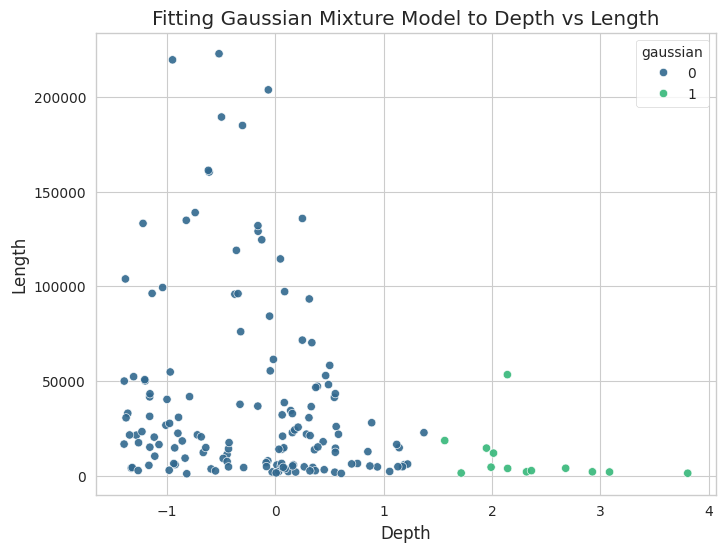

In [15]:
df = mezcla_de_gaussianas(processing[0],2, True)

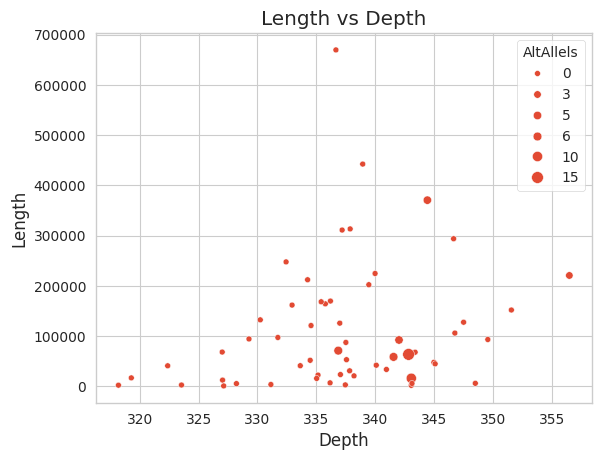

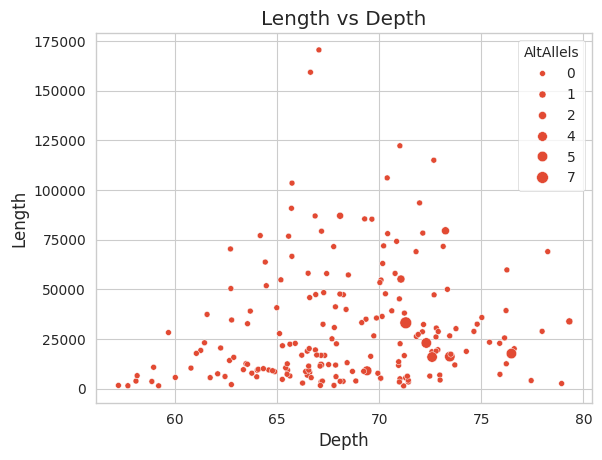

In [16]:
processing = process_genomic_data('/content/experiment_14_stats.csv', False)
df = processing[0]

sns.scatterplot(x='Depth', y='Length', data=df, size = 'AltAllels')
plt.xlabel('Depth')
plt.ylabel('Length')
plt.title('Length vs Depth')
plt.show()

processing2 = process_genomic_data('/content/experiment_104_stats.csv', False)
df2 = processing2[0]

sns.scatterplot(x='Depth', y='Length', data=df2, size = 'AltAllels')
plt.xlabel('Depth')
plt.ylabel('Length')
plt.title('Length vs Depth')
plt.show()



## **Visualización Mezcla de Gaussianas**

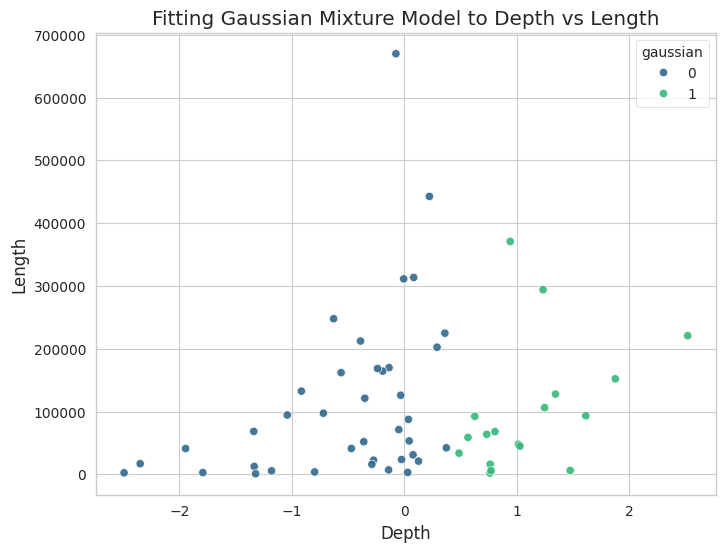

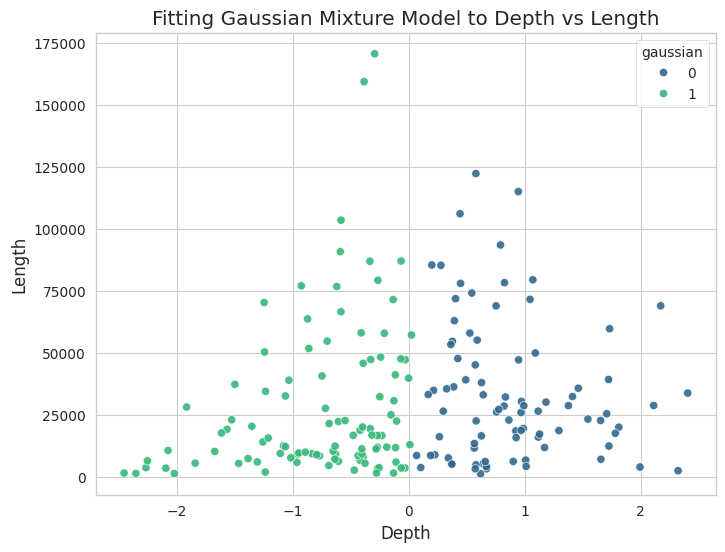

In [18]:
df = mezcla_de_gaussianas(df, 2, True)

df2 = mezcla_de_gaussianas(df2,2, True)

## **Visualización de longitudes acumuladas**

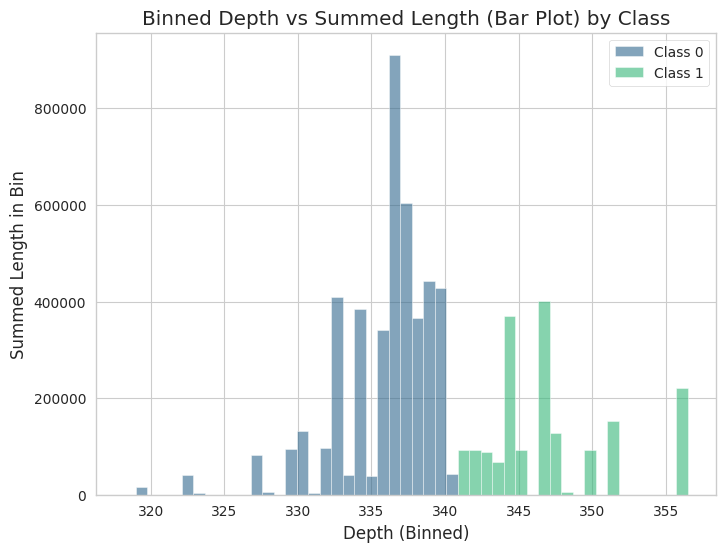

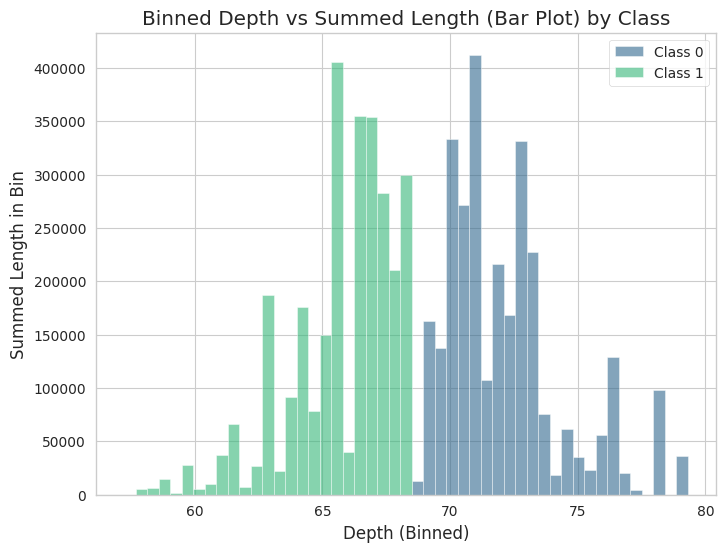

In [19]:
acumular_longitudes(df,50, True)

bins = acumular_longitudes(df2,50, True)

# **Resumen Medidas**

In [20]:
# Crear un diccionario con los datos de ejemplo
data = {
    "número de datos": [],
    "número de datos eliminados": [],
    "alelos alternativos": [],
    "N50": [],
    "longitud máxima": [],
    "segunda longitud máxima": [],
    "tercera longitud máxima": [],
    "diferencia de profundidades longitudes 1-2": [],
    "diferencia de profundidades 1-3": [],
    "suma de longitudes": [],
    "contaminación": [],
    "2 bacterias" : [],
    "GC peaks": [],
}

for i in range(1,155):
  if i >= 119:
    processing = process_genomic_data(f"/content/LengthDepth_{i-118}.csv", False)
  else:
    processing = process_genomic_data(f"/content/experiment_{i}_stats.csv", False)
  df = processing[0]
  dfg = mezcla_de_gaussianas(df,2, False)
  dfa = acumular_longitudes(dfg,50, False)
  data["número de datos"].append(len(df))
  data["número de datos eliminados"].append(processing[1])
  data["alelos alternativos"].append(processing[2])
  data["N50"].append(int(calcular_n50(dfg)))
  data["longitud máxima"].append(int(max_Depth(dfg)))
  data["segunda longitud máxima"].append(int(segunda_maxima(dfg)))
  data["tercera longitud máxima"].append(int(tercera_maxima(dfg)))
  data["diferencia de profundidades longitudes 1-2"].append(depth_difference(dfg, max_Depth(dfg), segunda_maxima(dfg)))
  data["diferencia de profundidades 1-3"].append(depth_difference(dfg, max_Depth(dfg), tercera_maxima(dfg)))
  data["suma de longitudes"].append(int(df['Length'].sum()))
  data["contaminación"].append((int(df['Length'].sum())*((processing[2]/len(df))+0.1)/calcular_n50(df)))
  data["2 bacterias"].append(two_bacterias(dfa))
  data["GC peaks"].append(GC_peaks(df, False))

# Crear un DataFrame a partir del diccionario
df = pd.DataFrame(data)
df.index = df.index + 1
# Mostrar el DataFrame
df = df.sort_values(by='contaminación', ascending=False)


In [21]:
df

número de datos  número de datos eliminados  alelos alternativos     N50  \
73              2219                        1783                10012    2751   
65              2251                        1729                 9771    2716   
154             1060                         403                  715   14823   
66              1666                        4561                   61    1834   
77              1535                        7773                   15    1545   
..               ...                         ...                  ...     ...   
3                 13                          10                    2  856340   
40                13                           8                    0  358597   
42                12                           6                    0  359278   
44                11                           7                    0  382464   
33                 8                           6                    0  259343   

     longitud máxima  segunda longitud máxima  tercera longitud máxima  \
73             66779                    51603                    42743   
65             80912                    65777                    49299   
154            81633                    78411                    77141   
66             10152                     7429                     6706   
77              9187                     7221                     7170   
..               ...                      ...                      ...   
3             959455                   883940                   856340   
40            496297                   377799                   358597   
42            496302                   377799                   359278   
44            691724                   382464                   212878   
33            524780                   259343                   205915   

     diferencia de profundidades longitudes 1-2  \
73                                   170.417919   
65                                   270.779568   
154                                   71.771000   
66                                     0.829839   
77                                     2.607239   
..                                          ...   
3                                     17.139160   
40                                    74.772889   
42                                    66.596566   
44                                     9.691504   
33                                    24.763277   

     diferencia de profundidades 1-3  suma de longitudes  contaminación  \
73                        178.664689             5518274    9251.167348   
65                          0.085536             5549827    9074.125405   
154                         0.865000             8634872     451.187529   
66                          6.553262             2994862     223.087247   
77                          4.923624             2427029     172.439997   
..                               ...                 ...            ...   
3                         112.770773             3707947       1.099152   
40                         33.980101             2255472       0.628971   
42                         31.405829             2257024       0.628211   
44                         27.794081             1965609       0.513933   
33                         56.075098             1288025       0.496649   

     2 bacterias  GC peaks  
73     63.550474         1  
65     43.235951         1  
154    83.419689         1  
66     49.312897         1  
77     54.762239         1  
..           ...       ...  
3     109.165530         1  
40    105.296574         1  
42    120.258508         1  
44    114.002585         1  
33     72.664250         1  

[154 rows x 13 columns]

In [24]:
df = df.sort_values(by='2 bacterias', ascending=False)
df.tail(10)

número de datos  número de datos eliminados  alelos alternativos     N50  \
124              185                          84                   75   73385   
58               139                          97                   80   96291   
125               90                          30                   60  174294   
101               94                          31                   10  180145   
123              121                          57                   61  155639   
120              313                          96                  106   55811   
87                68                          51                   31  140377   
28                56                          15                   34  243031   
121              163                          72                   46   96398   
32                50                          17                   90  300660   

     longitud máxima  segunda longitud máxima  tercera longitud máxima  \
124           259472                   206226                   186891   
58            222757                   219530                   203698   
125           367366                   365868                   331638   
101           386901                   377673                   338258   
123           375220                   367619                   367375   
120           259248                   174760                   156530   
87            371877                   296799                   241603   
28            602146                   593318                   321748   
121           488560                   224831                   174010   
32            804353                   594065                   339440   

     diferencia de profundidades longitudes 1-2  \
124                                    8.021000   
58                                    12.596484   
125                                   18.761000   
101                                   15.739517   
123                                   21.178000   
120                                   53.632000   
87                                     6.364908   
28                                     4.901063   
121                                   19.153000   
32                                     6.718177   

     diferencia de profundidades 1-3  suma de longitudes  contaminación  \
124                        53.286000             6798117      46.818901   
58                         13.679398             5698957      39.981628   
125                        17.947000             6781048      29.827782   
101                         9.096444             5091515       5.833090   
123                        17.312000             6913327      26.834943   
120                        10.366000             6933881      54.498278   
87                          1.840971             4501079      17.823934   
28                          5.700544             4827666      14.046971   
121                        20.409000             6846435      27.145441   
32                         22.405647             3981109      25.158342   

     2 bacterias  GC peaks  
124    25.915795         2  
58     25.256072         1  
125    24.848309         1  
101    23.972506         2  
123    23.170731         1  
120    20.967151         2  
87     19.711093         1  
28     19.456252         2  
121    16.281103         2  
32     15.354698         1

In [25]:
df.head(10)

número de datos  número de datos eliminados  alelos alternativos     N50  \
30                62                          21                   34  190849   
34                17                           7                   11  313543   
68               375                         128                  221   42546   
146               34                          20                    4   95695   
45                10                           5                    6  341633   
76               336                         143                  244   45432   
43                17                           6                    3  249401   
57                24                           6                   19  329136   
133               31                          12                   50  260004   
84                60                          15                   15  131472   

     longitud máxima  segunda longitud máxima  tercera longitud máxima  \
30            445838                   403924                   386711   
34            511331                   443620                   316131   
68            220068                   170942                   150933   
146           245490                   153669                   140127   
45            401990                   382250                   341633   
76            358863                   171060                   142709   
43            586482                   347990                   249401   
57            700859                   597779                   494552   
133           509308                   392324                   323796   
84            391417                   229758                   226636   

     diferencia de profundidades longitudes 1-2  \
30                                   197.543046   
34                                    19.900186   
68                                    20.719409   
146                                  207.983000   
45                                    73.274273   
76                                    24.288197   
43                                    72.091349   
57                                    45.623948   
133                                   21.005000   
84                                    24.775388   

     diferencia de profundidades 1-3  suma de longitudes  contaminación  \
30                        178.387130             5470199      18.584360   
34                         63.860294             3157595       7.523399   
68                          6.896217             8170031     132.371426   
146                        15.726000             1861828       4.234510   
45                         39.886479             1989394       4.076233   
76                          0.727771             7741413     140.779224   
43                        119.180937             2286726       2.534924   
57                         80.820322             4170763      11.299069   
133                        20.303000             4393721      28.945781   
84                          6.838073             4575983      12.182016   

     2 bacterias  GC peaks  
30    258.754964         2  
34    243.035544         1  
68    232.476282         1  
146   224.678181         1  
45    223.672373         1  
76    217.251079         1  
43    216.680644         1  
57    196.067334         1  
133   187.374704         1  
84    186.738684         1

Basándonos en observaciones empíricas creamos nuestros umbrales de clasificación:

In [26]:
def clasificacion(final):
  if final > 1000:
    return 'contaminado'
  elif final > 323 and final <= 1000:
    return '2 bacterias'
  else:
    return '1 bacteria'

La métrica de 2 bacterias se multiplica por la cantidad de picos observados en el GC.

Ponderamos la métrica final considerando 3 veces la primera métrica y 2 veces la segunda.

In [27]:
cdf = df
cdf['2 bacterias'] = cdf['2 bacterias']*cdf['GC peaks']
cdf = cdf[['2 bacterias', 'contaminación']]
cdf['final'] = cdf['2 bacterias']*3 + cdf['contaminación']*2
cdf = cdf.sort_values(by='final', ascending=False)
cdf['clasificacion'] = cdf['final'].apply(clasificacion)



<ipython-input-27-ffce4559d5d0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['final'] = cdf['2 bacterias']*3 + cdf['contaminación']*2


In [28]:
cdf

2 bacterias  contaminación         final clasificacion
73     63.550474    9251.167348  18692.986118   contaminado
65     43.235951    9074.125405  18277.958663   contaminado
30    517.509928      18.584360   1589.698502   contaminado
154    83.419689     451.187529   1152.634126   contaminado
134   330.034032      39.760281   1069.622658   contaminado
..           ...            ...           ...           ...
123    23.170731      26.834943    123.182078    1 bacteria
144    36.102951       5.198508    118.705869    1 bacteria
152    26.968864      17.827425    116.561442    1 bacteria
32     15.354698      25.158342     96.380778    1 bacteria
87     19.711093      17.823934     94.781148    1 bacteria

[154 rows x 4 columns]

Veamos cómo quedaron los experimentos del peor al mejor:

73 contaminado


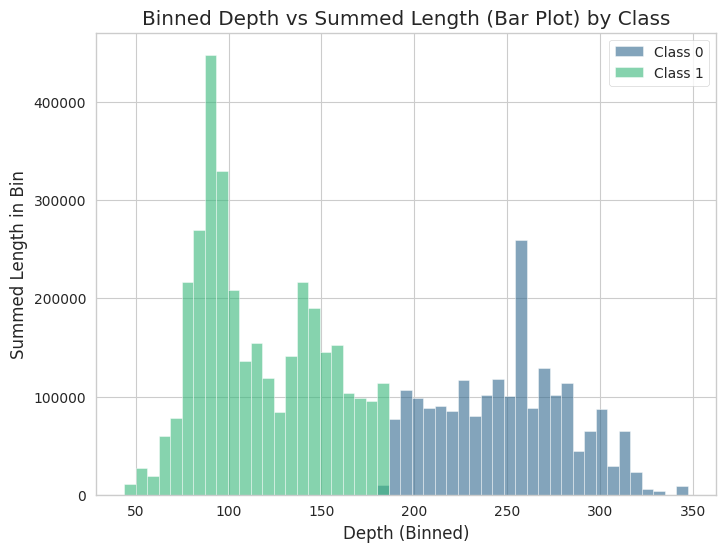

65 contaminado


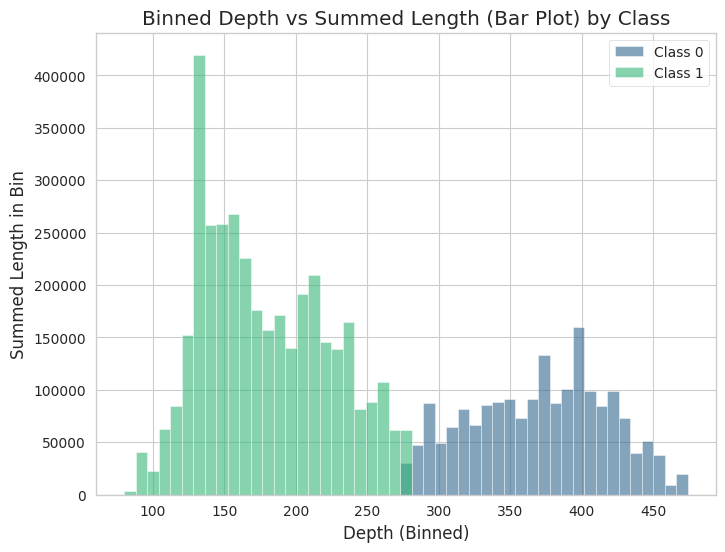

30 contaminado


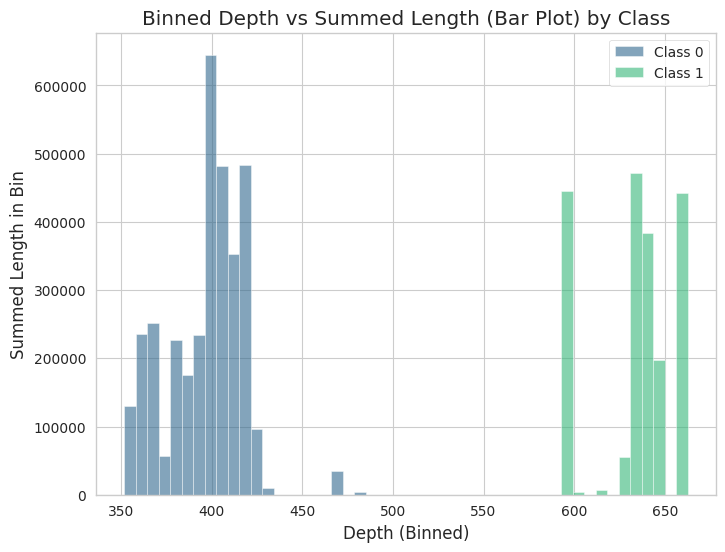

236 contaminado


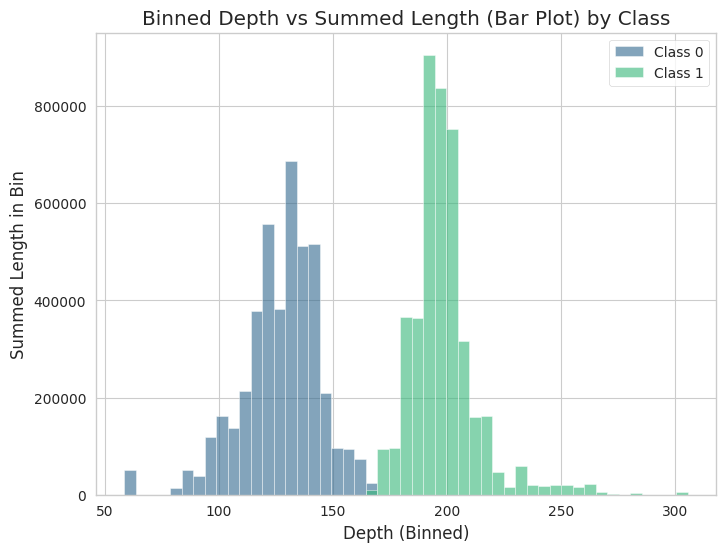

216 contaminado


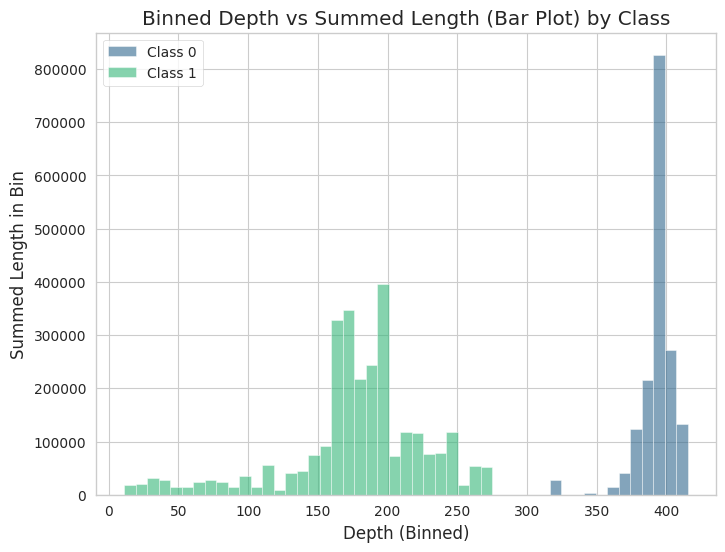

68 2 bacterias


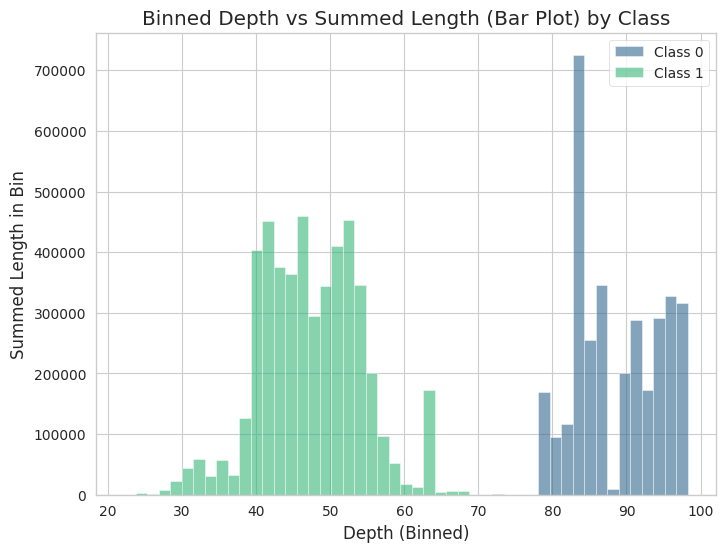

76 2 bacterias


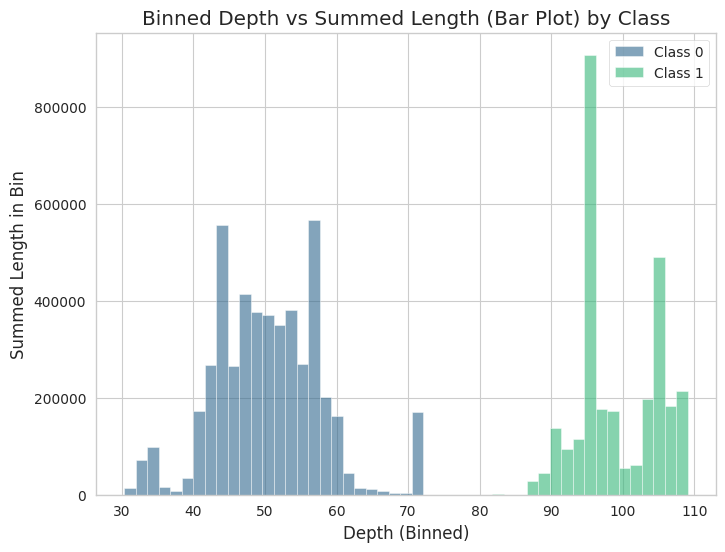

222 2 bacterias


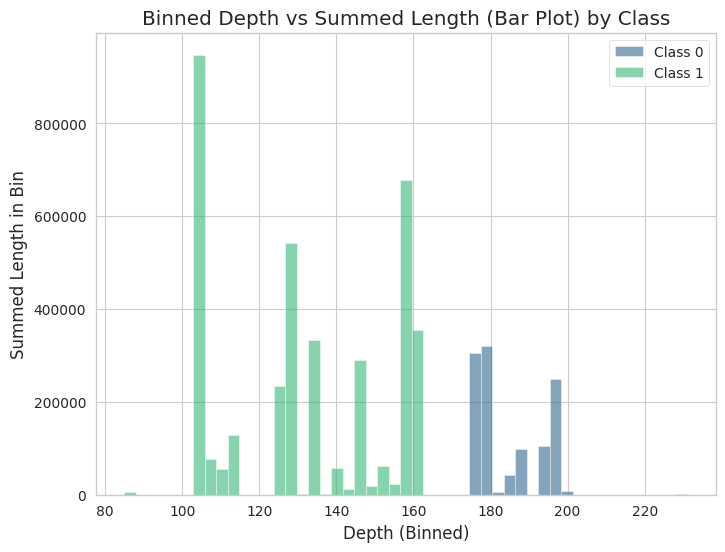

34 2 bacterias


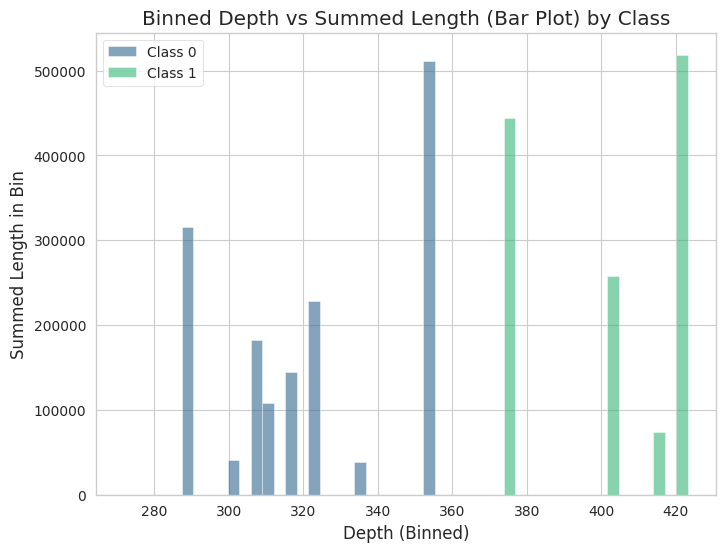

11 2 bacterias


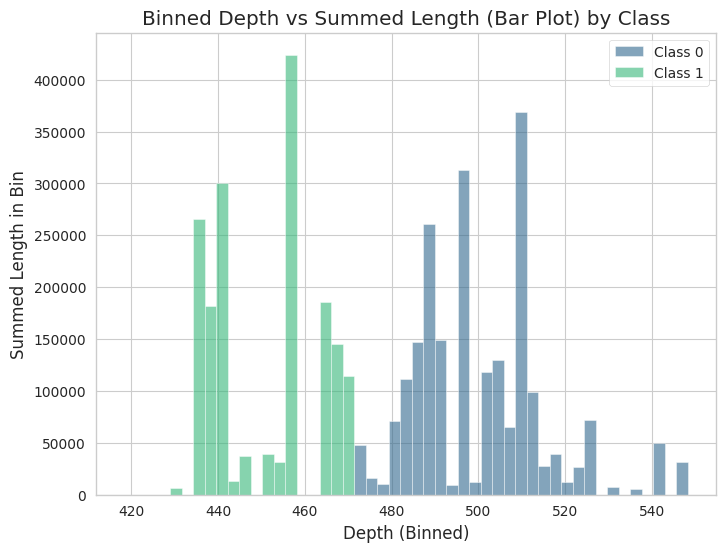

228 2 bacterias


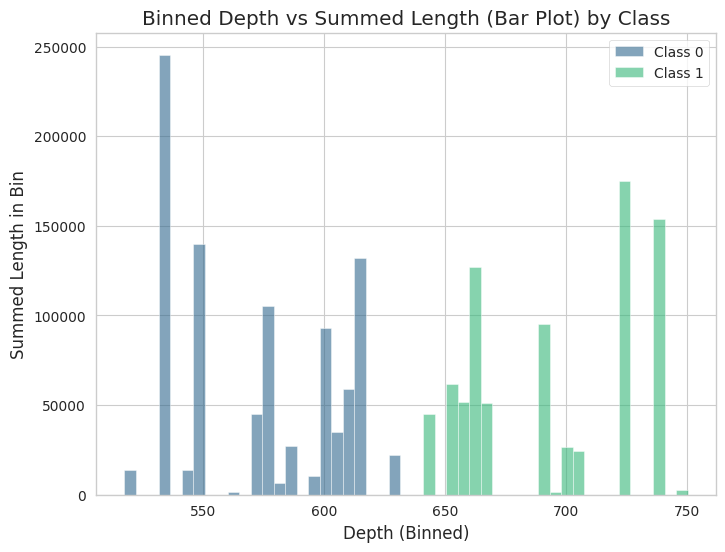

45 2 bacterias


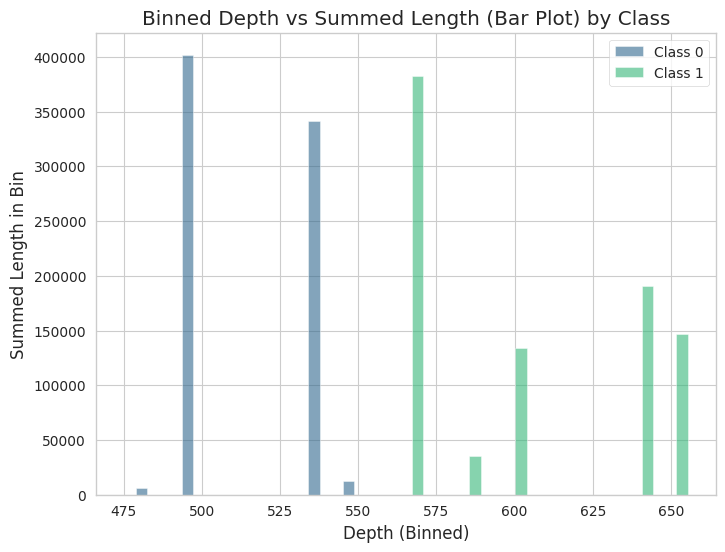

88 2 bacterias


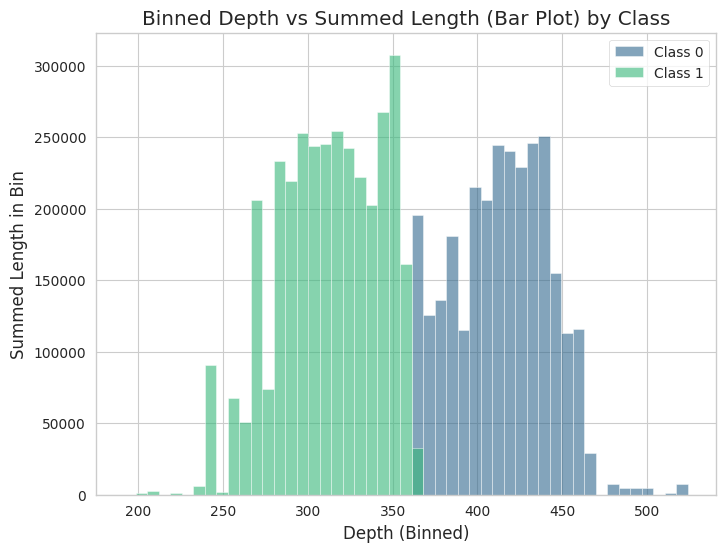

43 2 bacterias


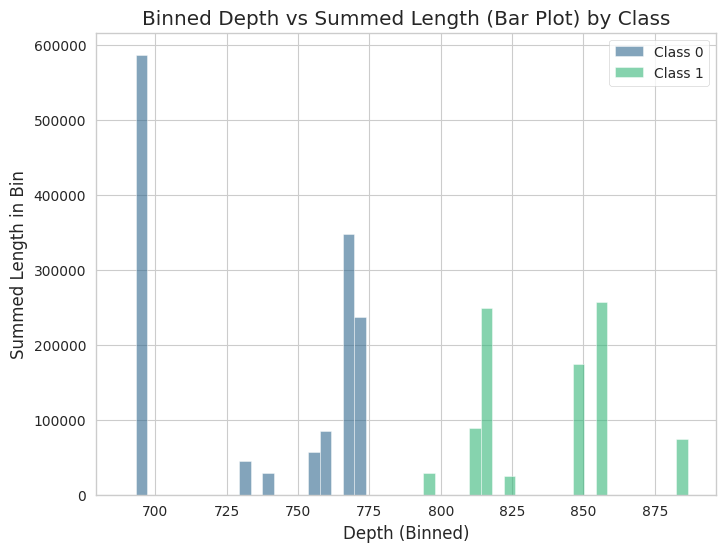

215 2 bacterias


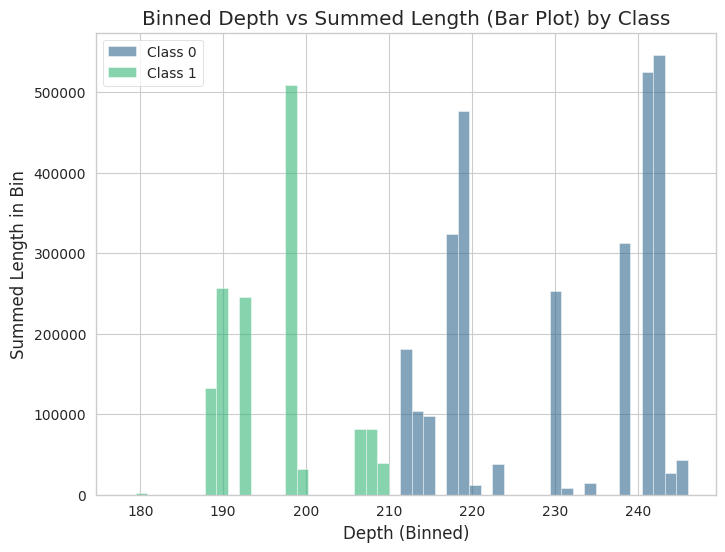

57 2 bacterias


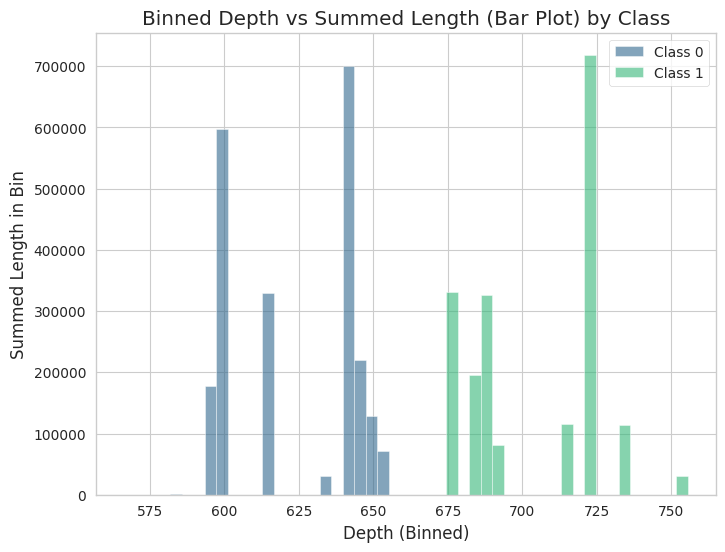

66 2 bacterias


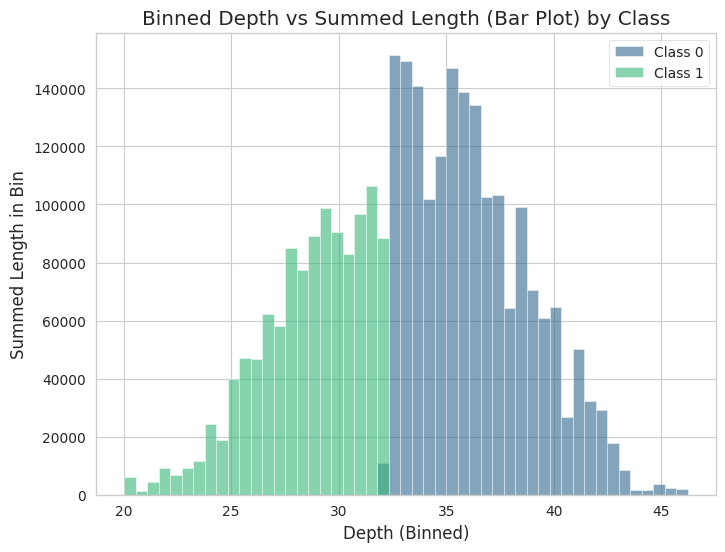

84 2 bacterias


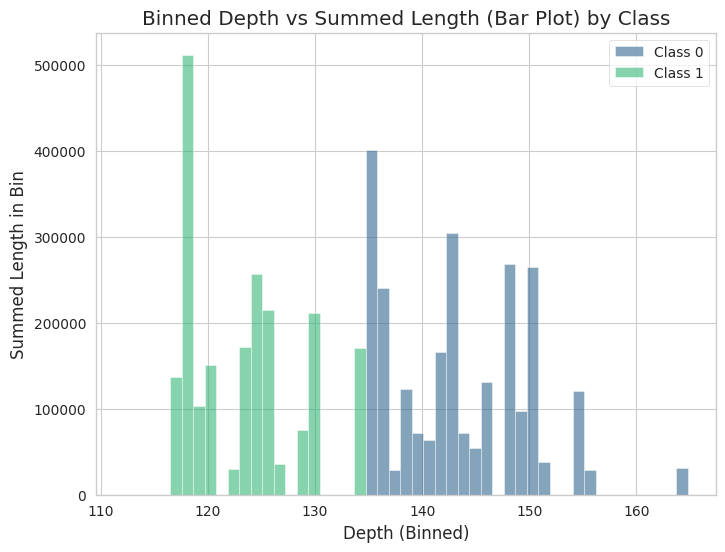

93 2 bacterias


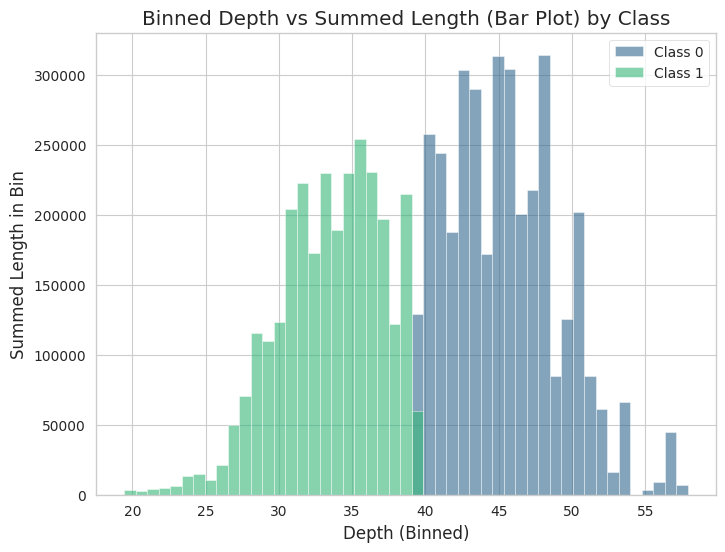

35 2 bacterias


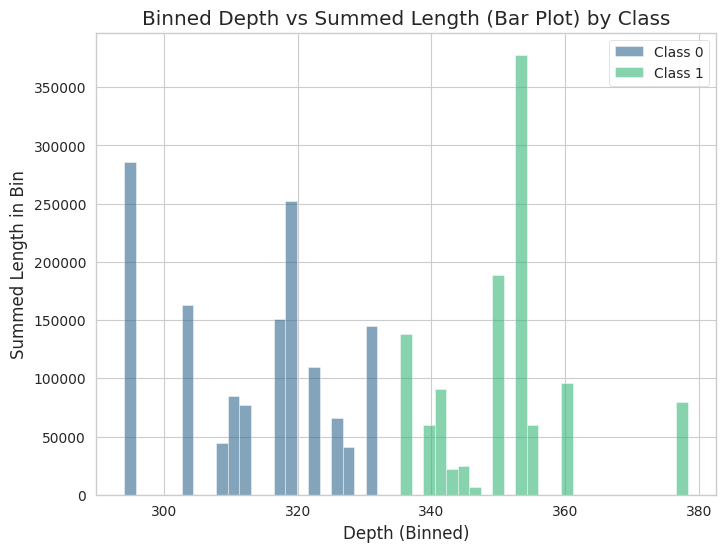

231 2 bacterias


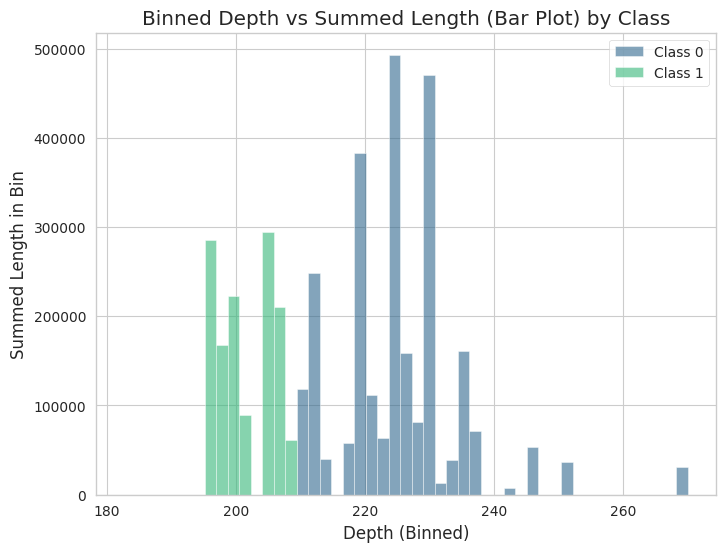

111 2 bacterias


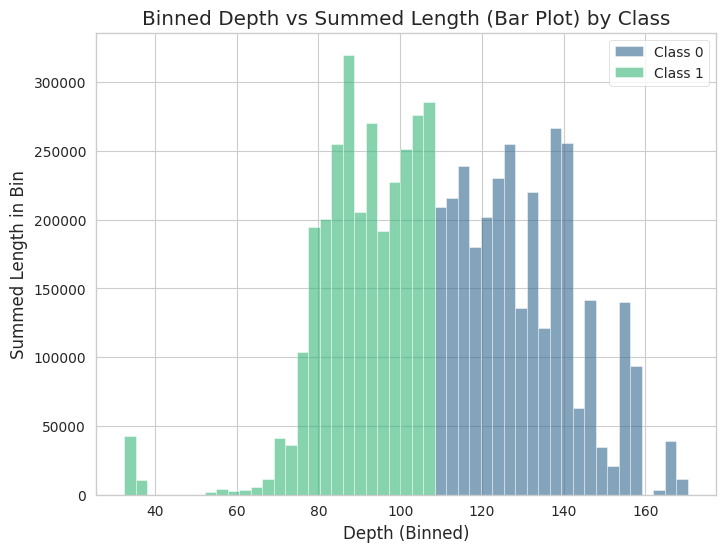

80 2 bacterias


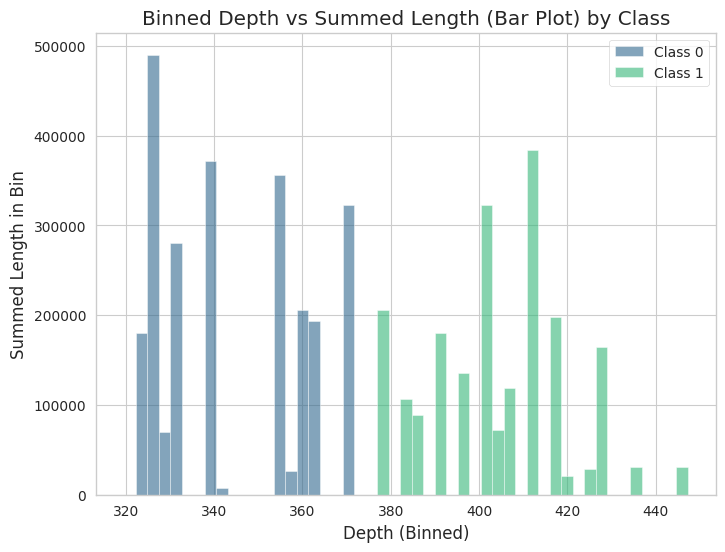

230 2 bacterias


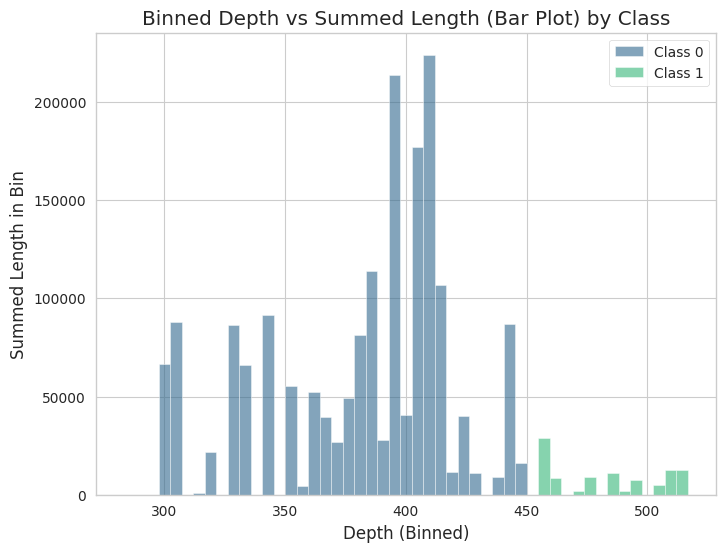

97 2 bacterias


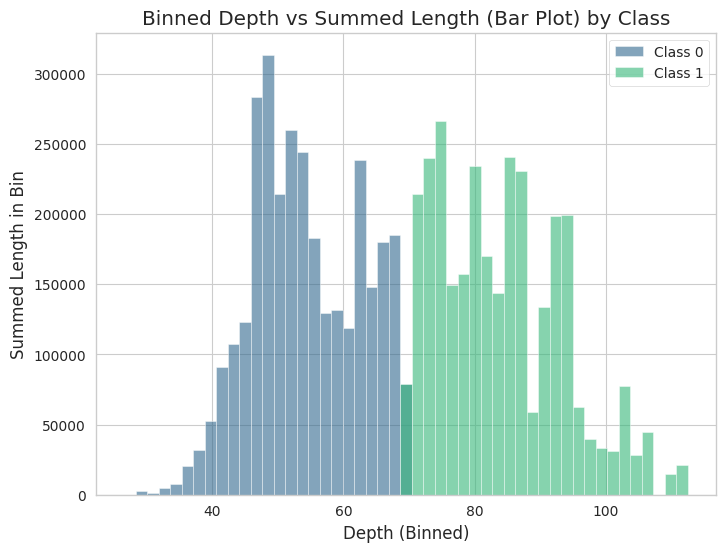

116 2 bacterias


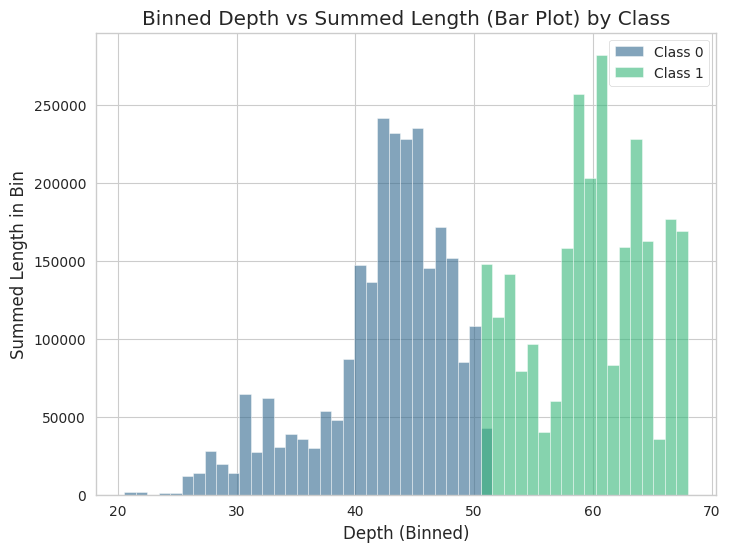

77 2 bacterias


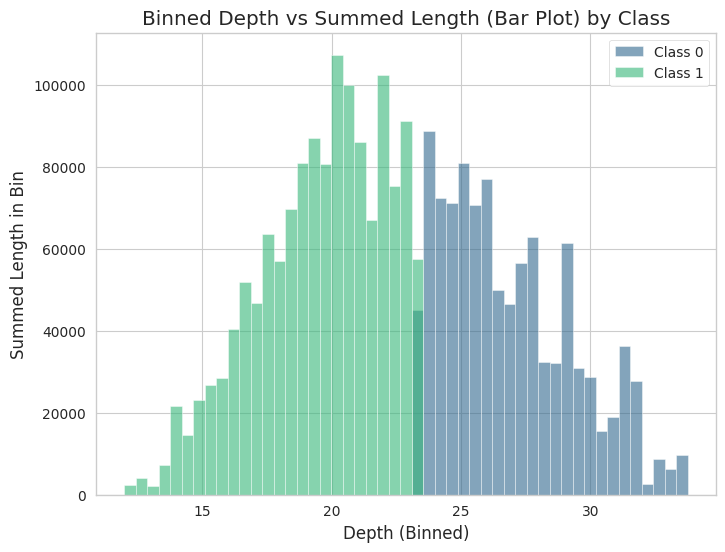

55 2 bacterias


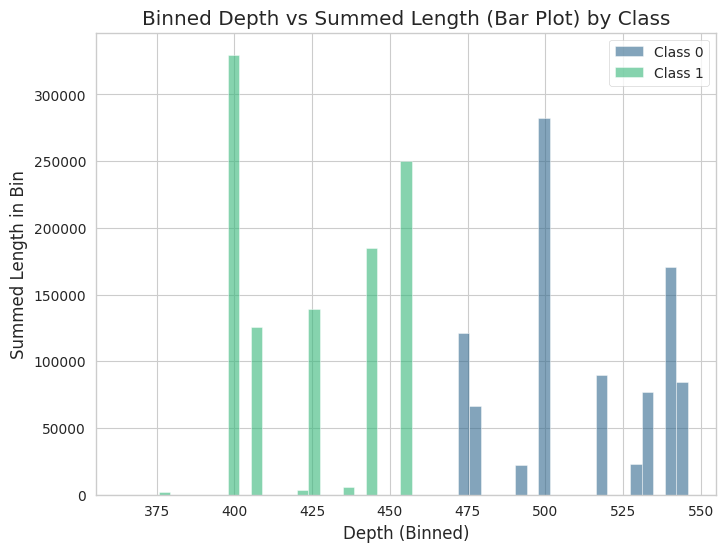

110 2 bacterias


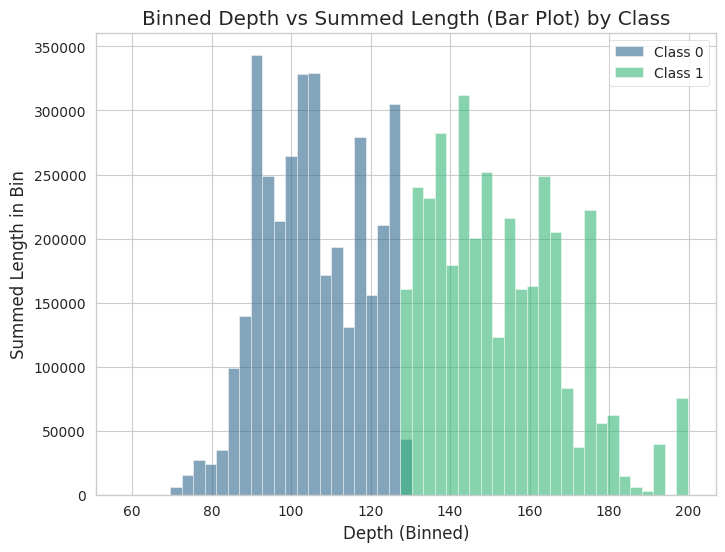

225 2 bacterias


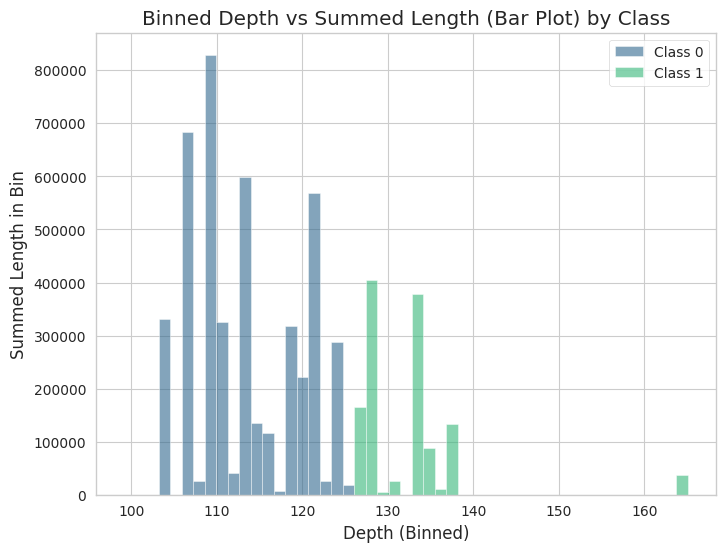

5 2 bacterias


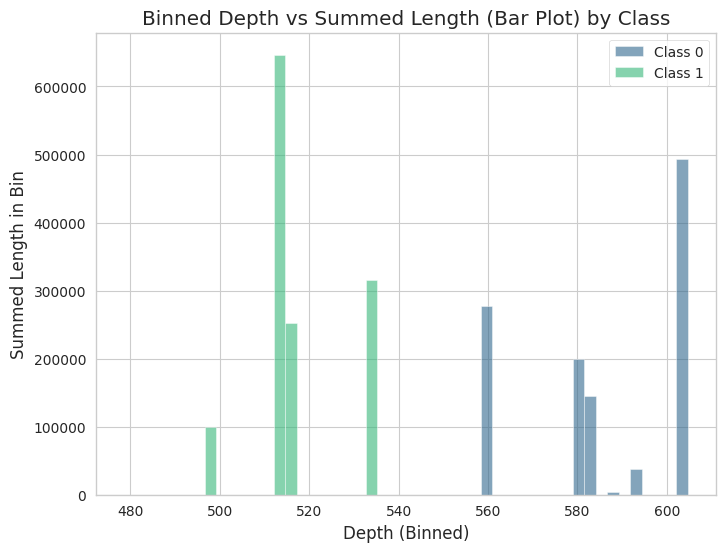

94 2 bacterias


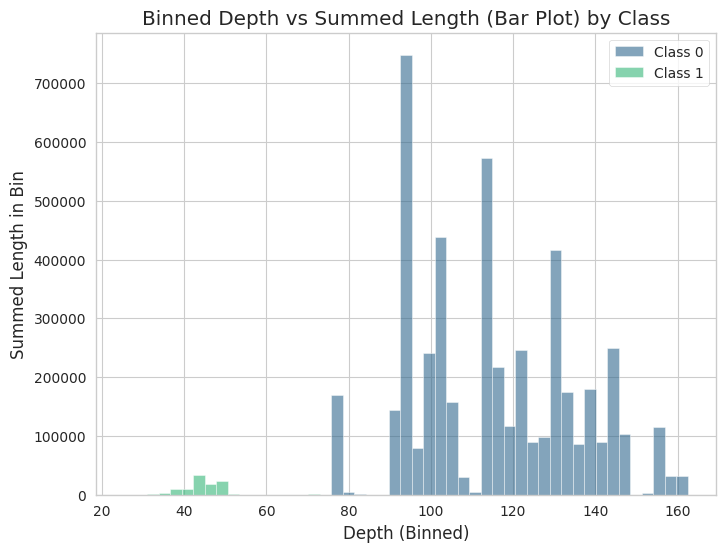

232 2 bacterias


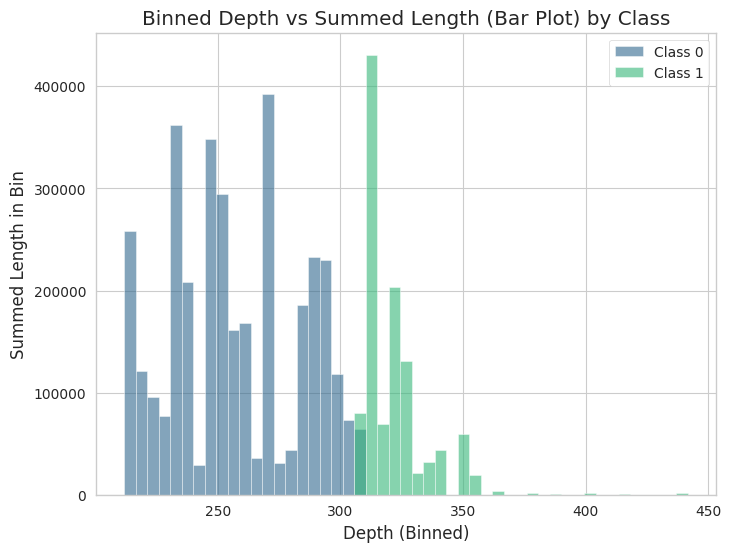

36 2 bacterias


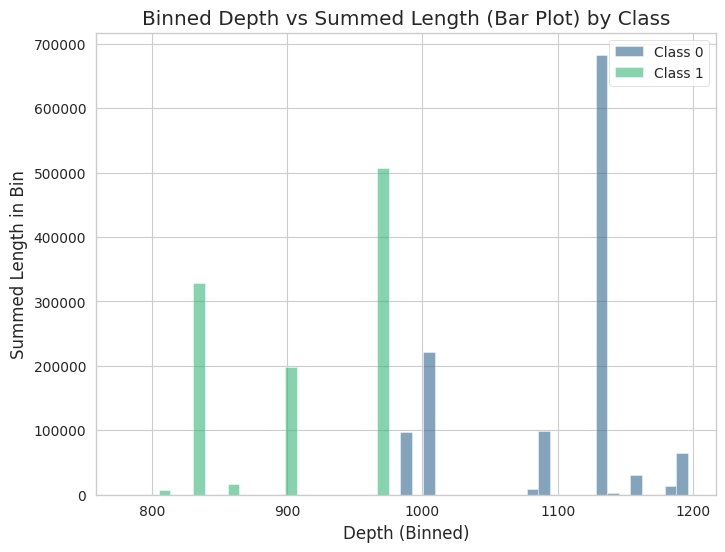

82 2 bacterias


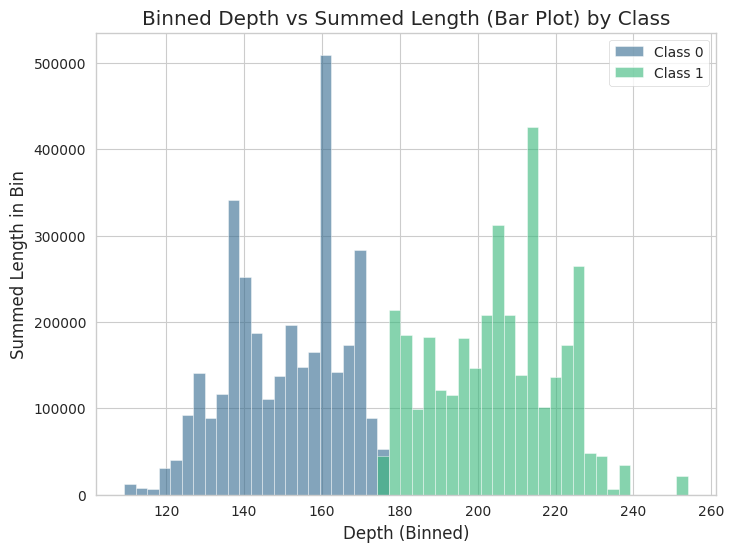

48 2 bacterias


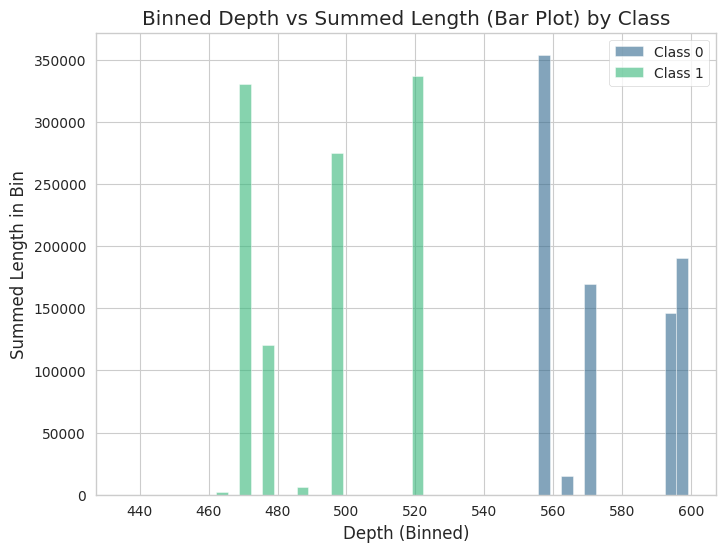

38 2 bacterias


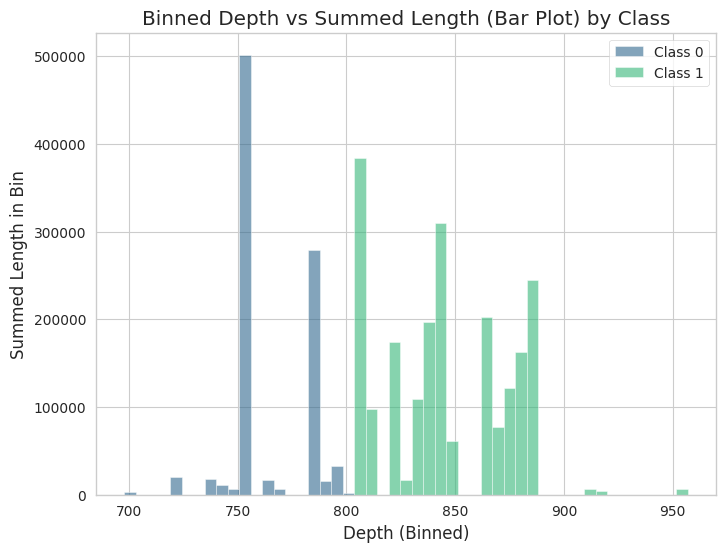

103 2 bacterias


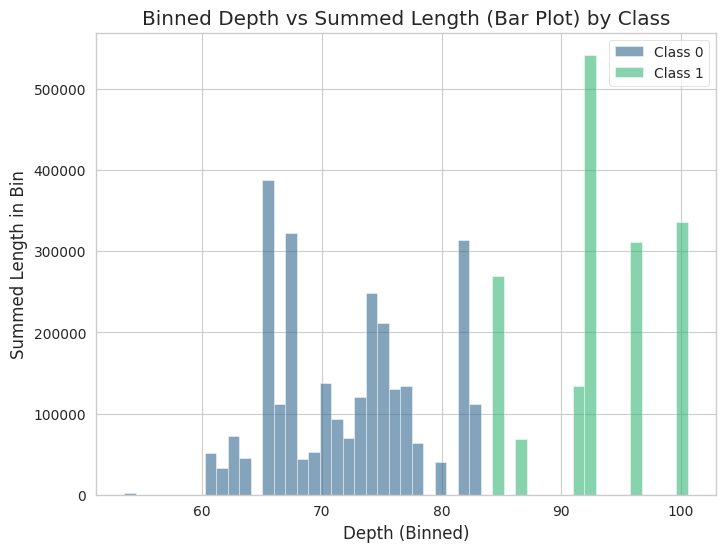

118 2 bacterias


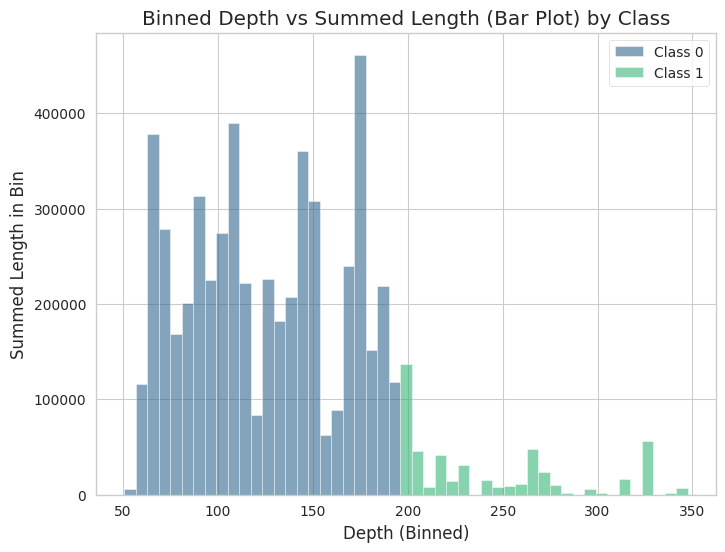

92 2 bacterias


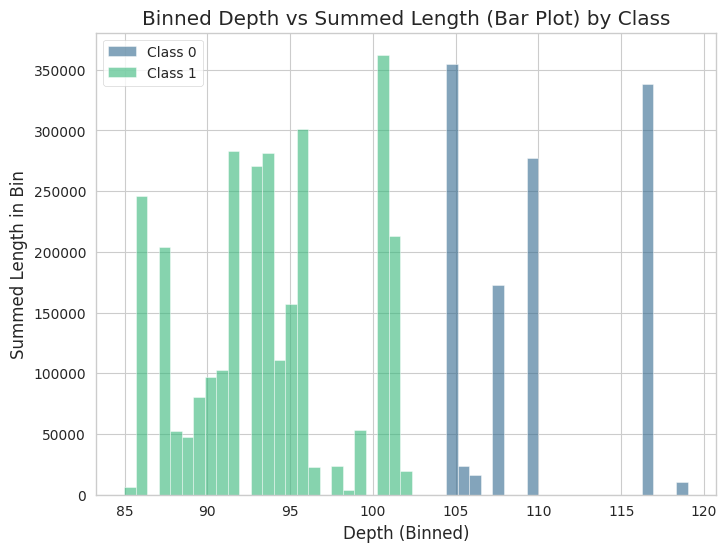

72 2 bacterias


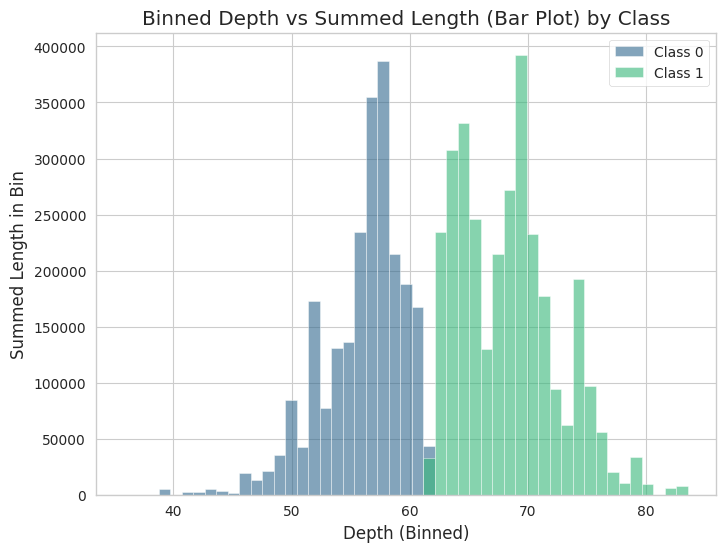

10 2 bacterias


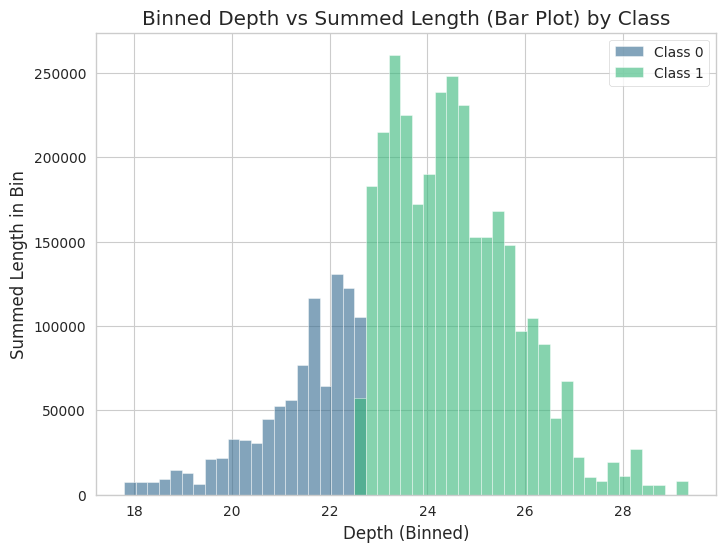

223 2 bacterias


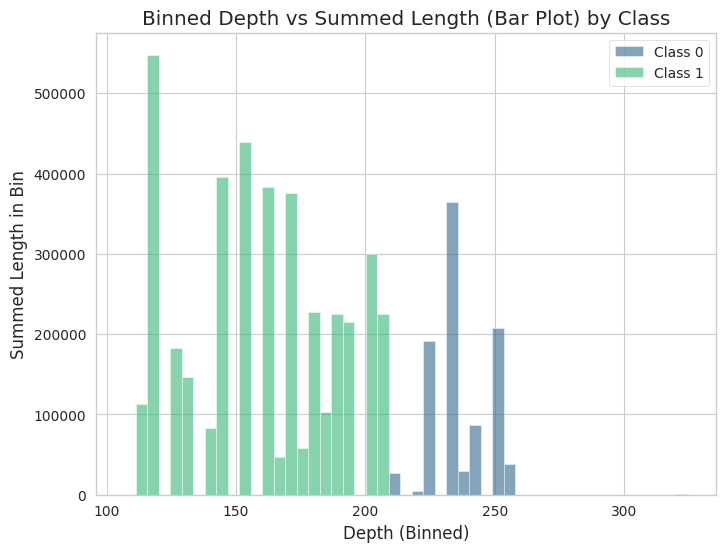

201 2 bacterias


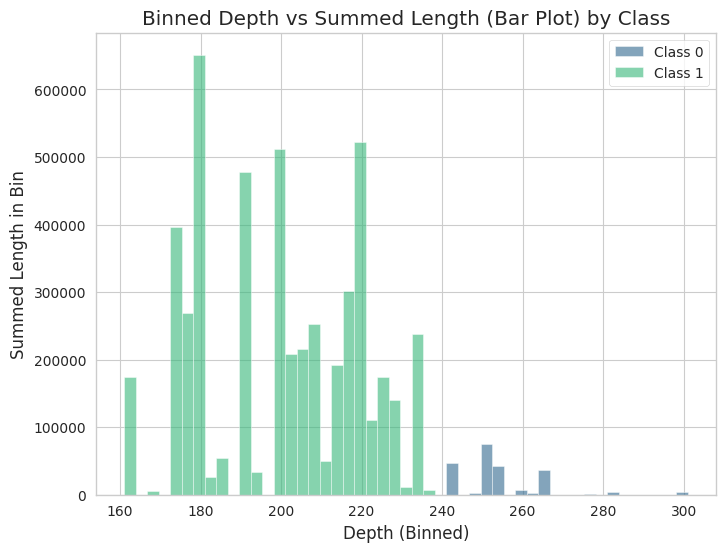

90 2 bacterias


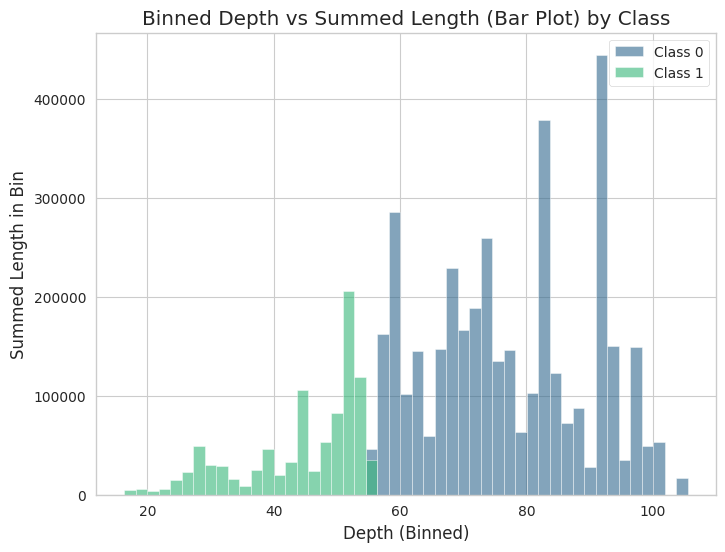

221 2 bacterias


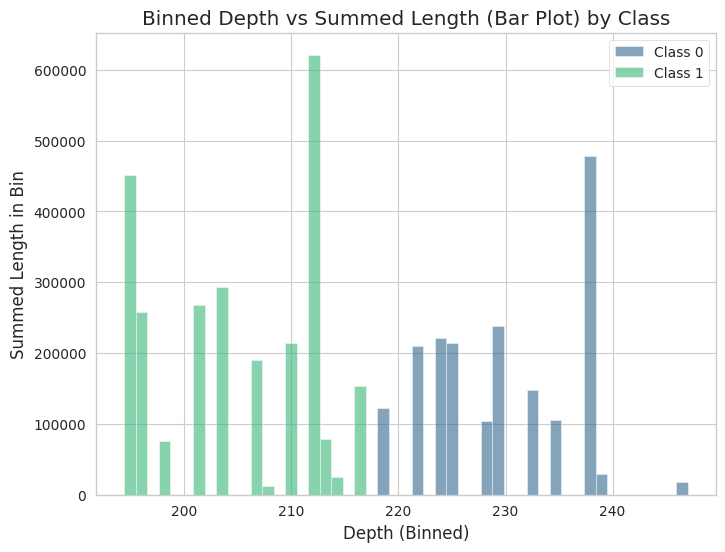

63 2 bacterias


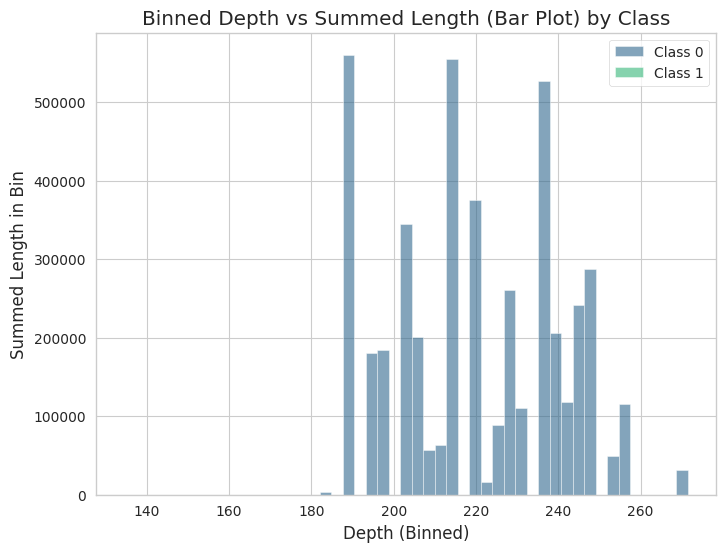

78 2 bacterias


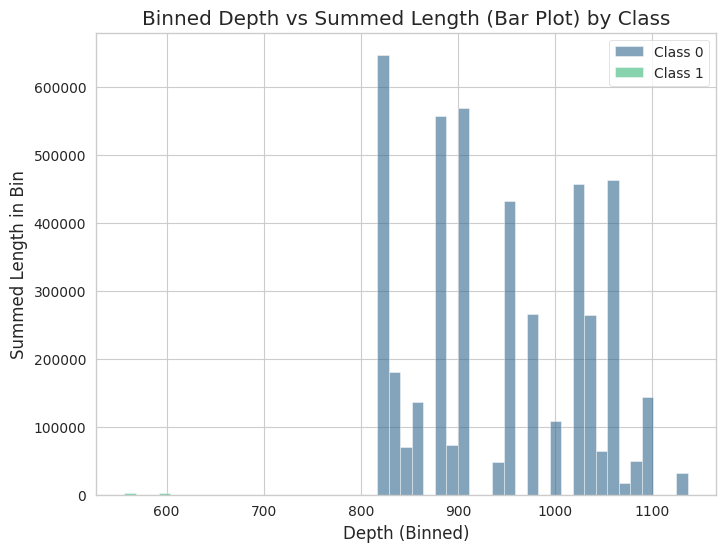

69 2 bacterias


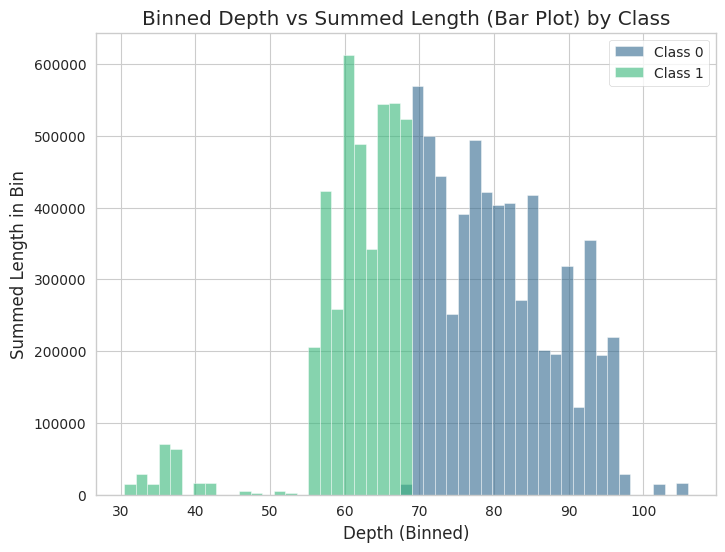

102 2 bacterias


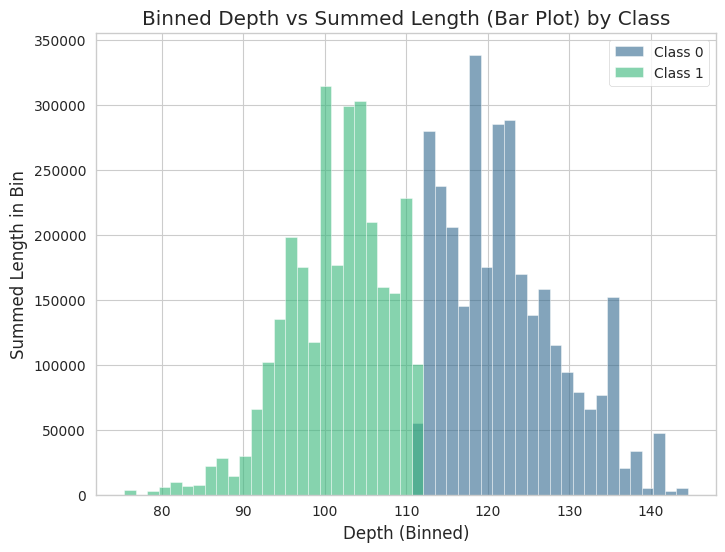

52 2 bacterias


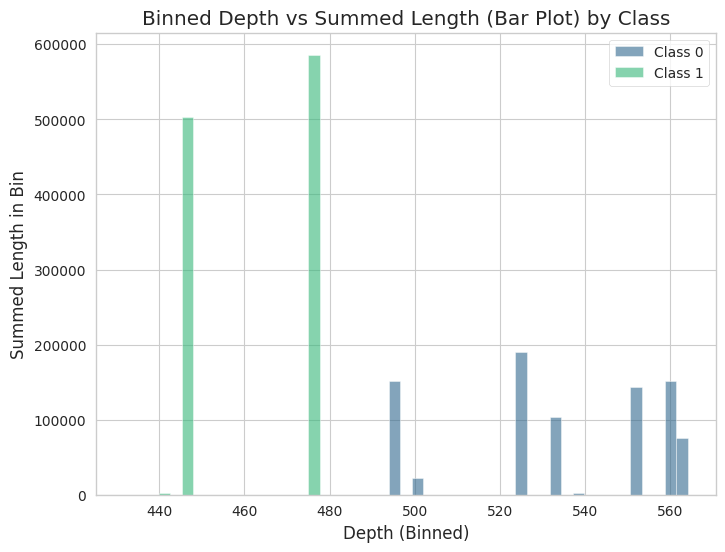

9 2 bacterias


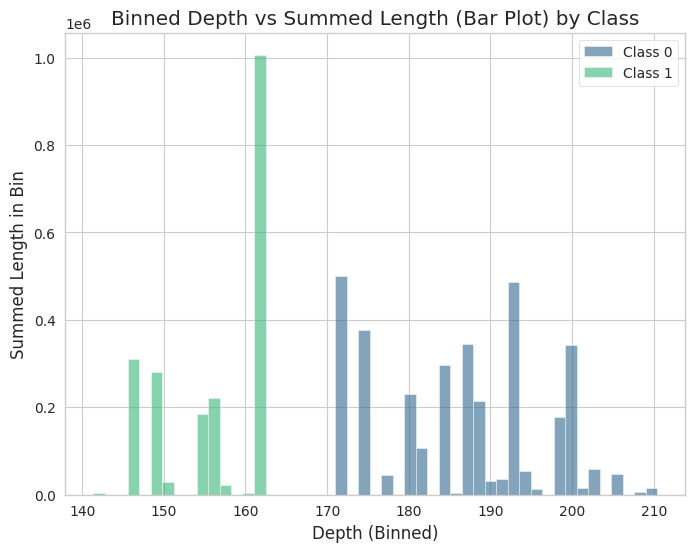

105 2 bacterias


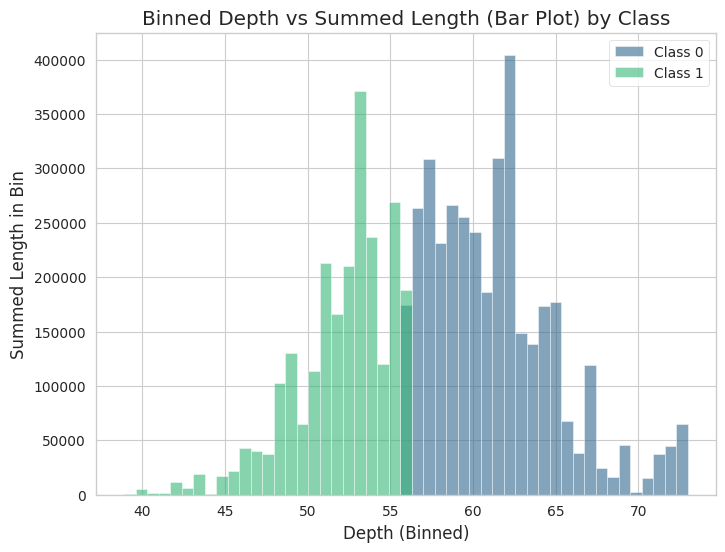

59 2 bacterias


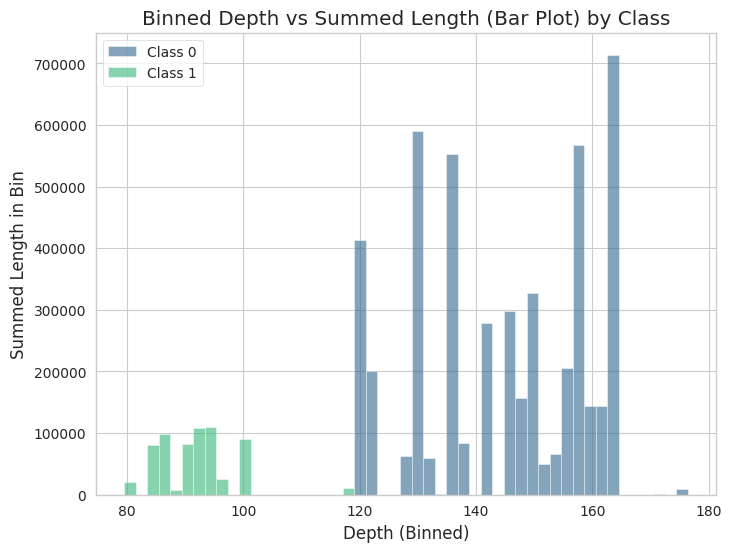

114 2 bacterias


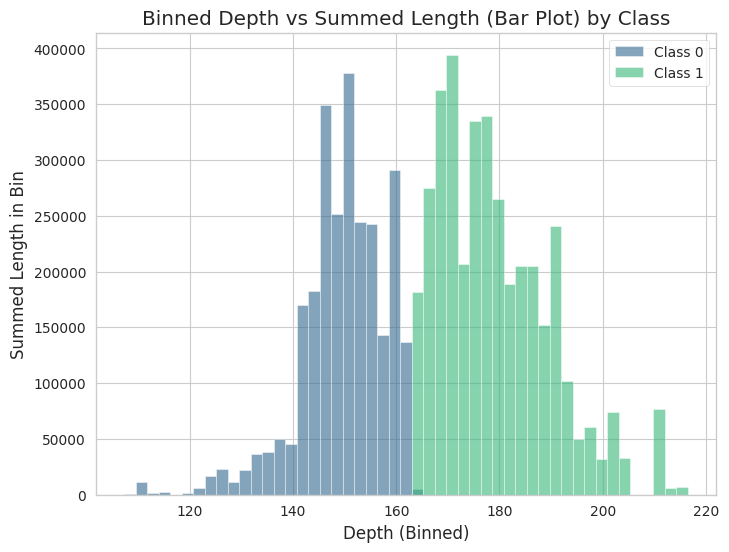

71 2 bacterias


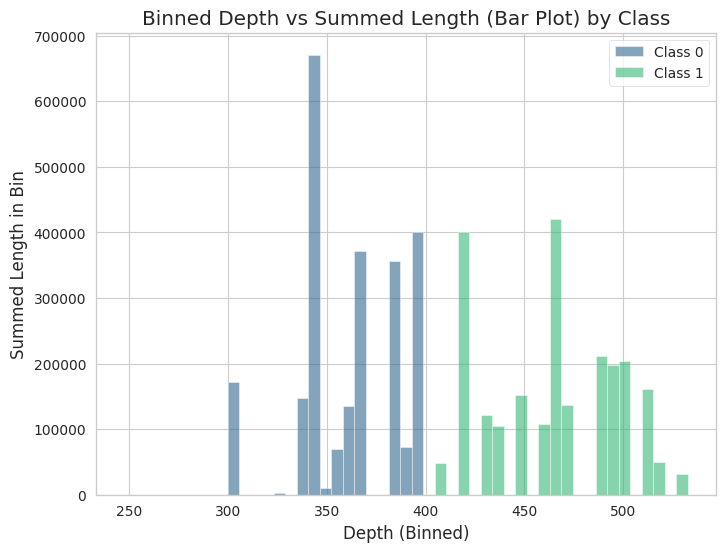

86 2 bacterias


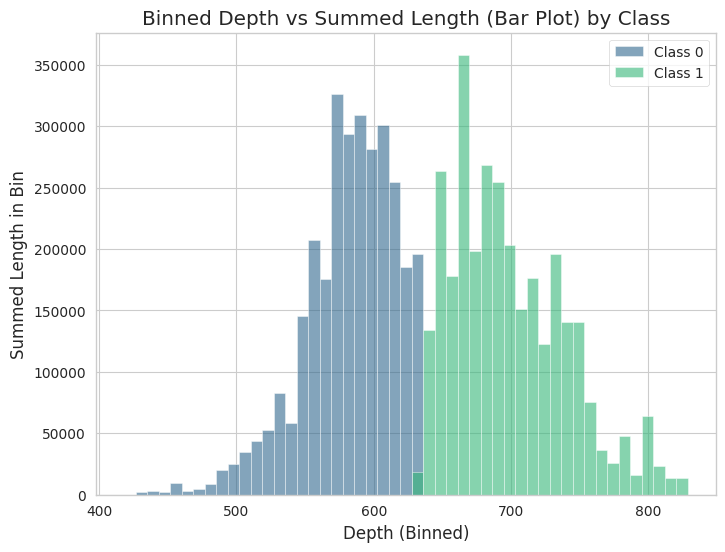

115 2 bacterias


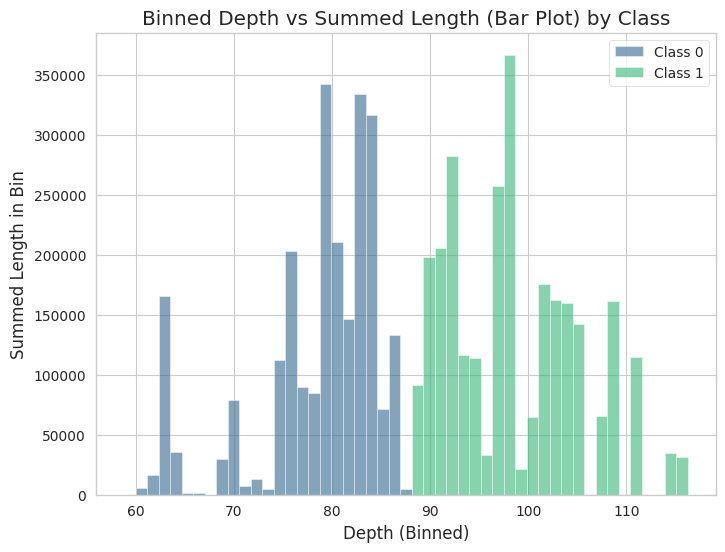

12 2 bacterias


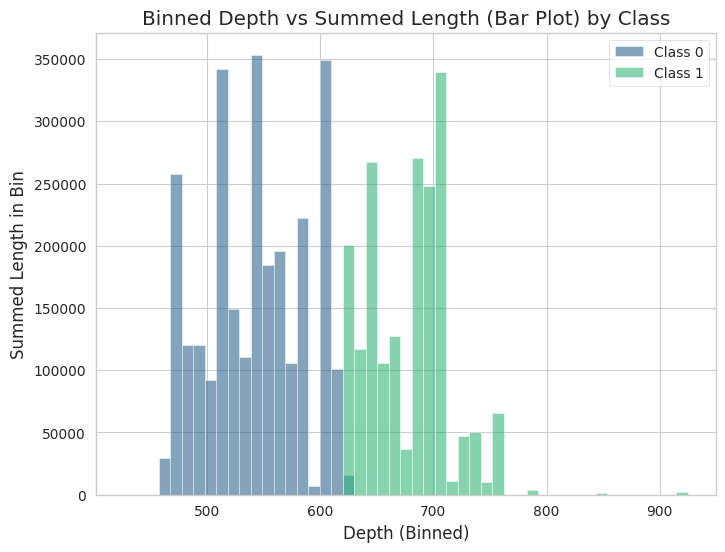

233 2 bacterias


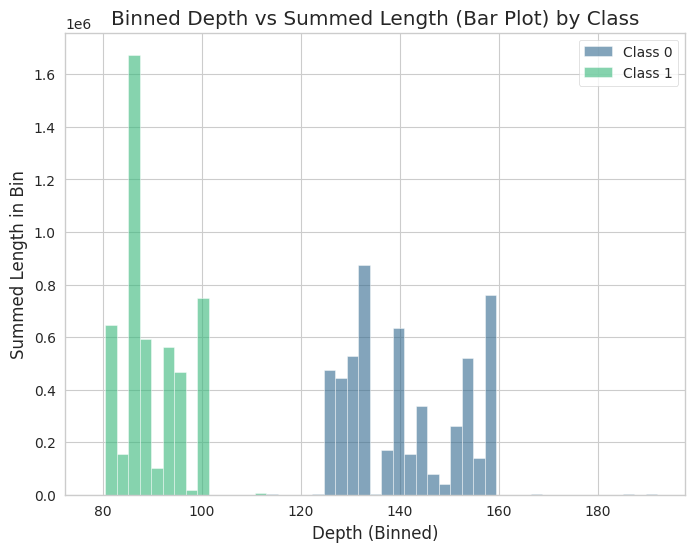

42 2 bacterias


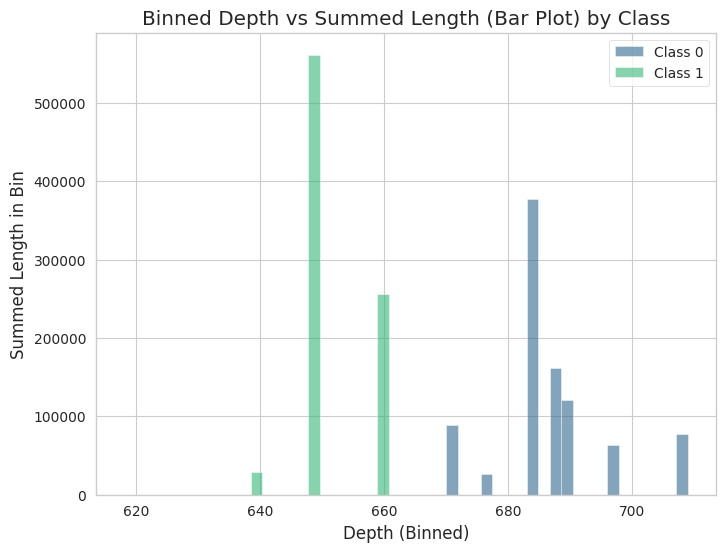

211 2 bacterias


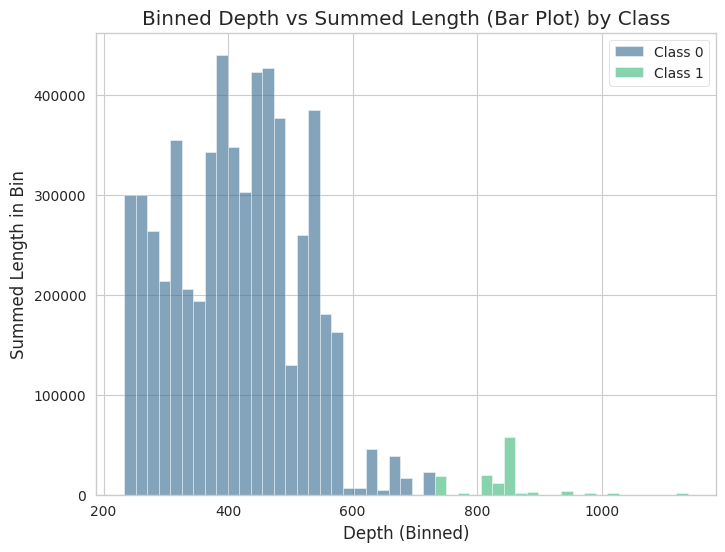

1 2 bacterias


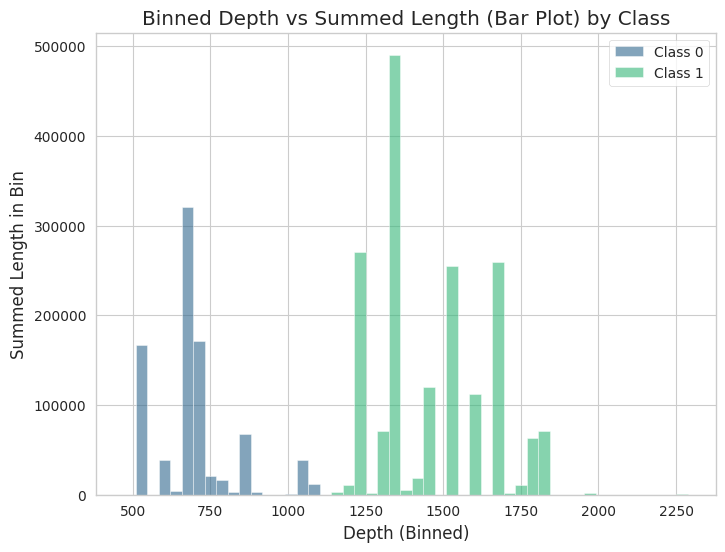

227 2 bacterias


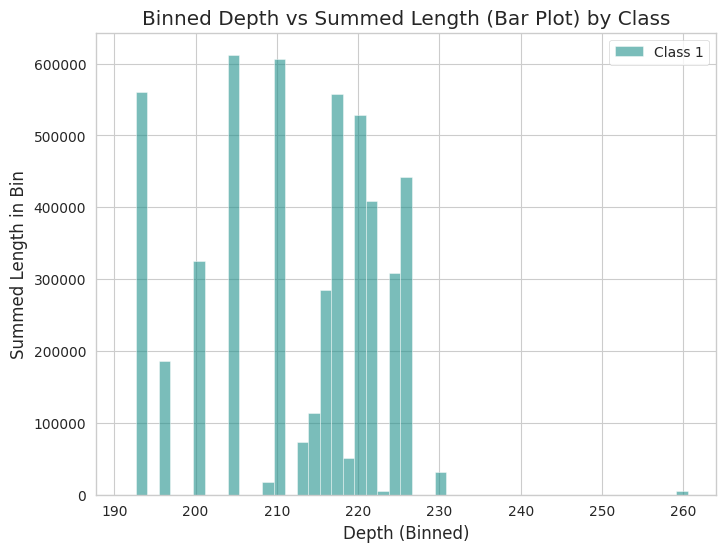

44 2 bacterias


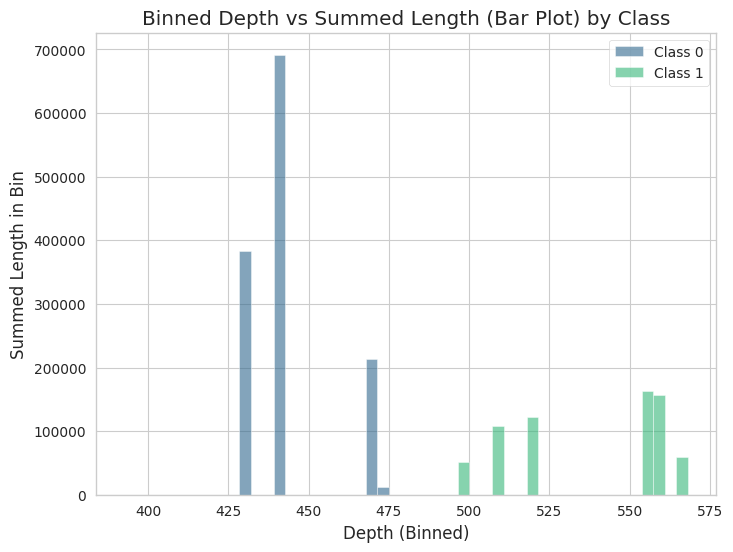

67 2 bacterias


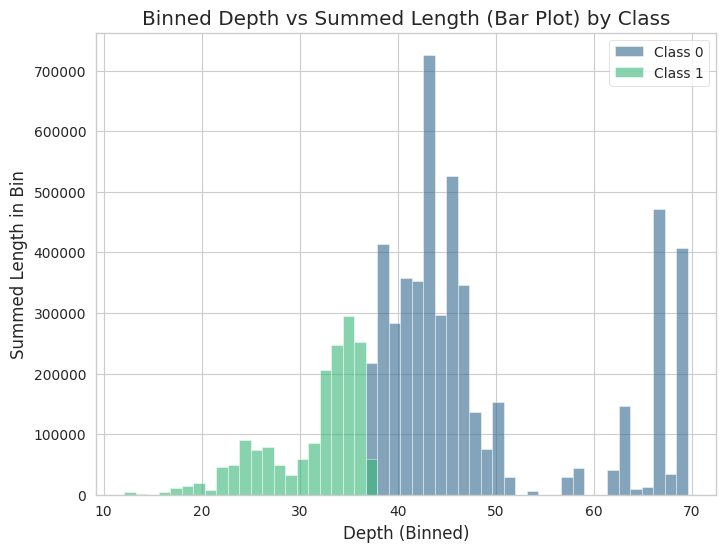

27 2 bacterias


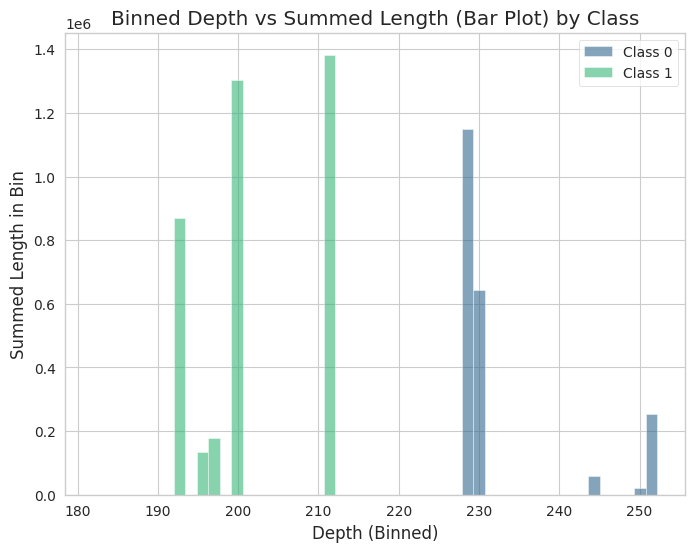

108 2 bacterias


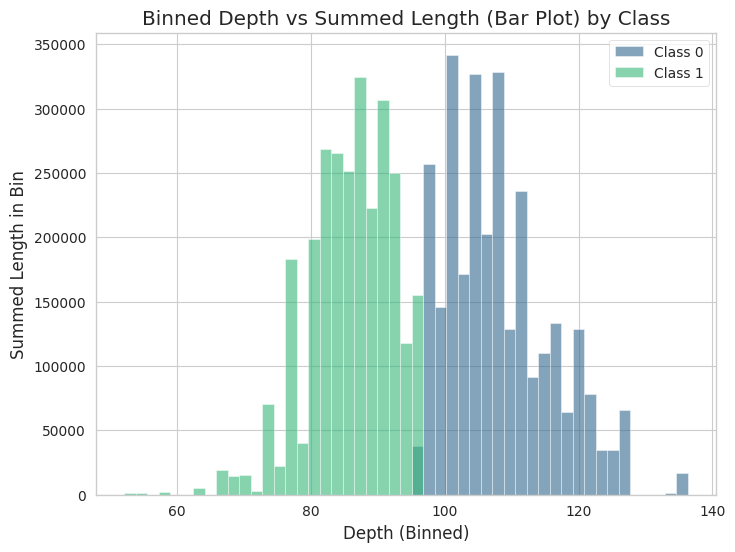

3 2 bacterias


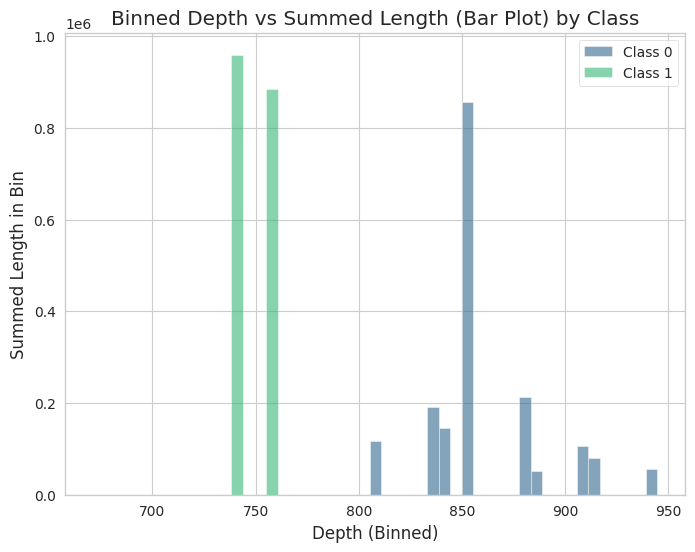

109 2 bacterias


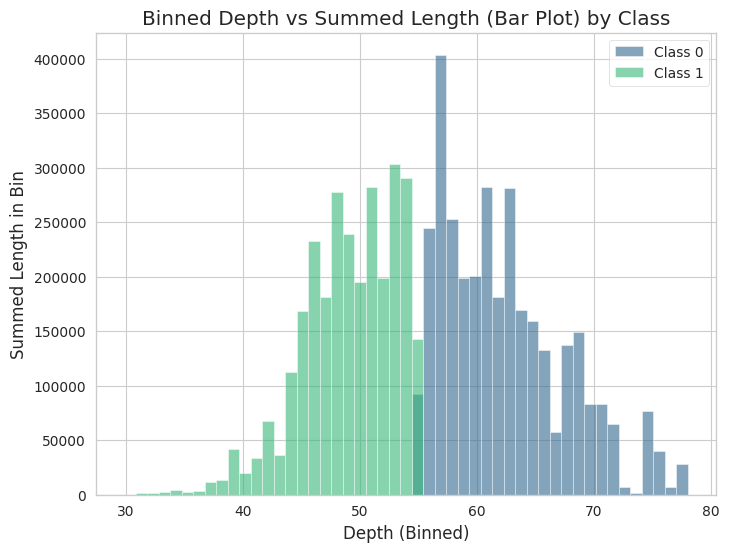

26 2 bacterias


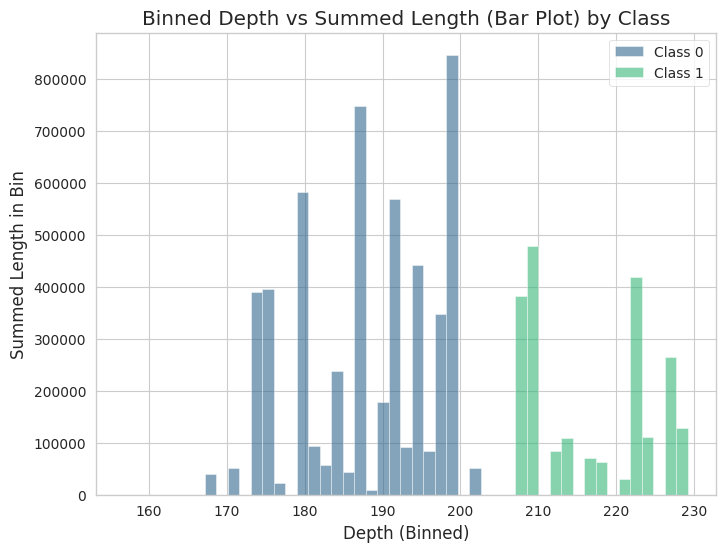

208 2 bacterias


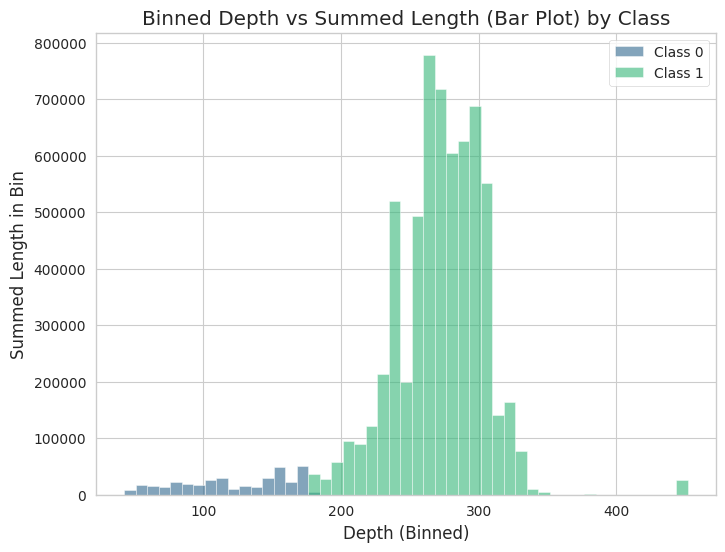

40 1 bacteria


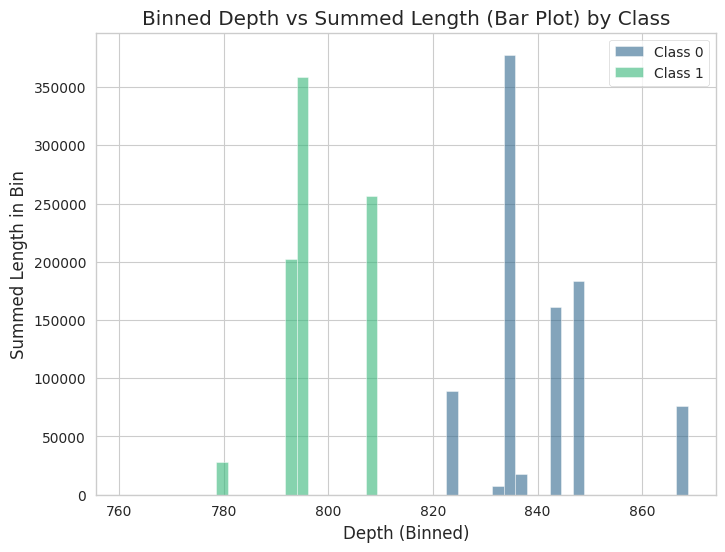

6 1 bacteria


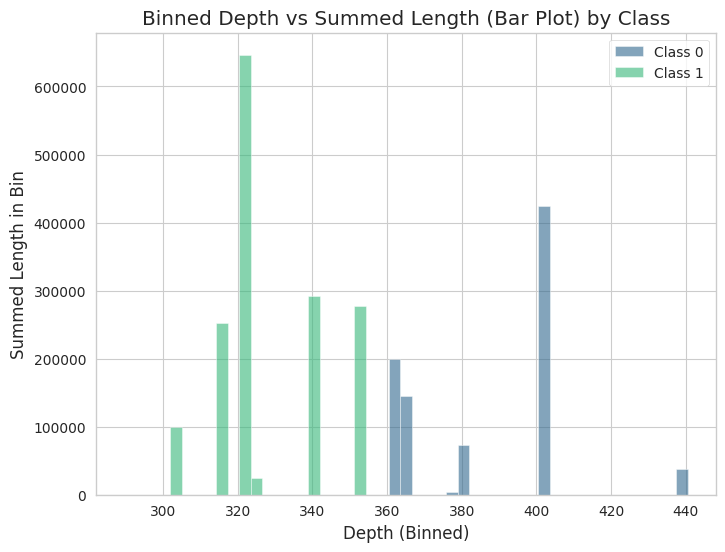

47 1 bacteria


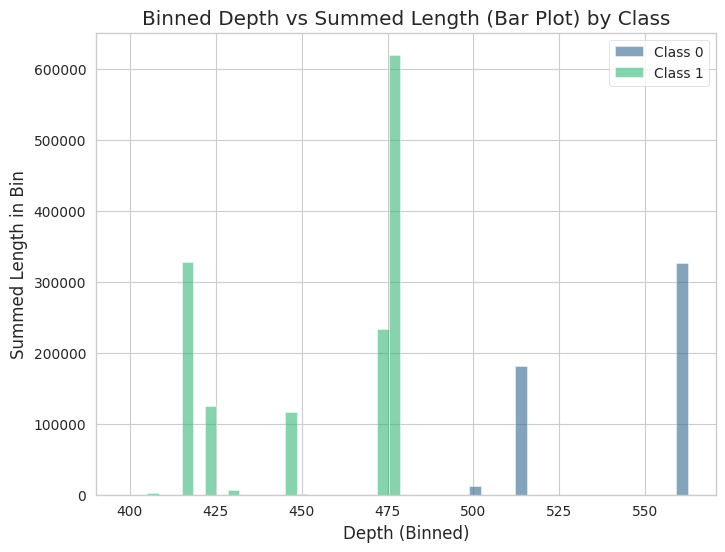

104 1 bacteria


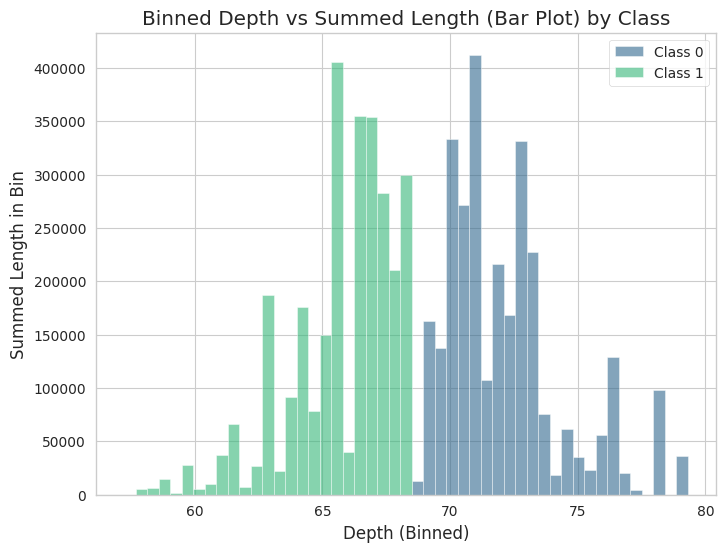

2 1 bacteria


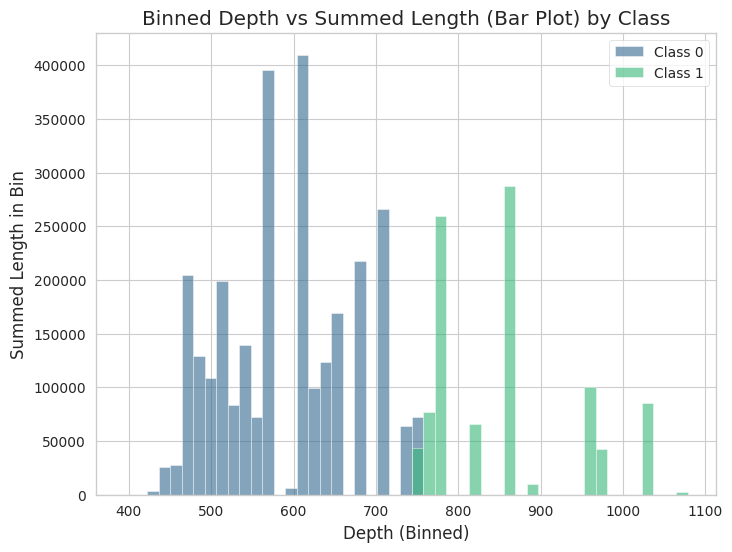

51 1 bacteria


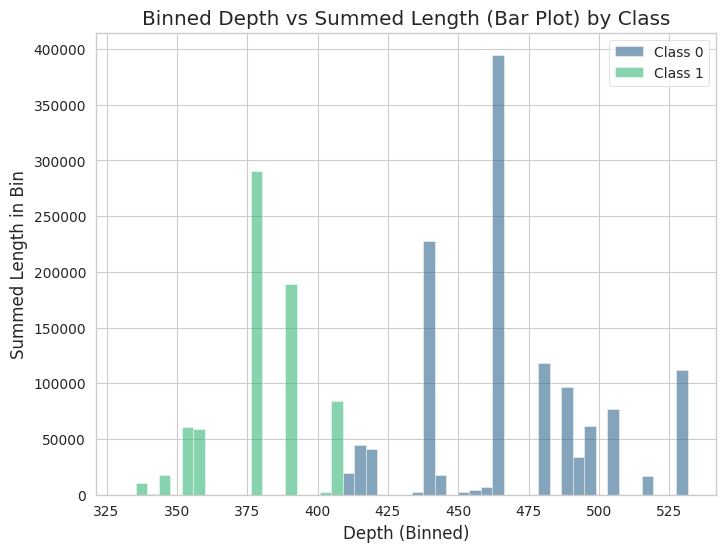

213 1 bacteria


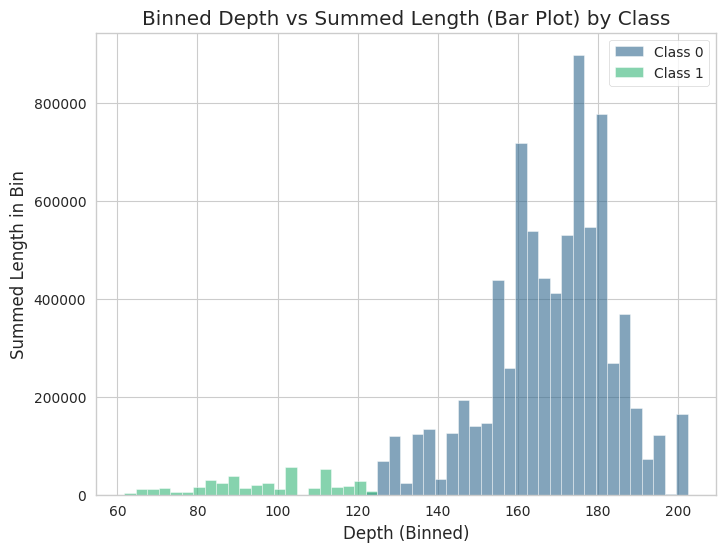

112 1 bacteria


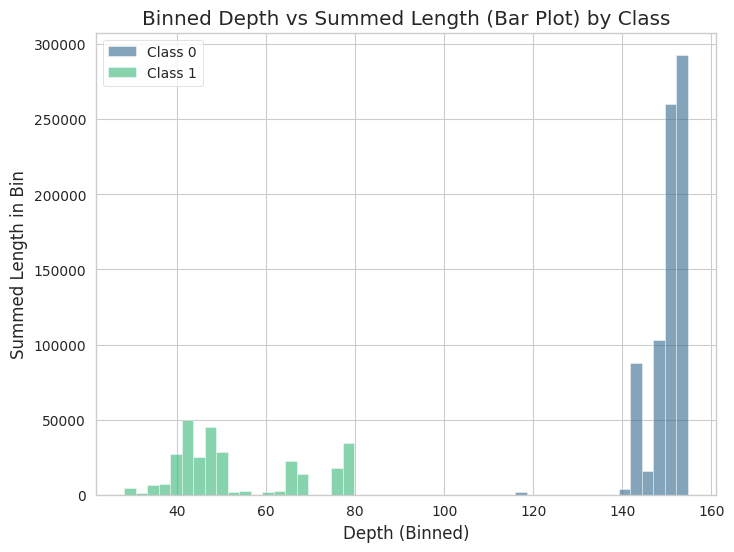

224 1 bacteria


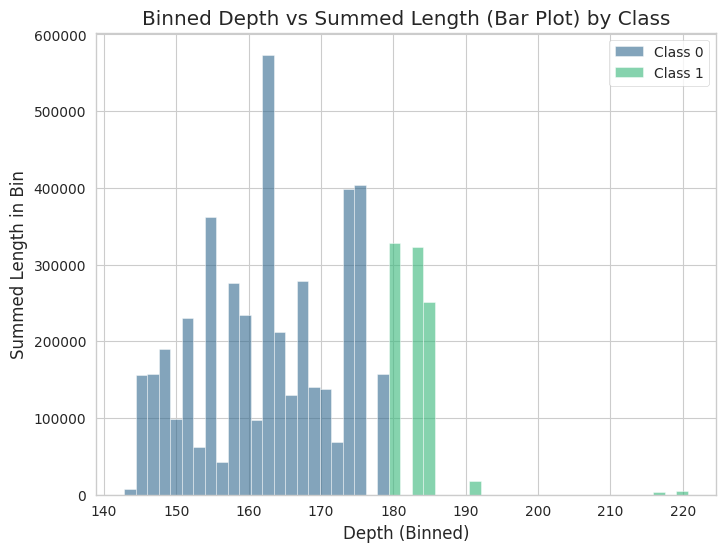

106 1 bacteria


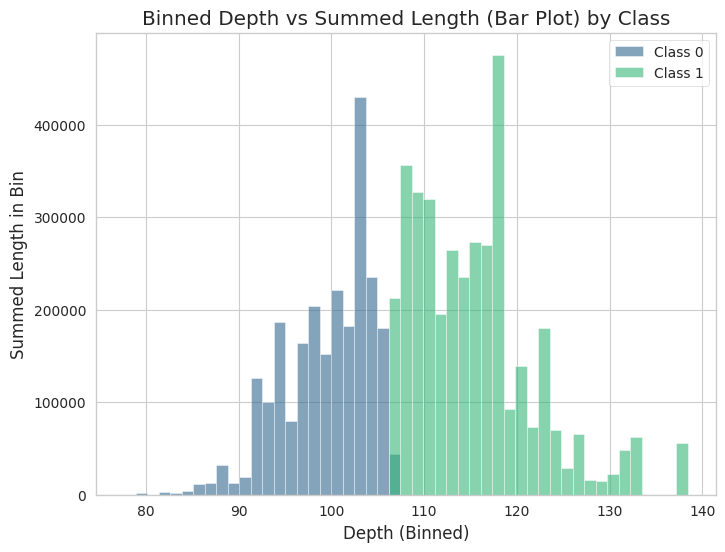

7 1 bacteria


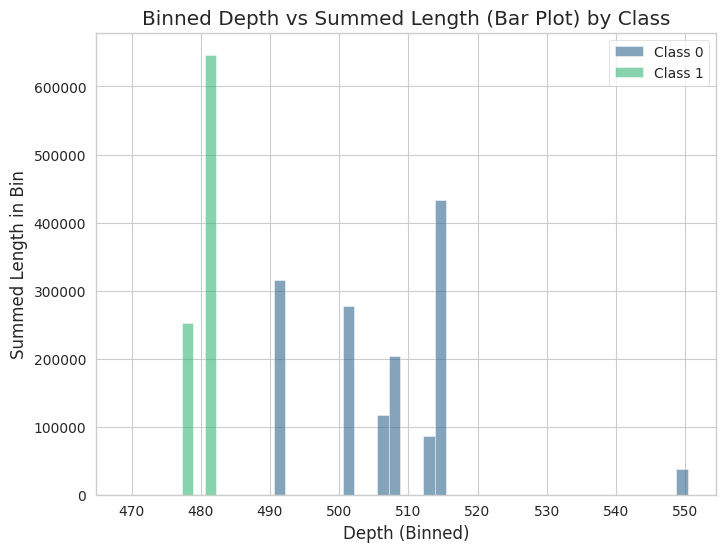

85 1 bacteria


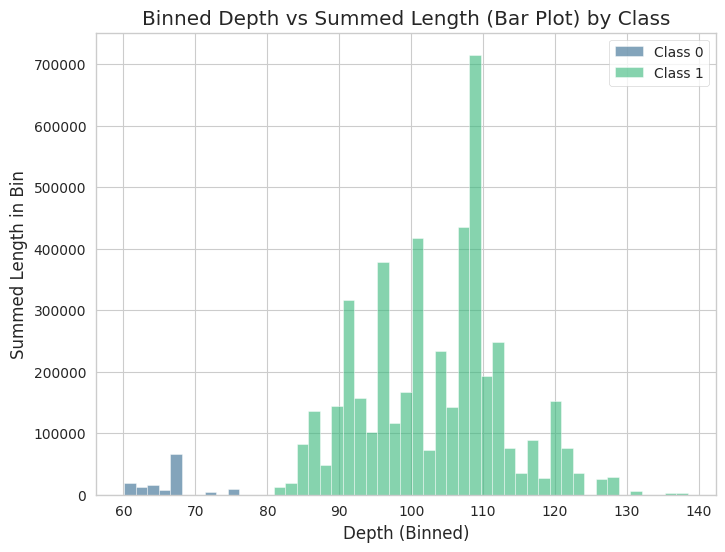

37 1 bacteria


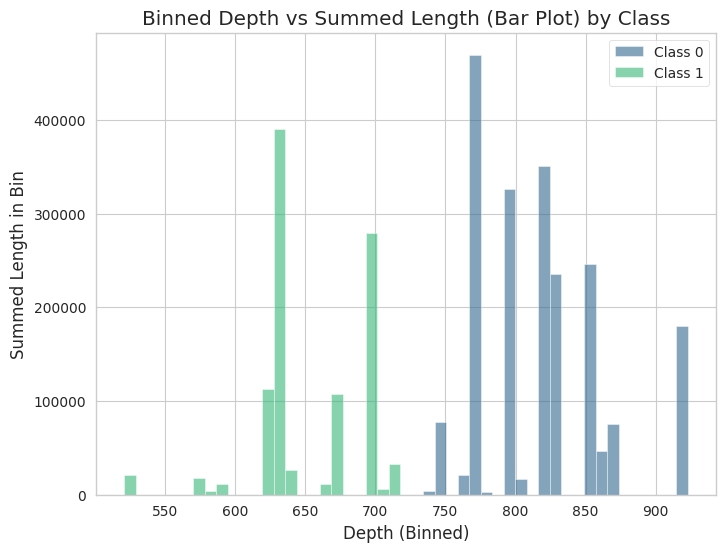

204 1 bacteria


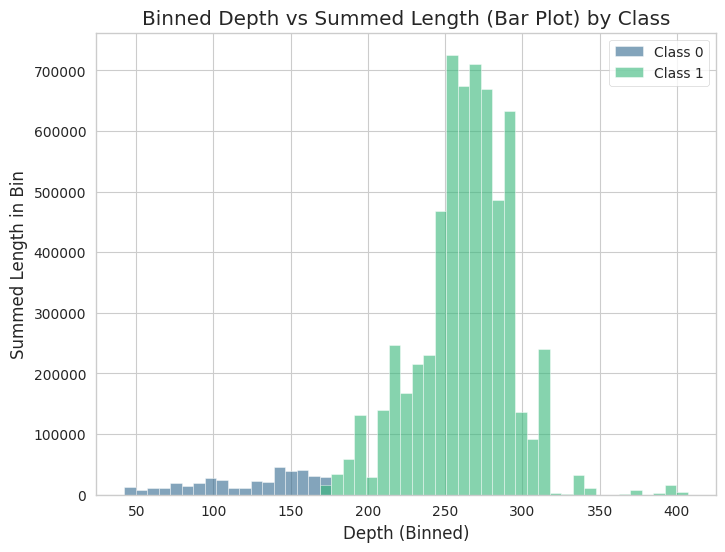

81 1 bacteria


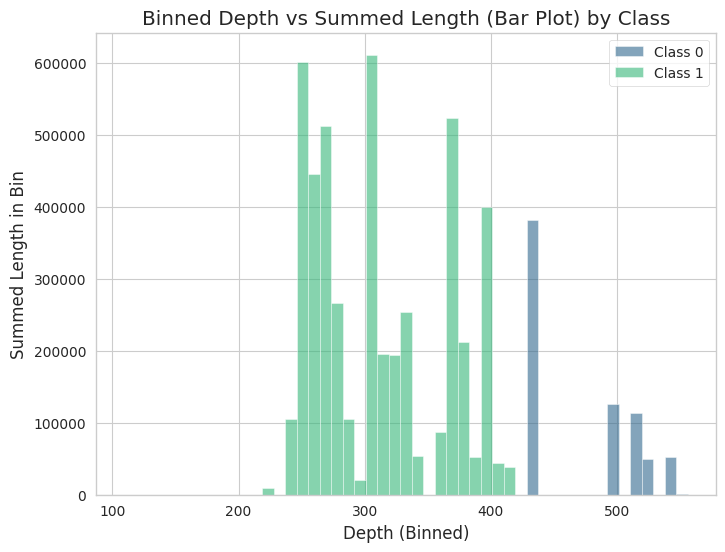

96 1 bacteria


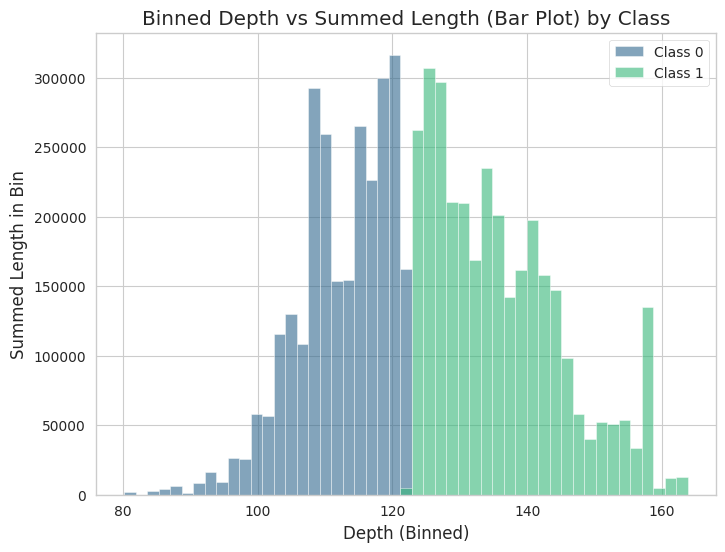

64 1 bacteria


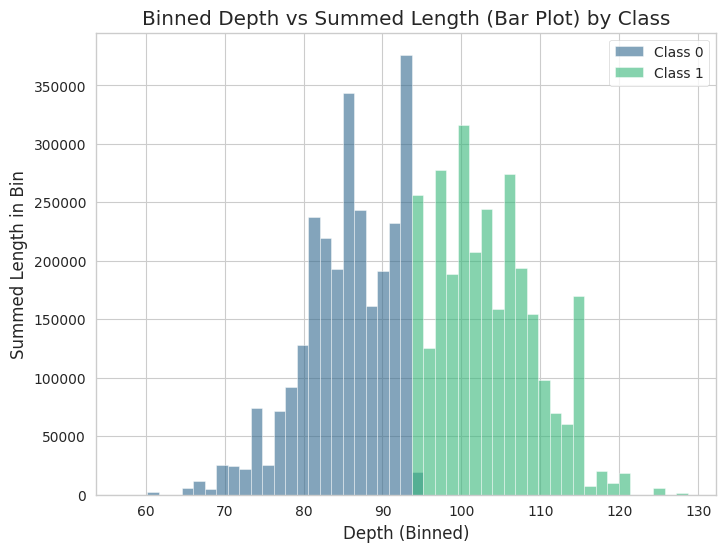

46 1 bacteria


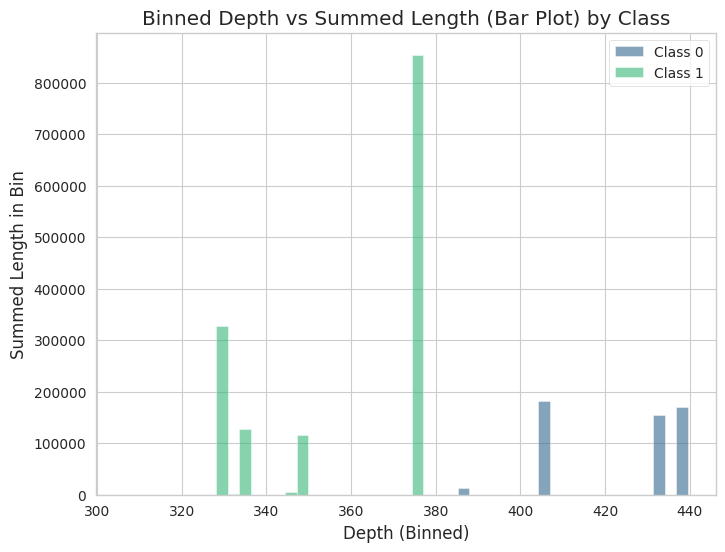

91 1 bacteria


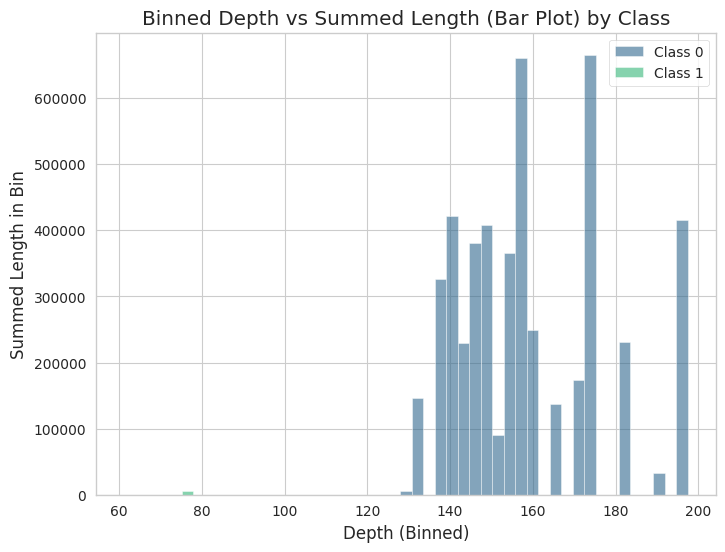

74 1 bacteria


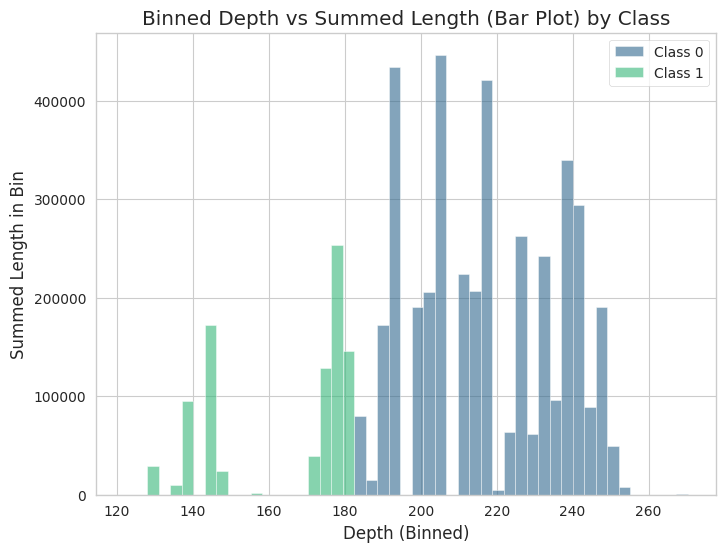

79 1 bacteria


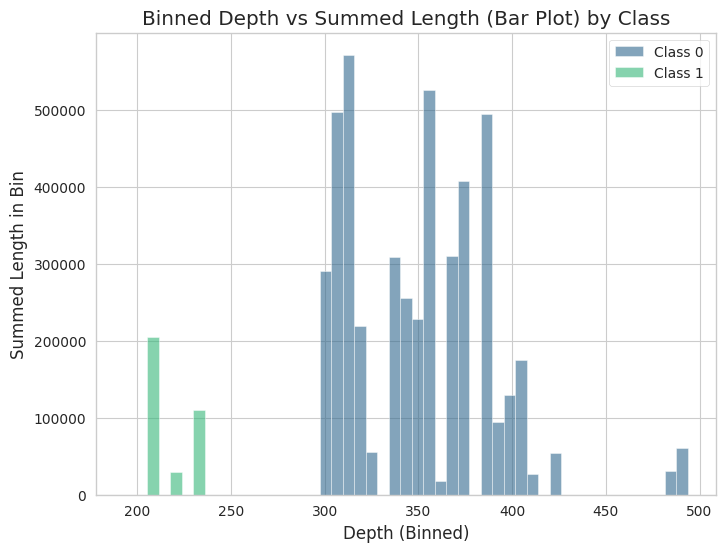

100 1 bacteria


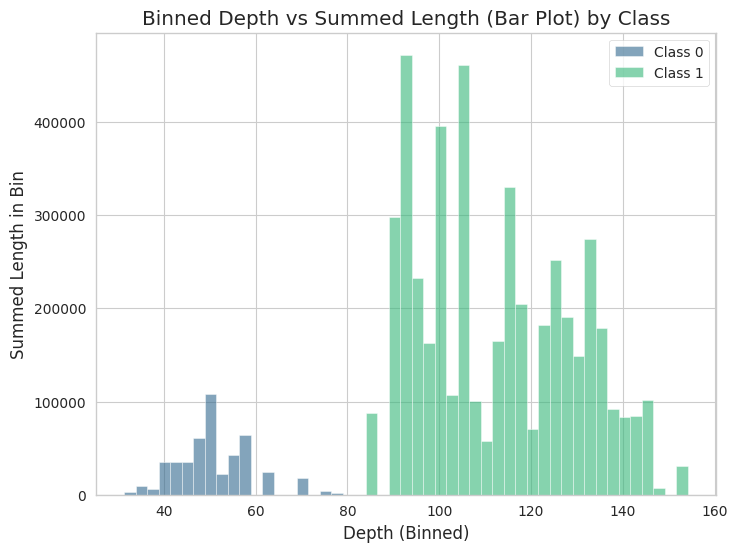

98 1 bacteria


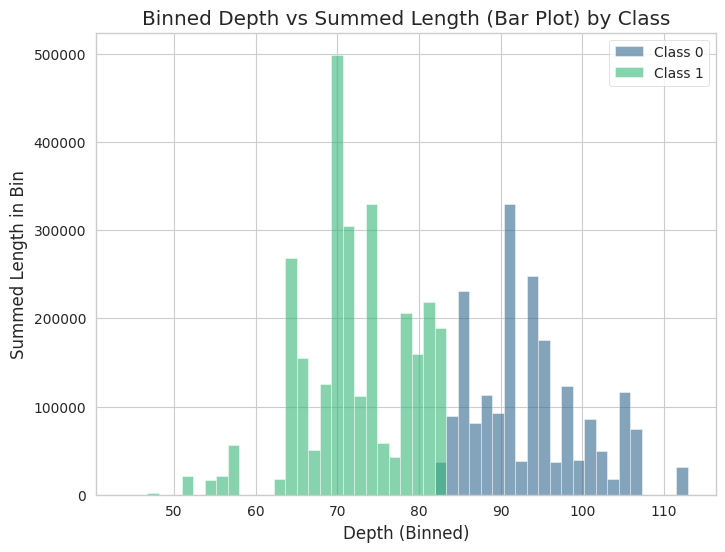

19 1 bacteria


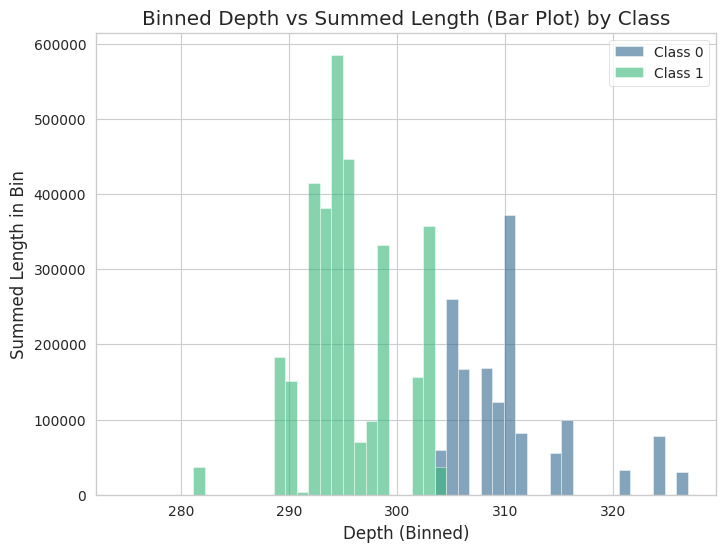

220 1 bacteria


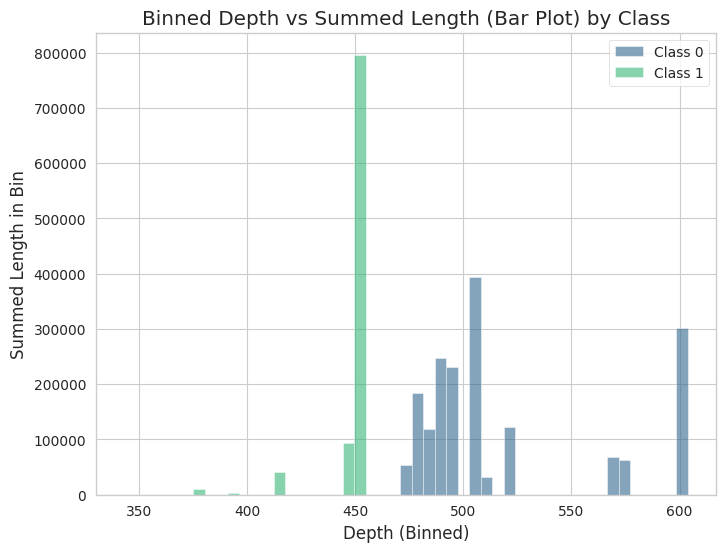

22 1 bacteria


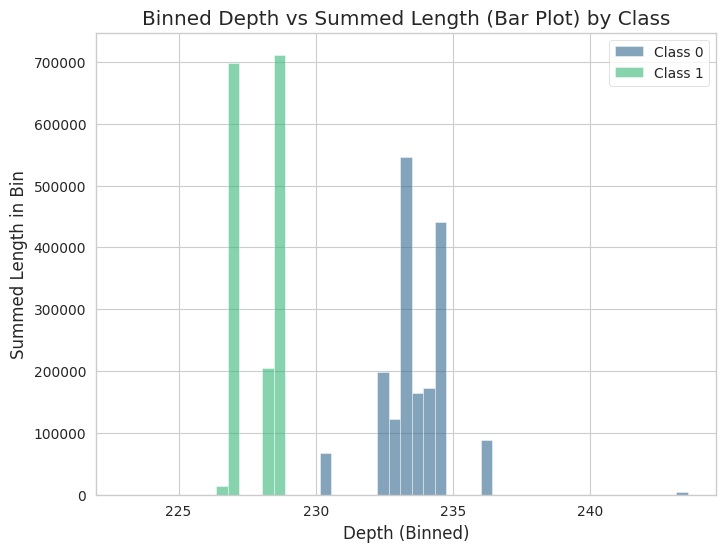

21 1 bacteria


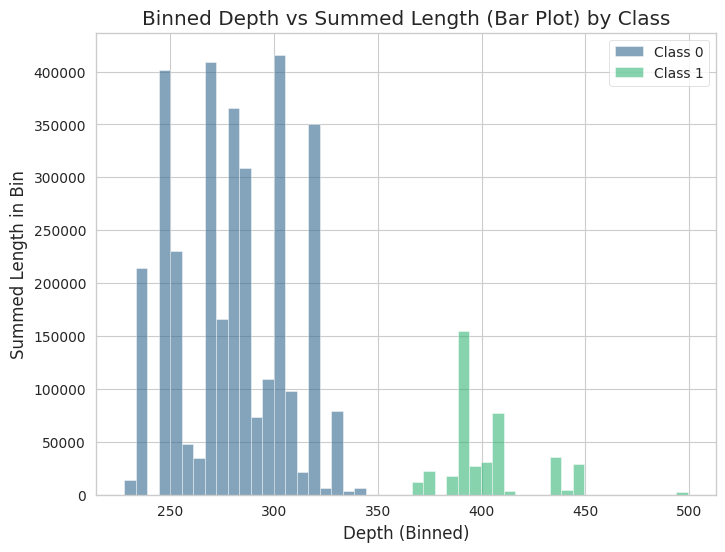

235 1 bacteria


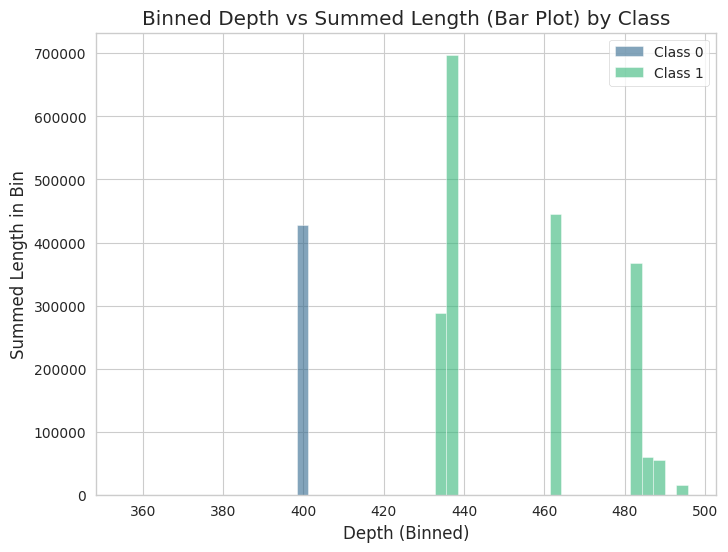

206 1 bacteria


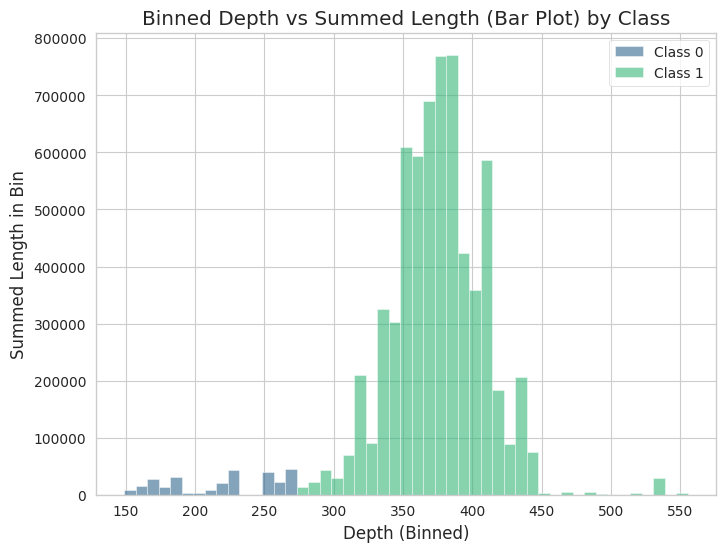

99 1 bacteria


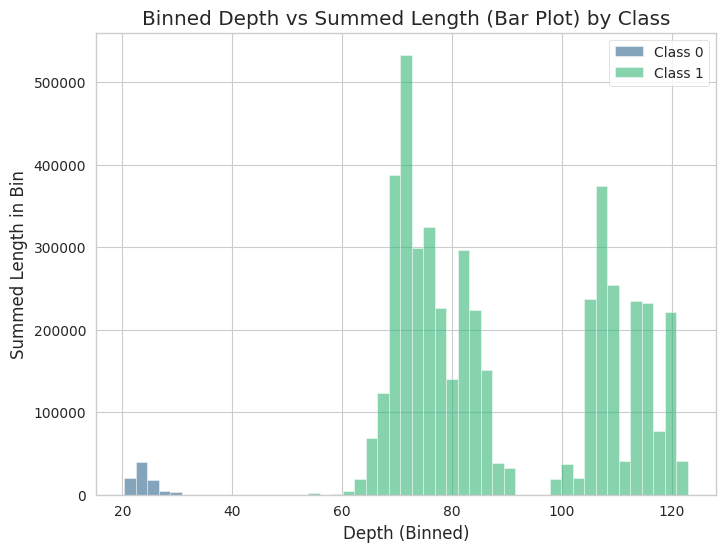

50 1 bacteria


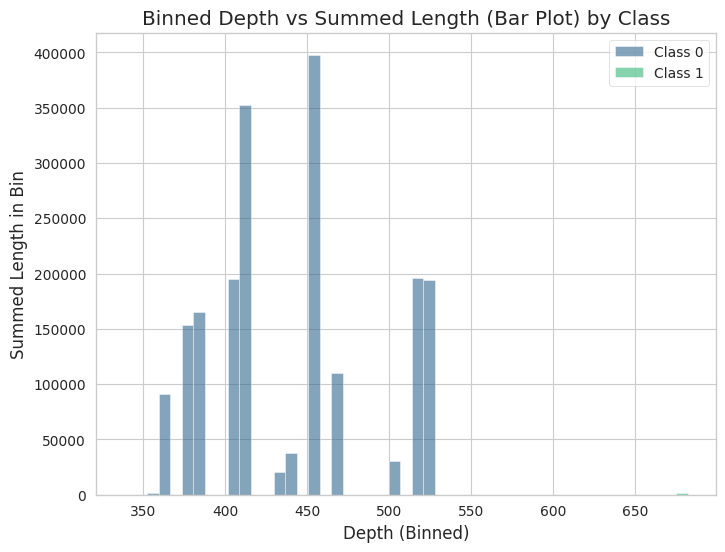

117 1 bacteria


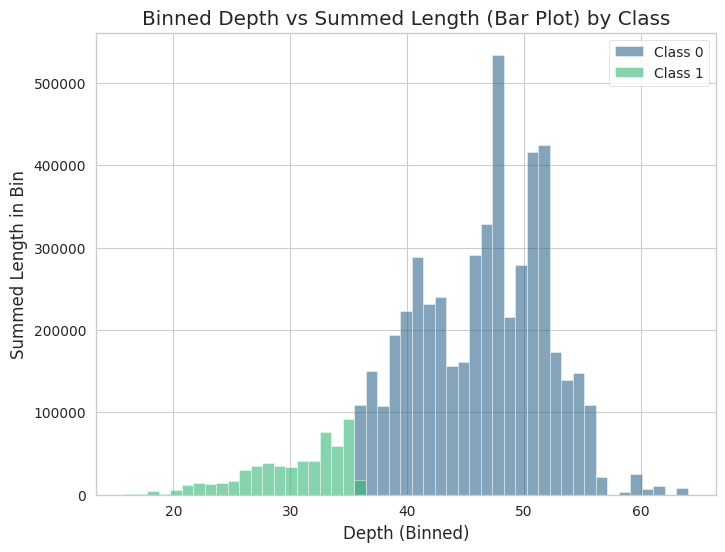

202 1 bacteria


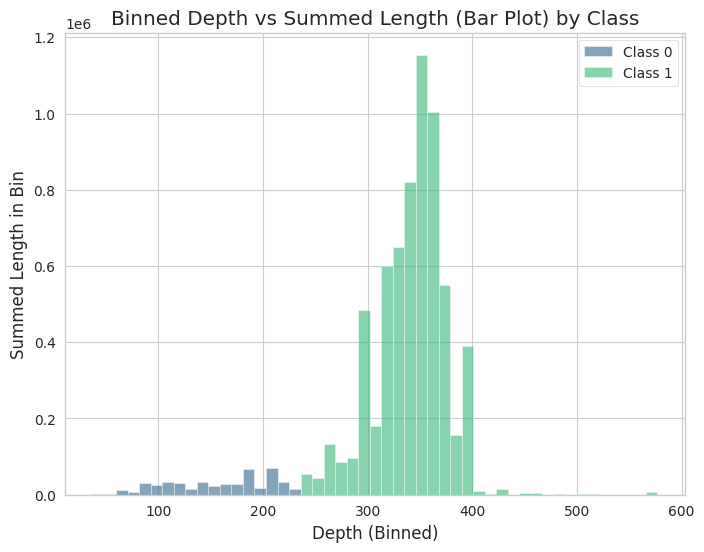

4 1 bacteria


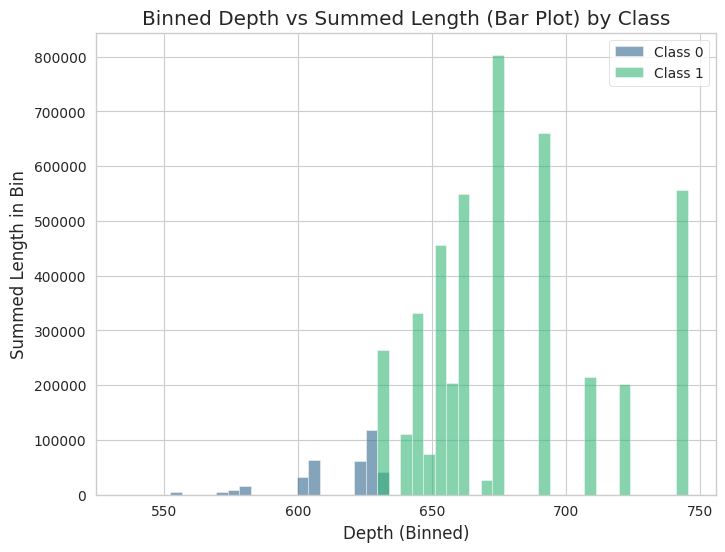

49 1 bacteria


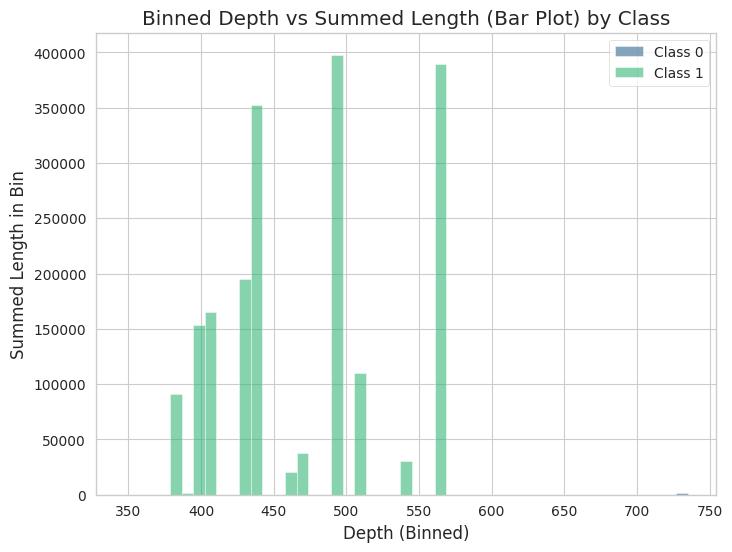

53 1 bacteria


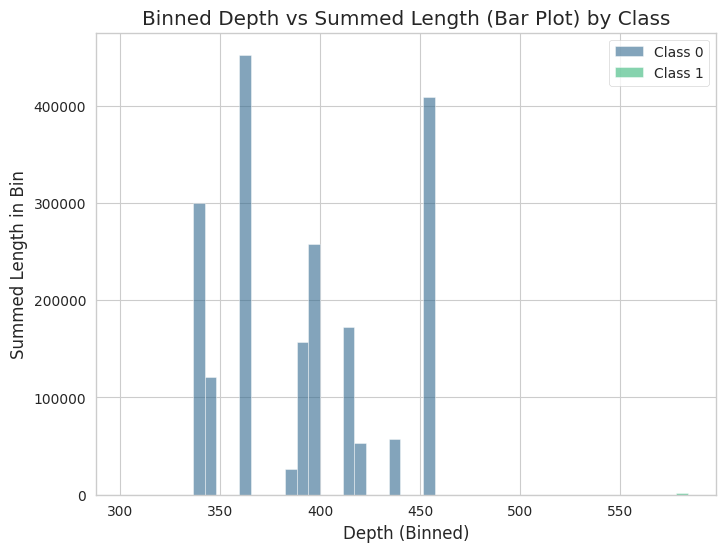

95 1 bacteria


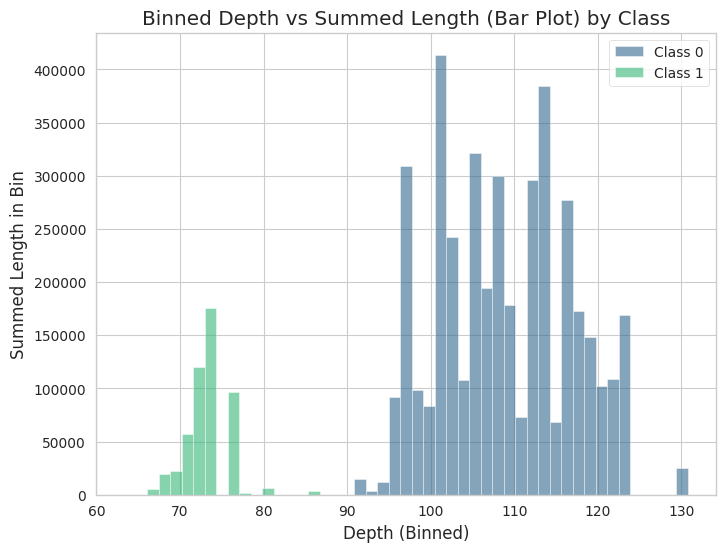

75 1 bacteria


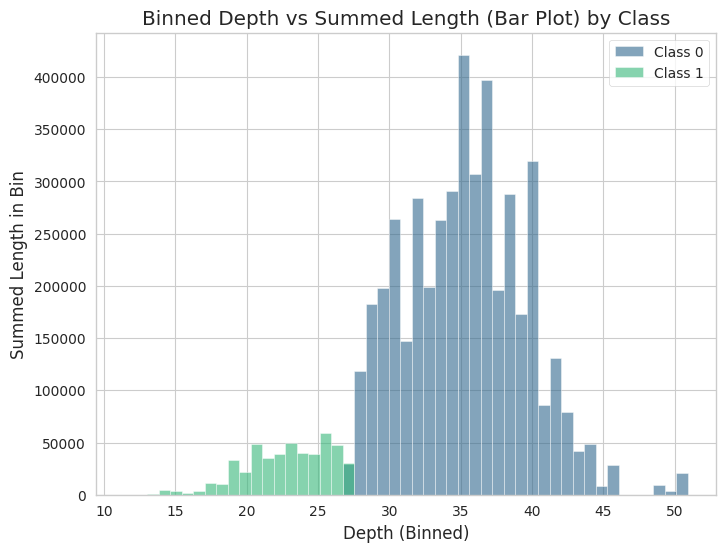

60 1 bacteria


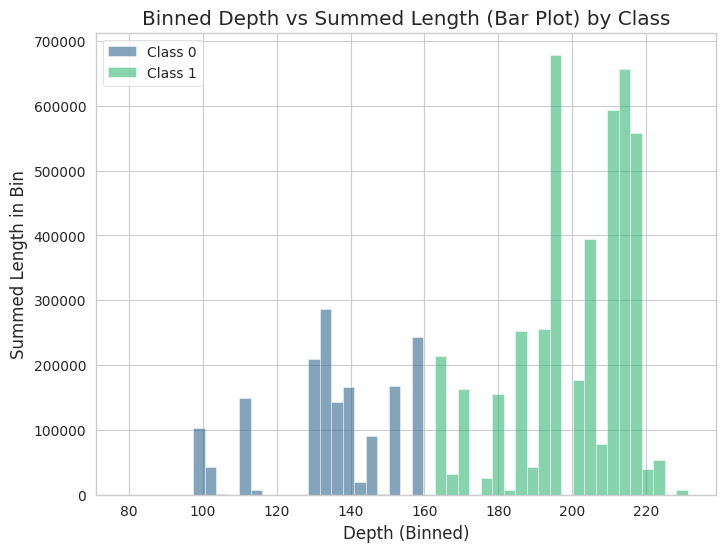

218 1 bacteria


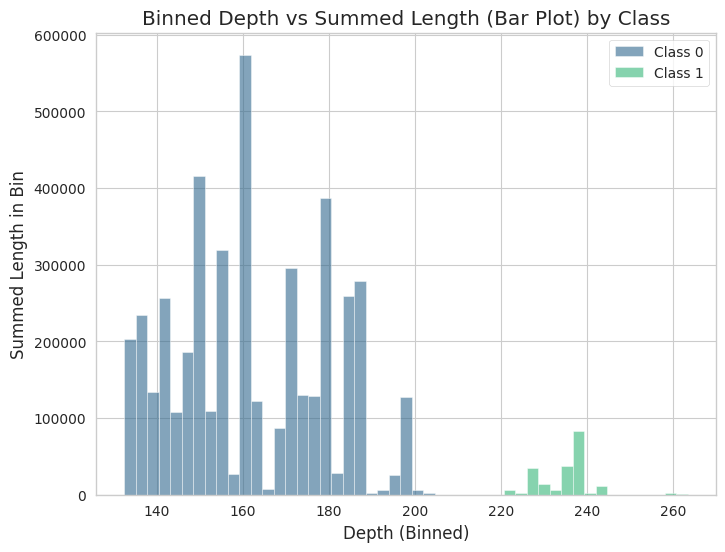

33 1 bacteria


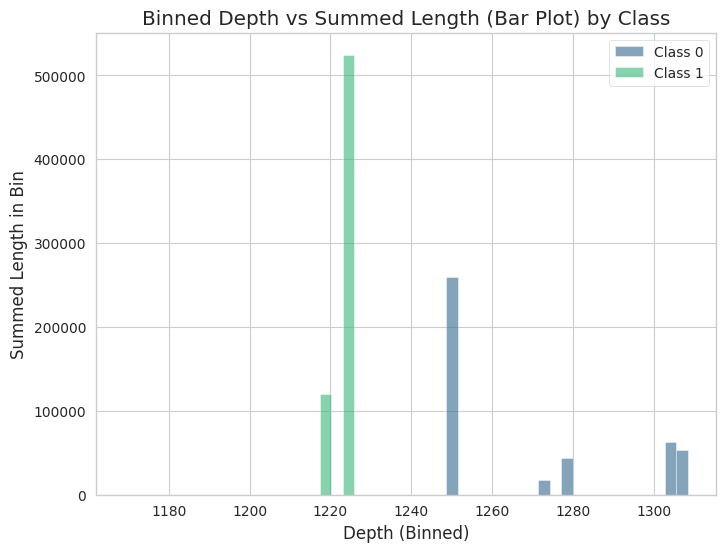

210 1 bacteria


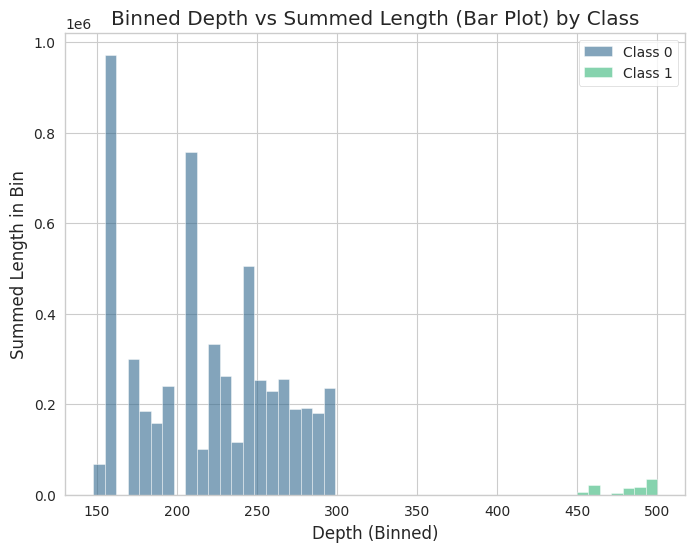

212 1 bacteria


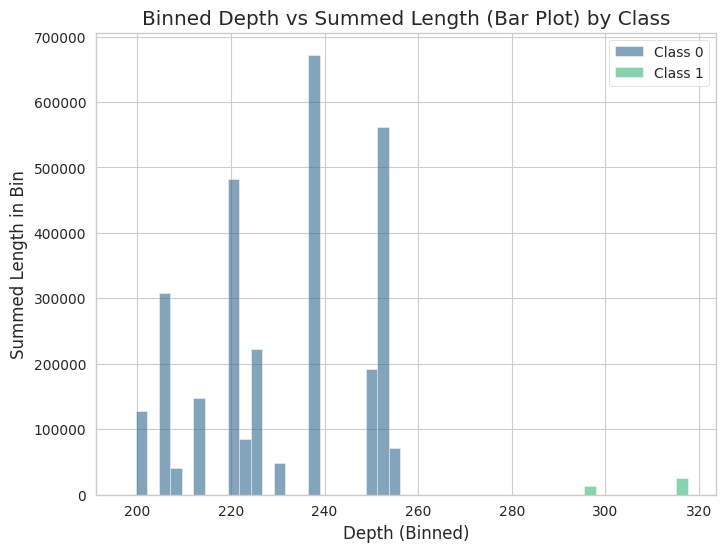

8 1 bacteria


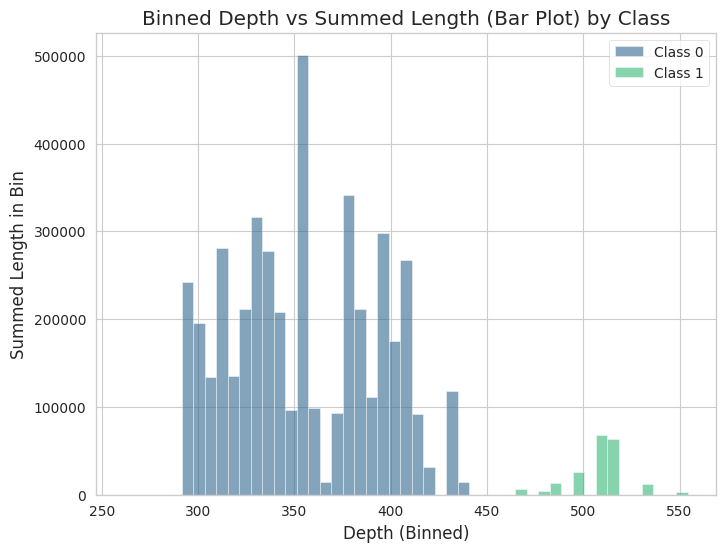

214 1 bacteria


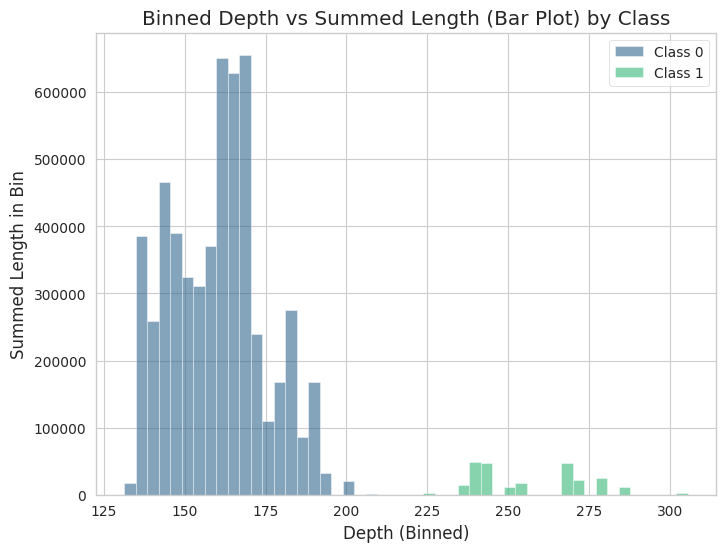

54 1 bacteria


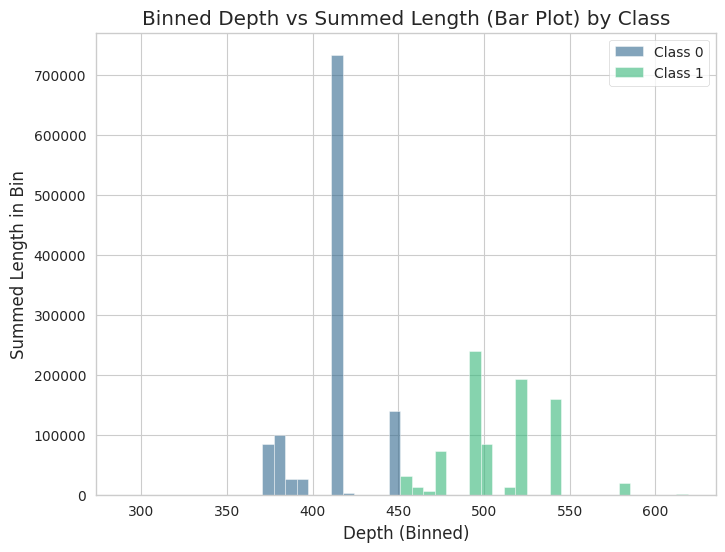

62 1 bacteria


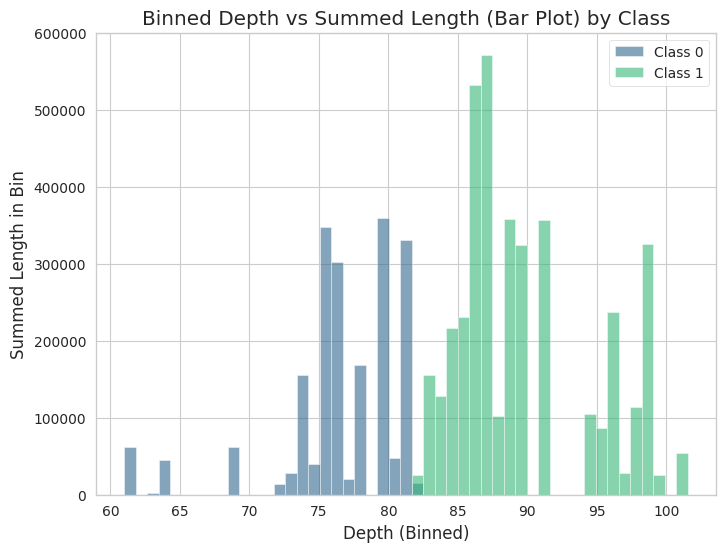

25 1 bacteria


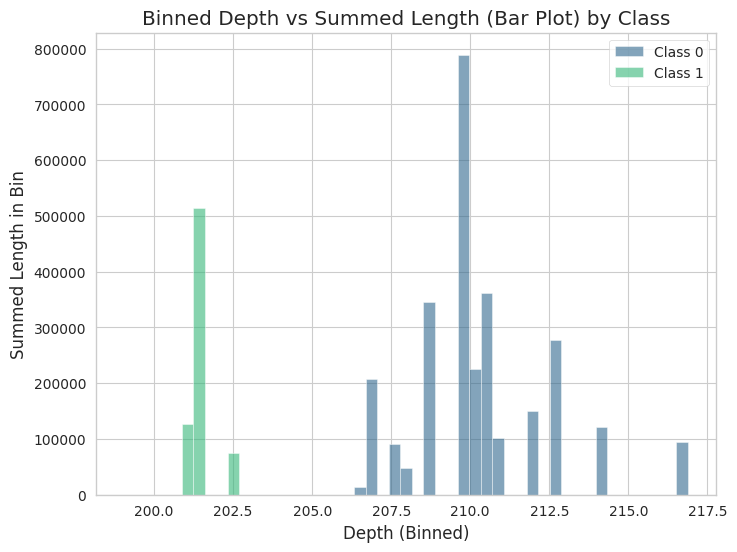

39 1 bacteria


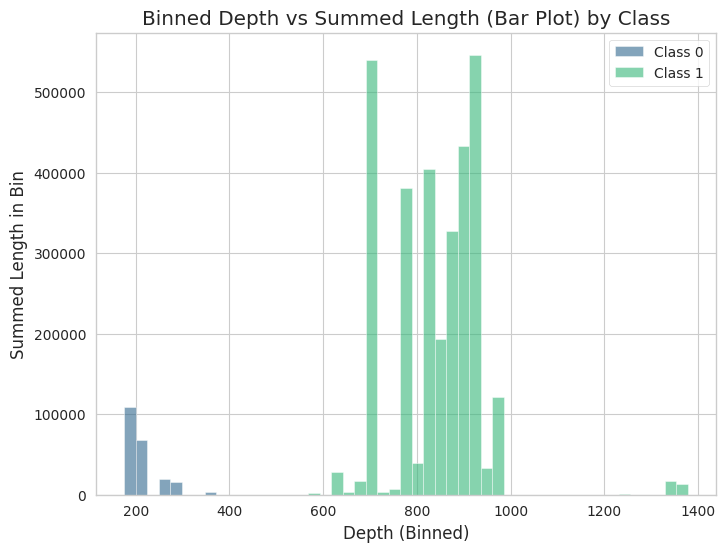

24 1 bacteria


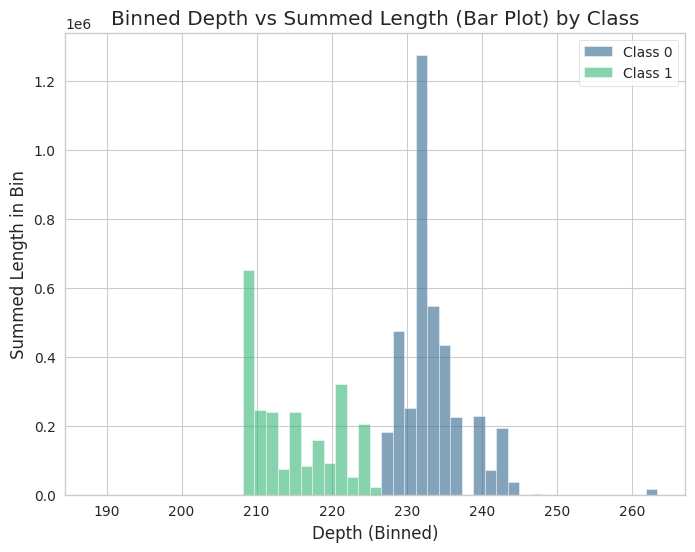

23 1 bacteria


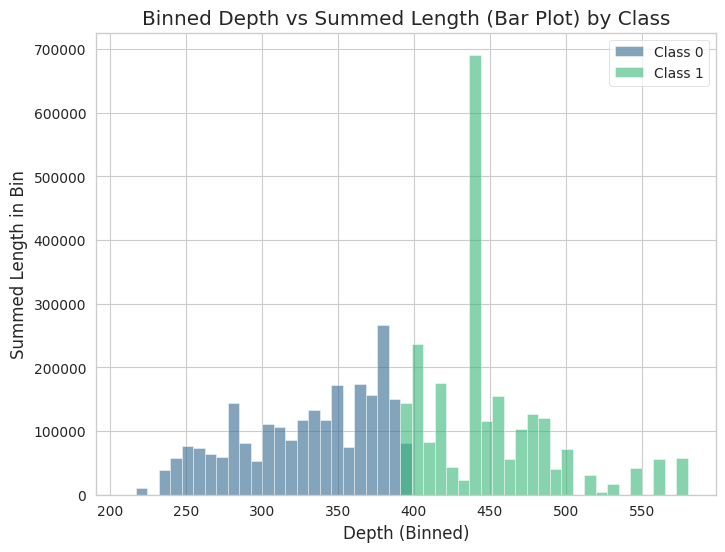

217 1 bacteria


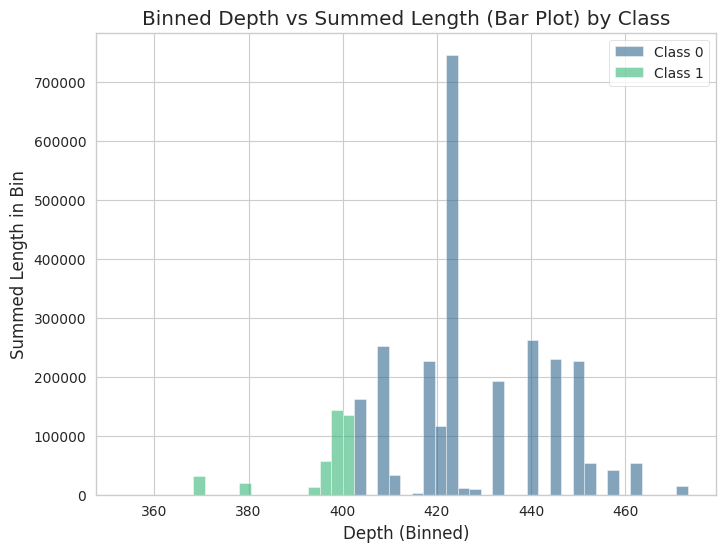

14 1 bacteria


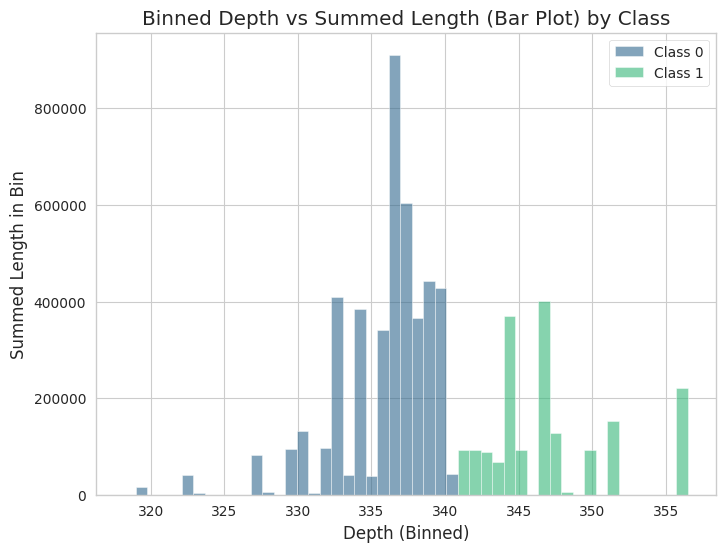

31 1 bacteria


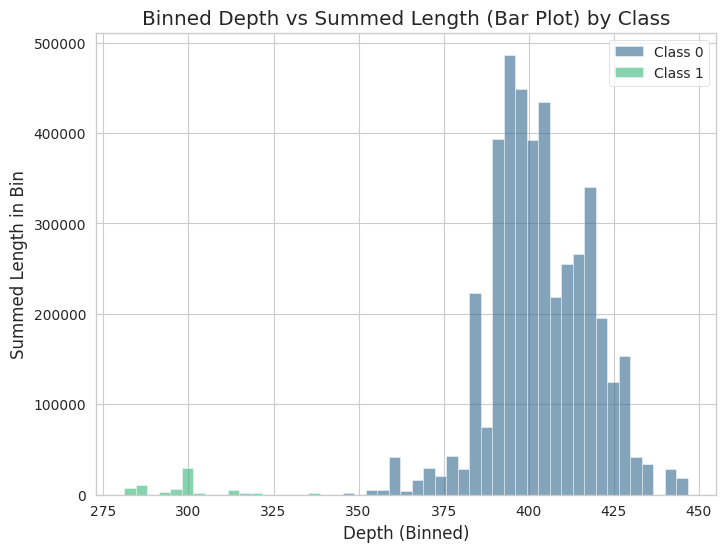

16 1 bacteria


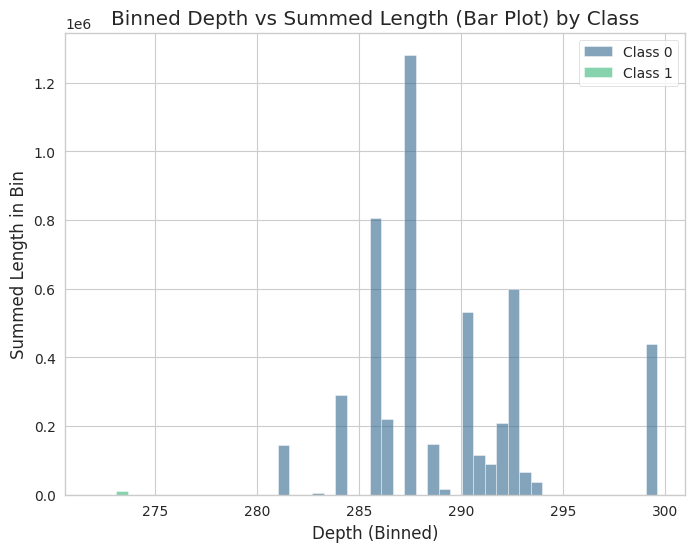

83 1 bacteria


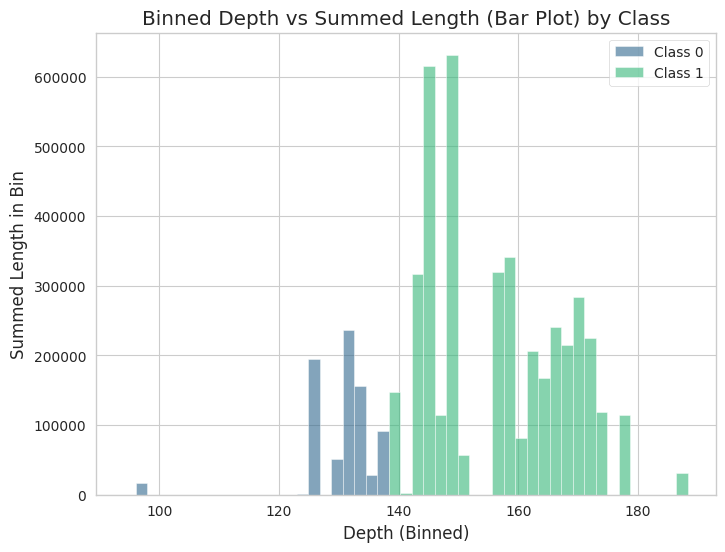

17 1 bacteria


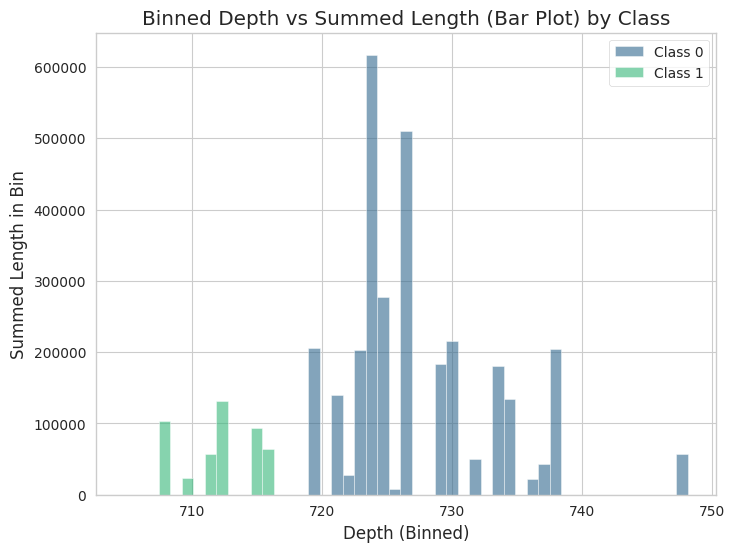

113 1 bacteria


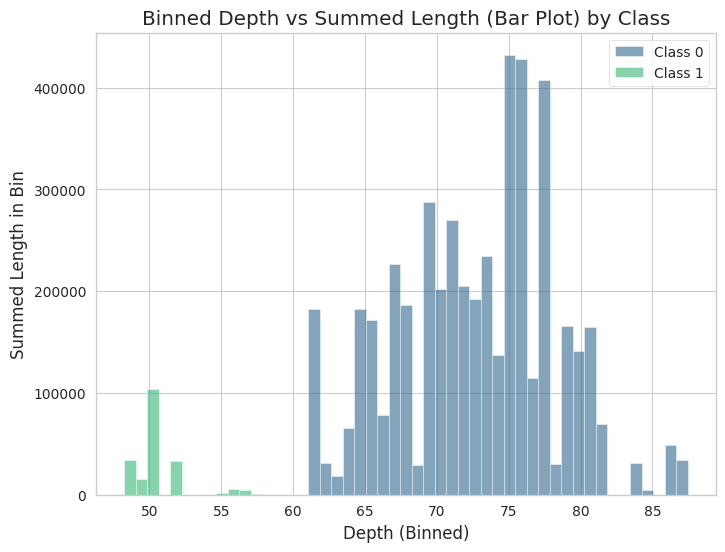

13 1 bacteria


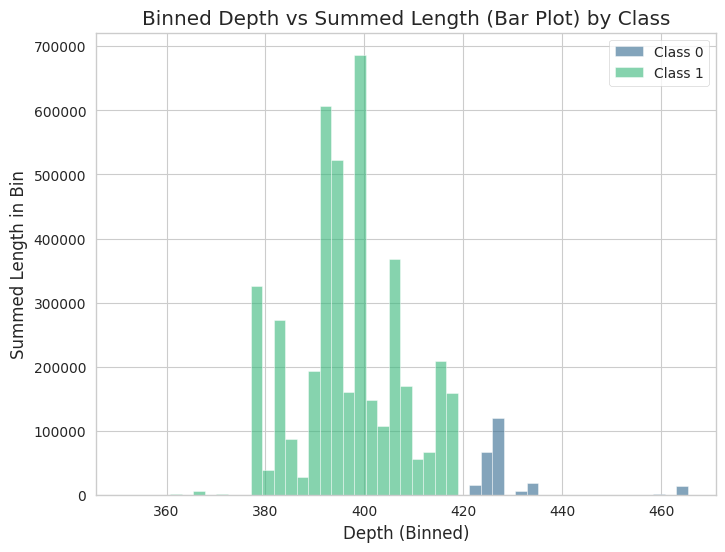

18 1 bacteria


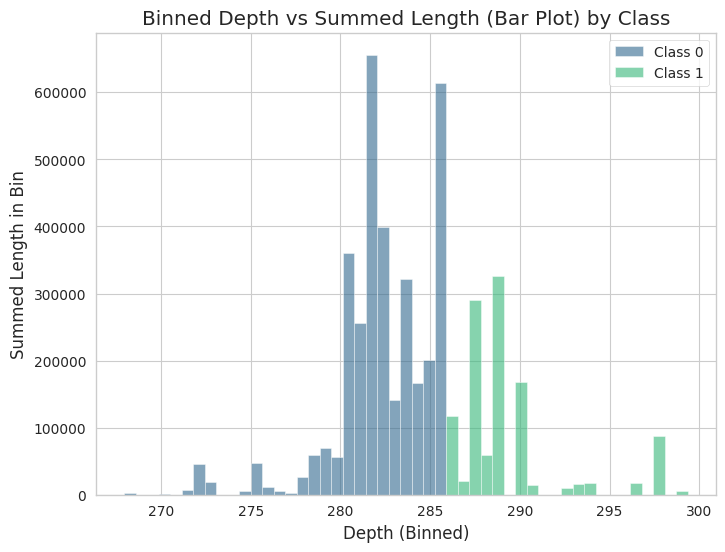

56 1 bacteria


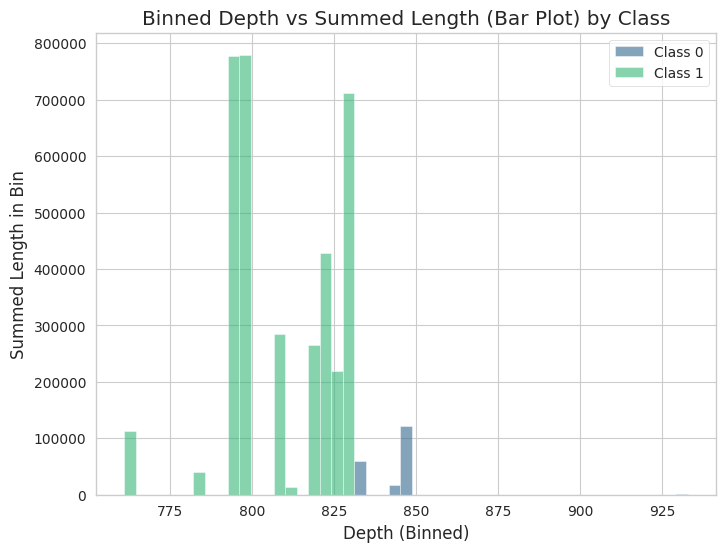

219 1 bacteria


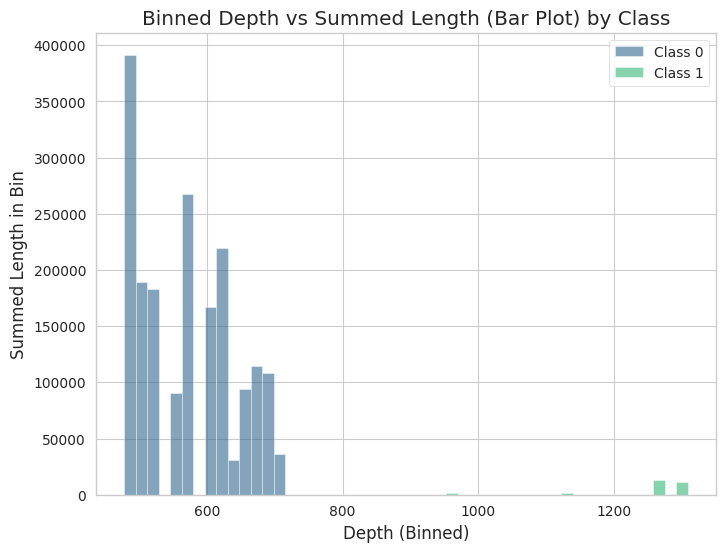

29 1 bacteria


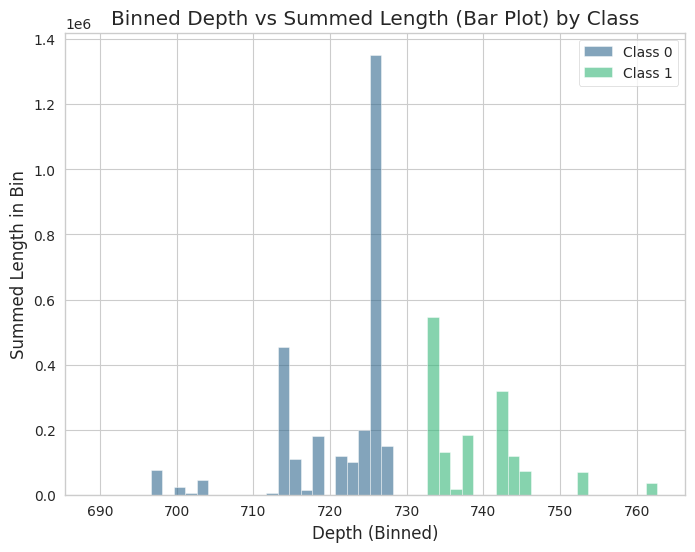

58 1 bacteria


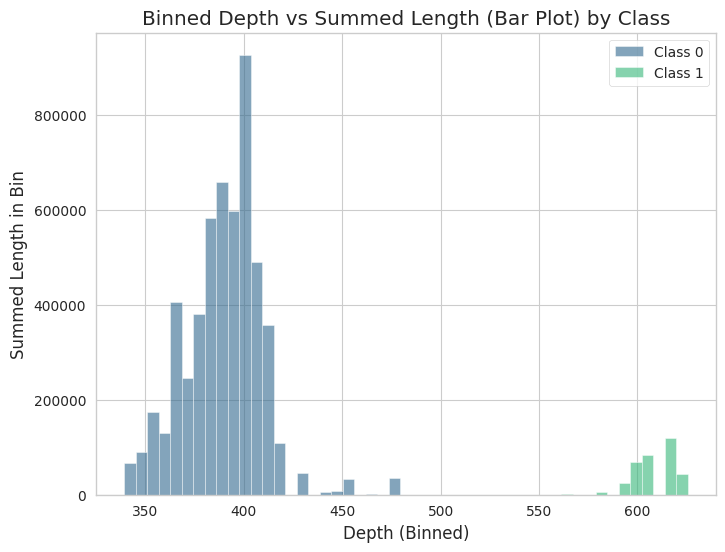

101 1 bacteria


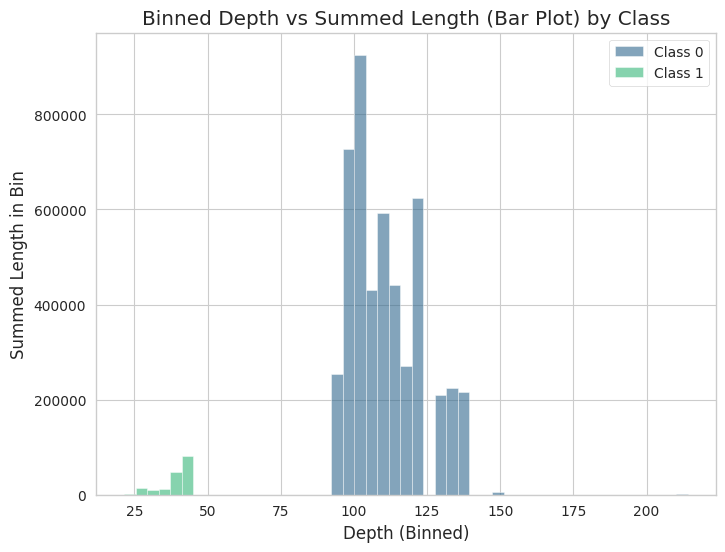

203 1 bacteria


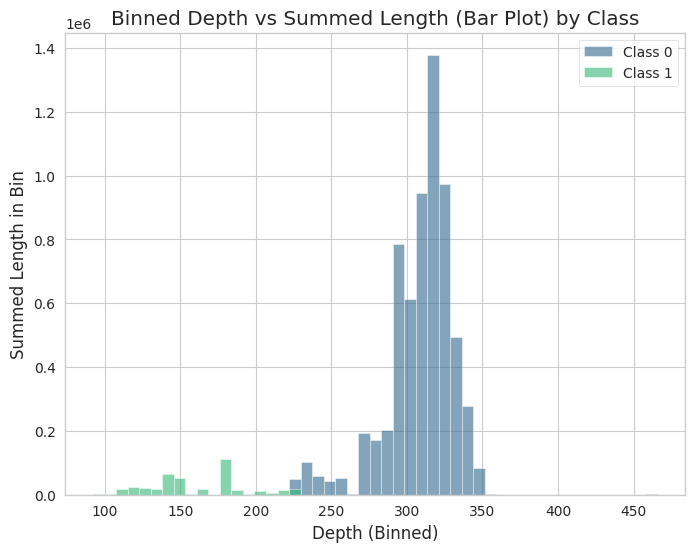

61 1 bacteria


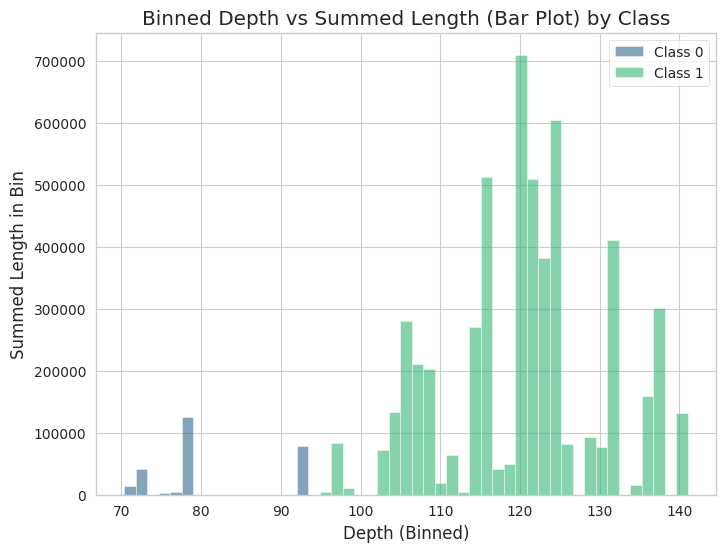

41 1 bacteria


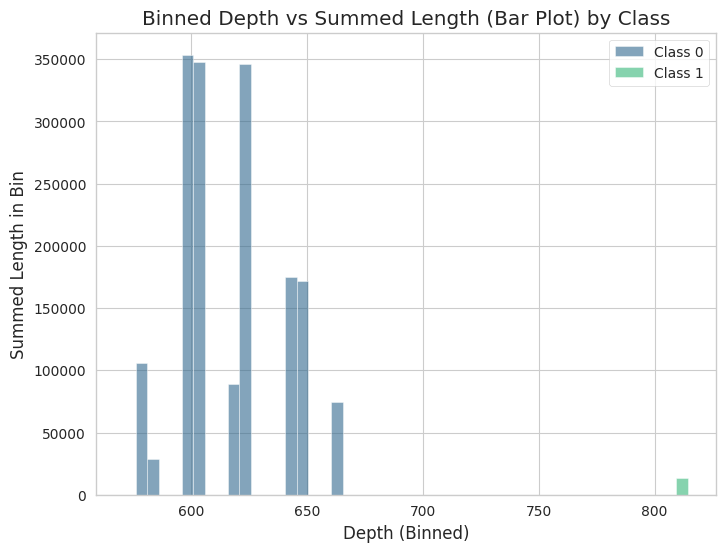

28 1 bacteria


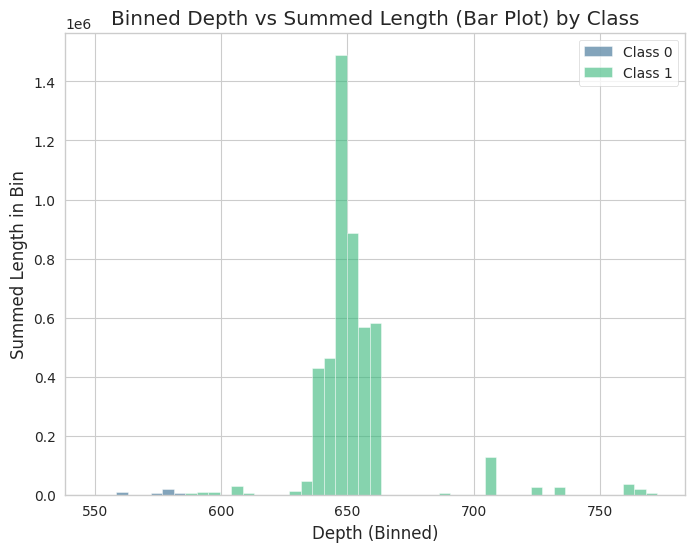

70 1 bacteria


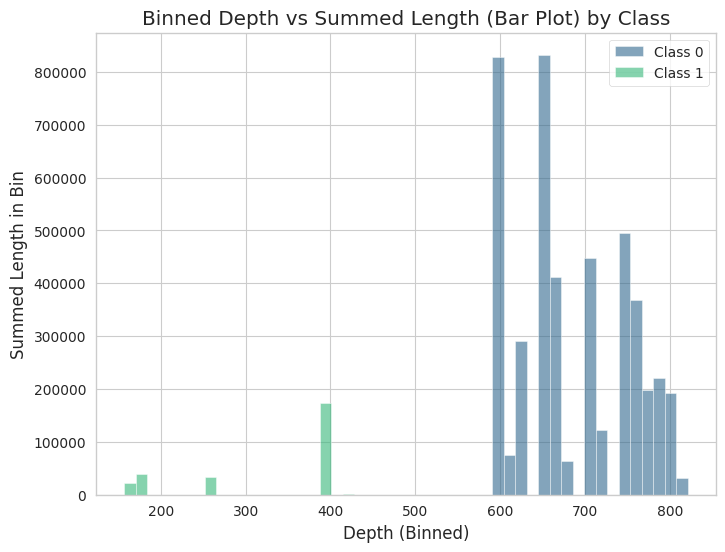

15 1 bacteria


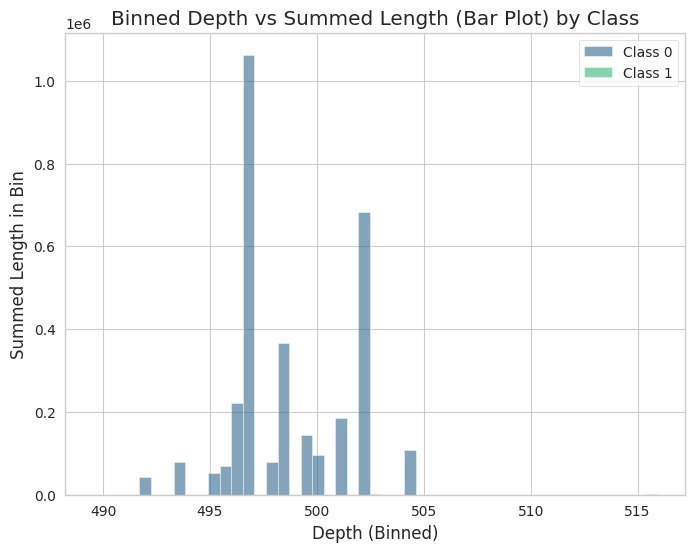

107 1 bacteria


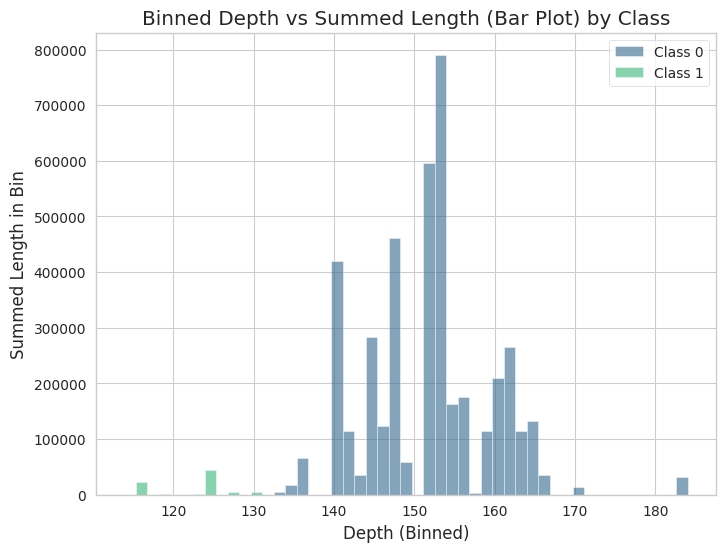

207 1 bacteria


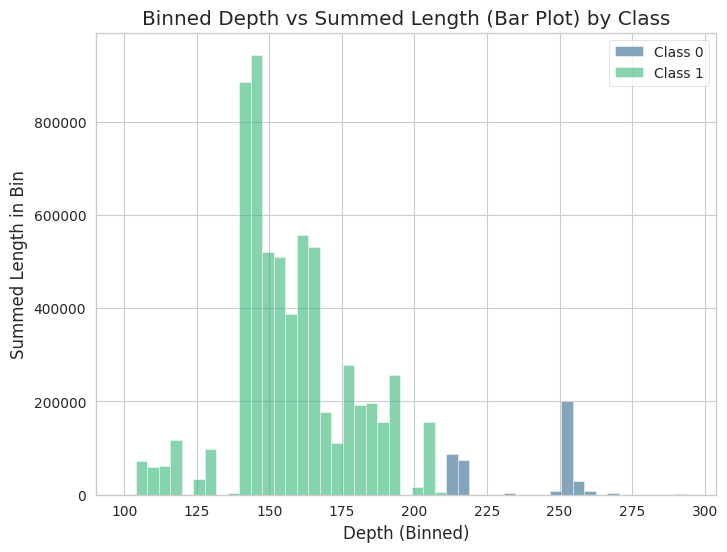

209 1 bacteria


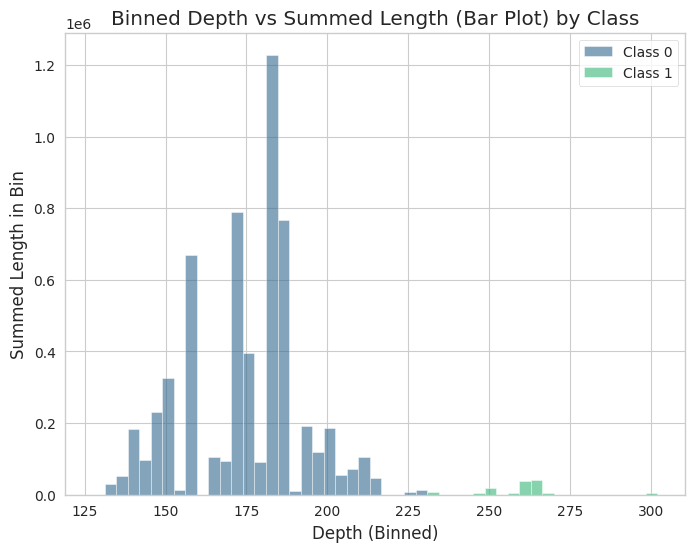

89 1 bacteria


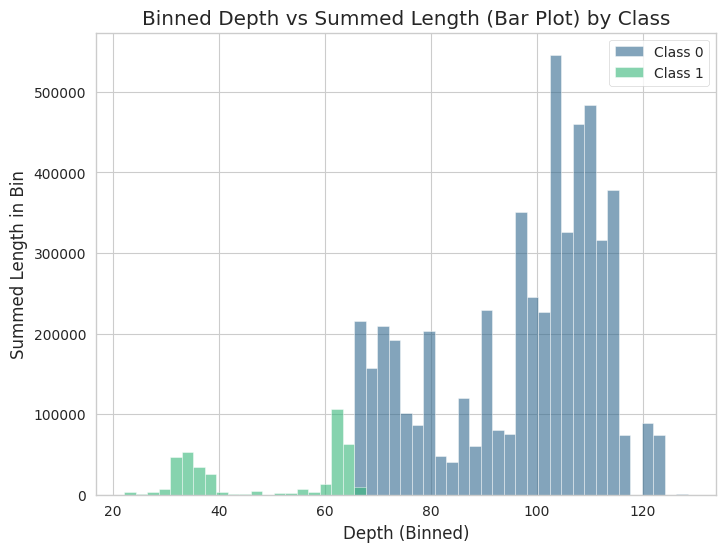

229 1 bacteria


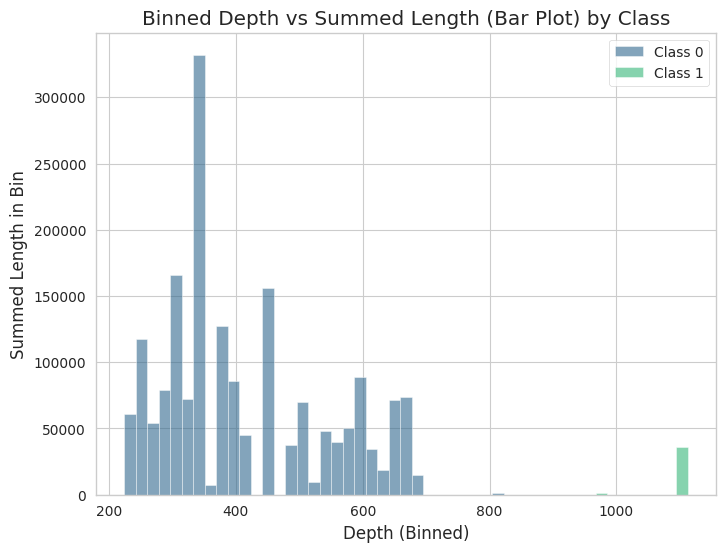

20 1 bacteria


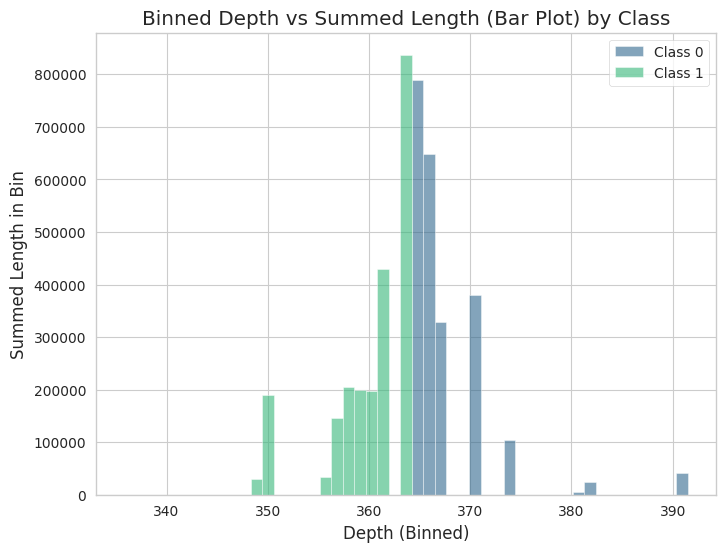

205 1 bacteria


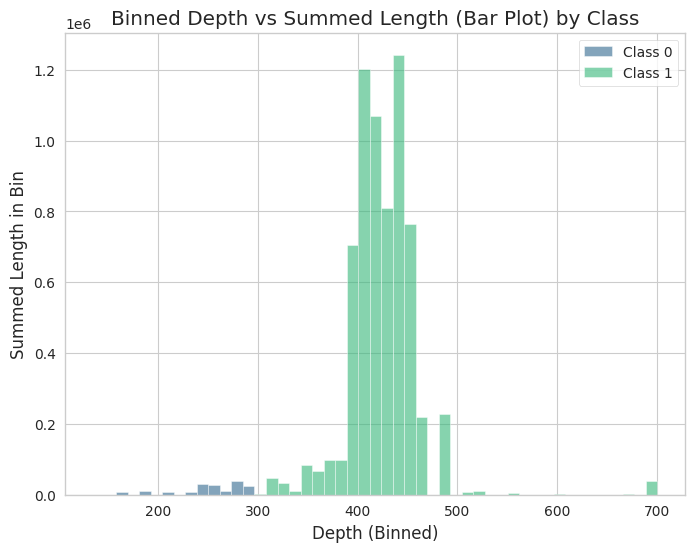

226 1 bacteria


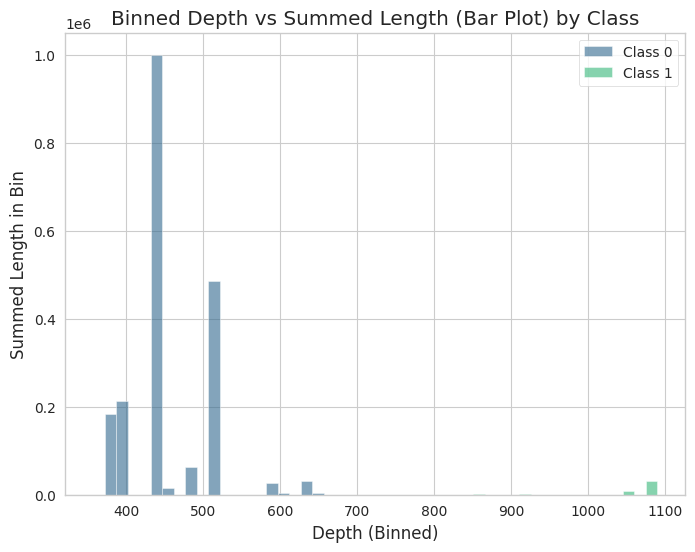

234 1 bacteria


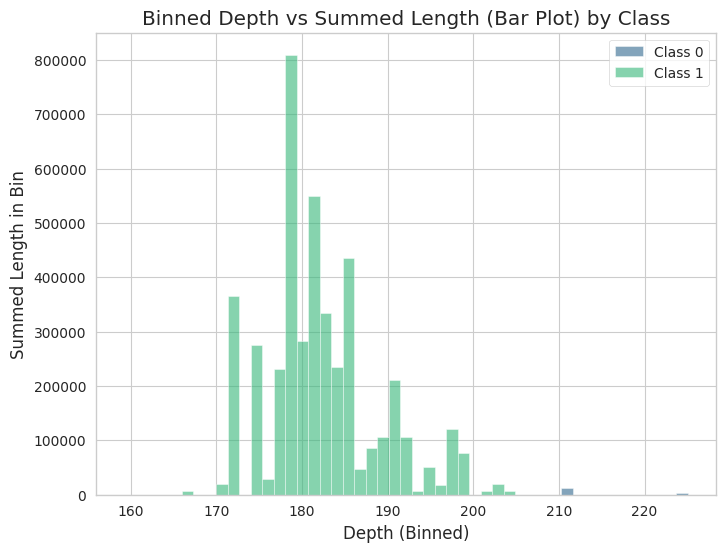

32 1 bacteria


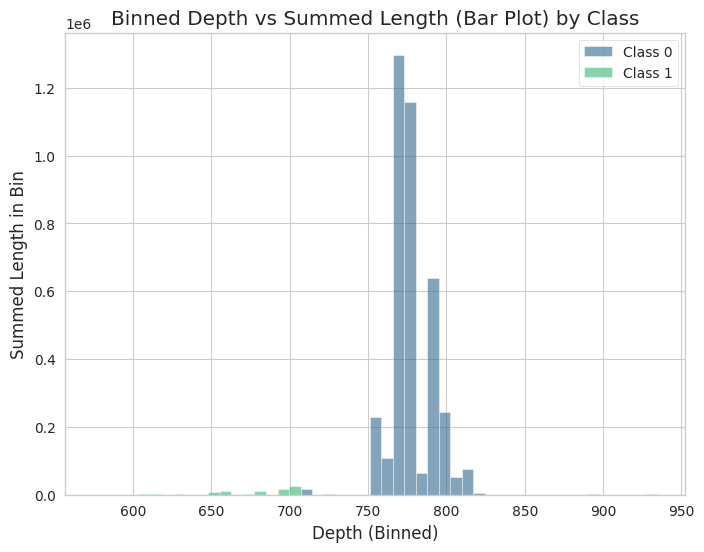

87 1 bacteria


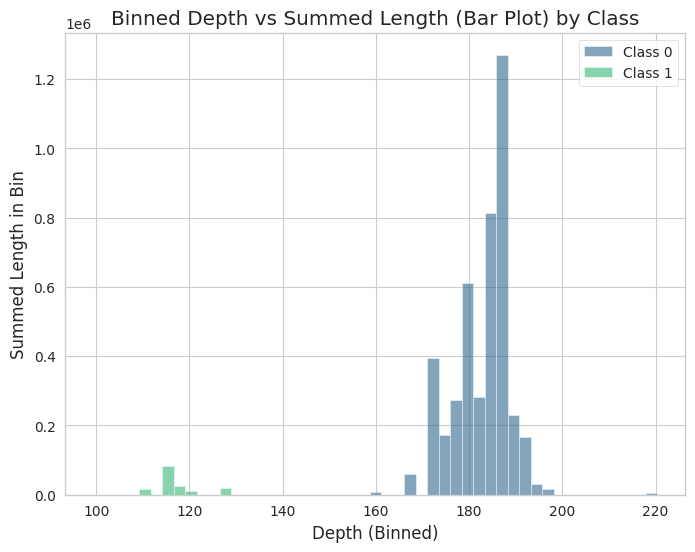

In [29]:
indexes = cdf.index
for i in indexes:
  if i >= 119:
    processing = process_genomic_data(f"/content/LengthDepth_{i-118}.csv", False)
    print(i-118+200, cdf.loc[i, 'clasificacion'])
  else:
    print(i, cdf.loc[i, 'clasificacion'])
    processing = process_genomic_data(f"/content/experiment_{i}_stats.csv", False)

  df = processing[0]
  dfg = mezcla_de_gaussianas(df,2, False)
  dfa = acumular_longitudes(dfg,50, True)


Observemos las gráficas del contendio de GC para algunos experimentos:

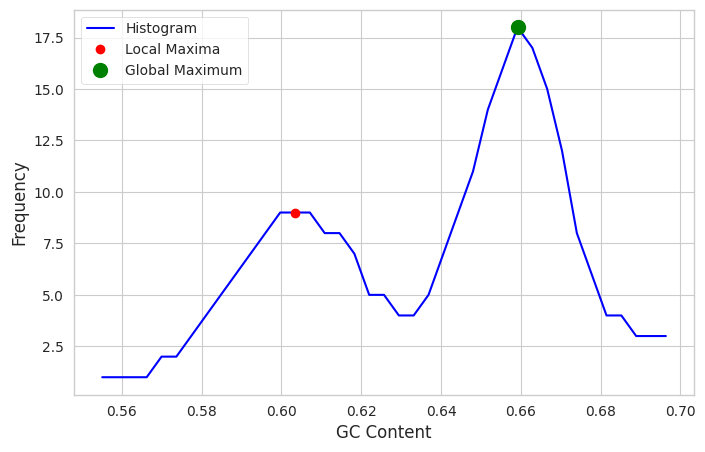

2

In [30]:
processing33 = process_genomic_data(f"/content/LengthDepth_16.csv", False)
df = processing33[0]
GC_peaks(df, True)

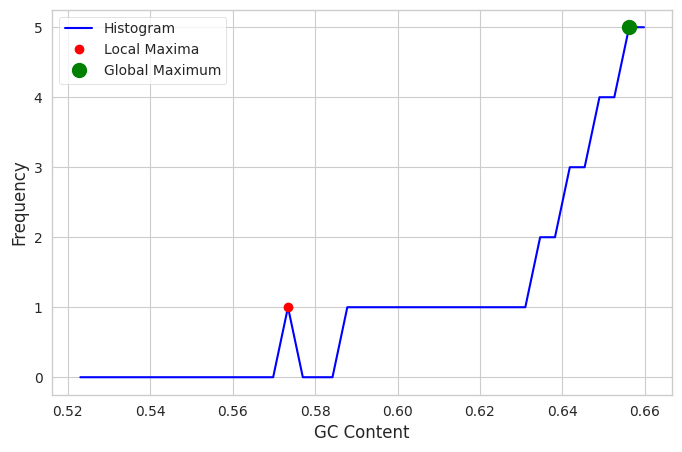

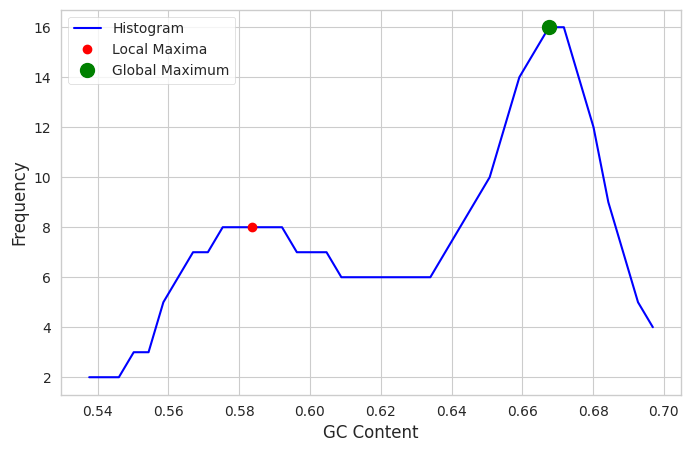

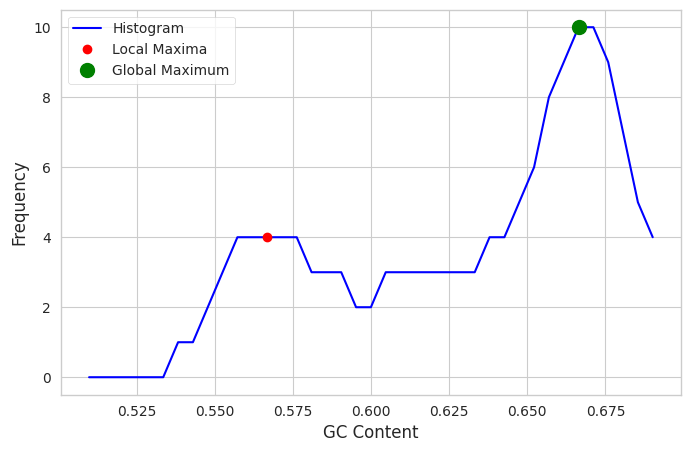

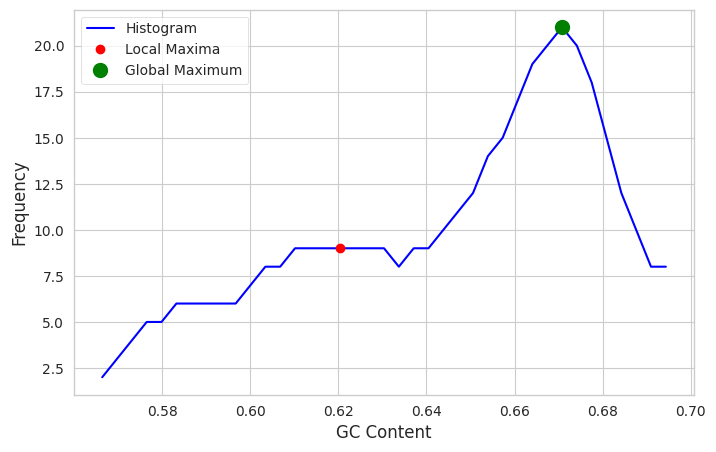

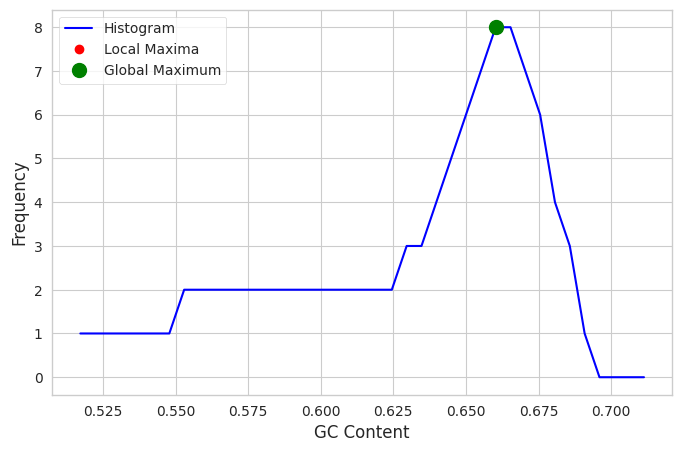

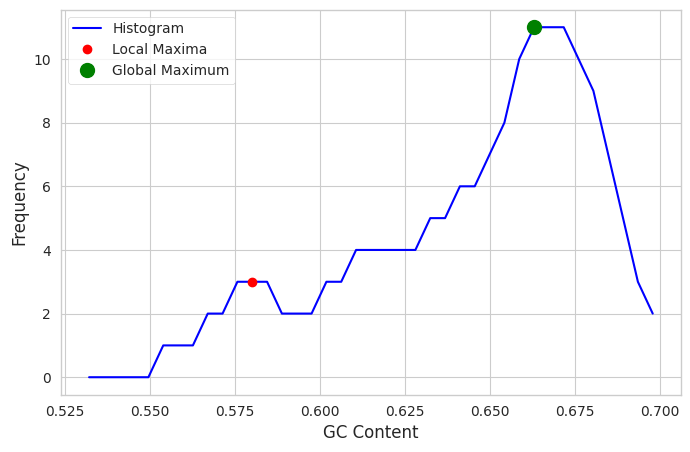

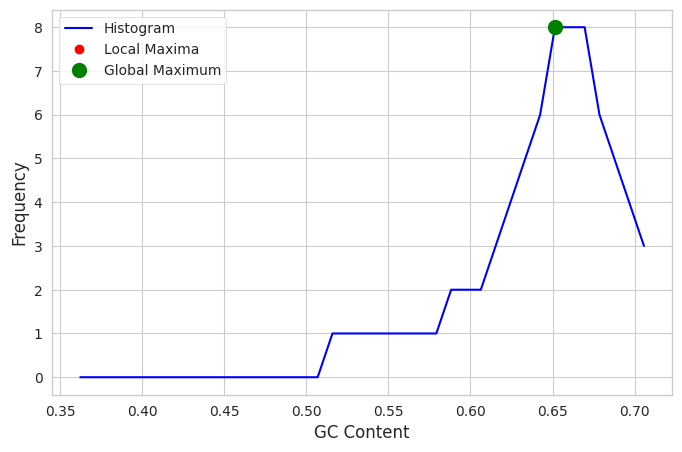

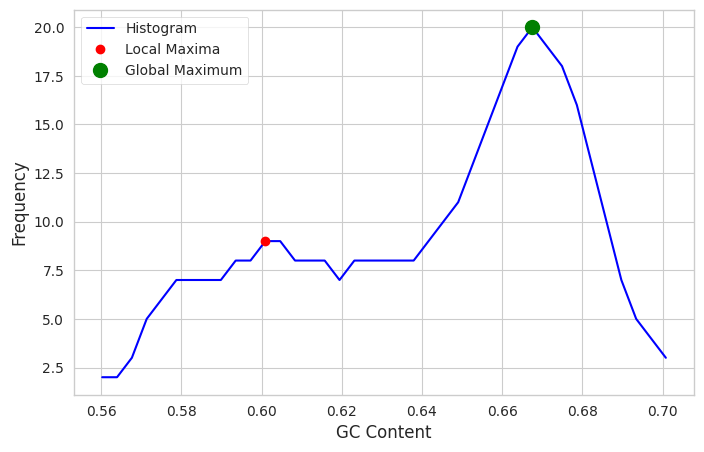

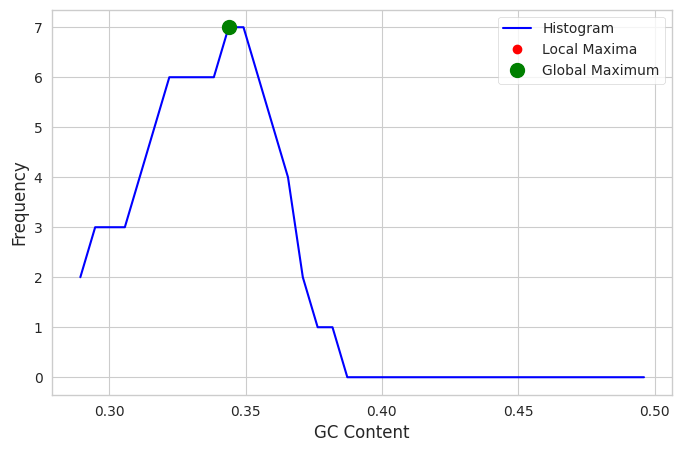

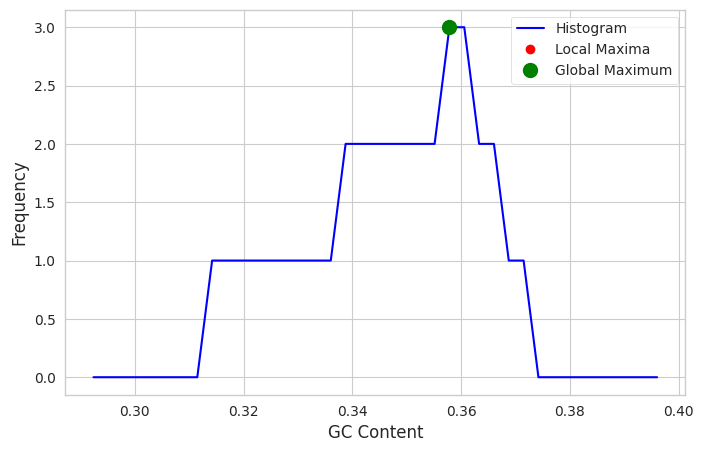

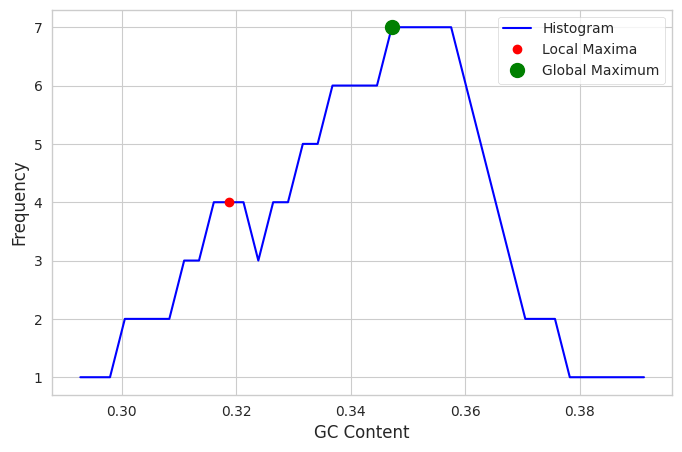

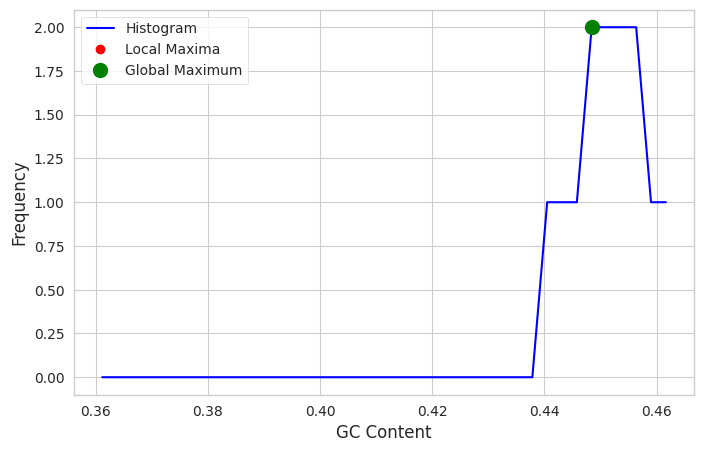

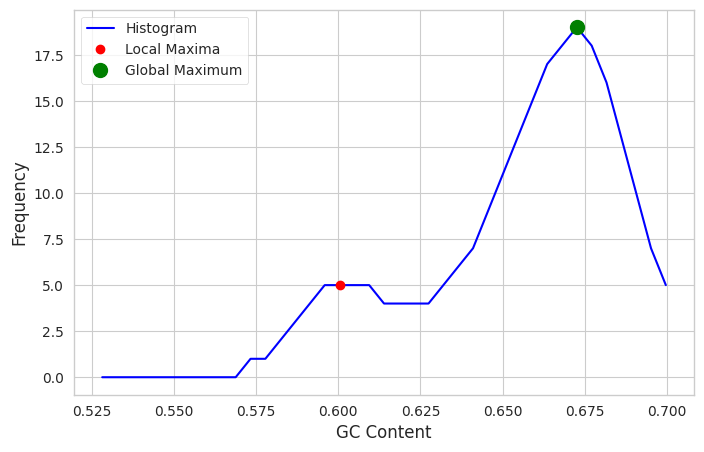

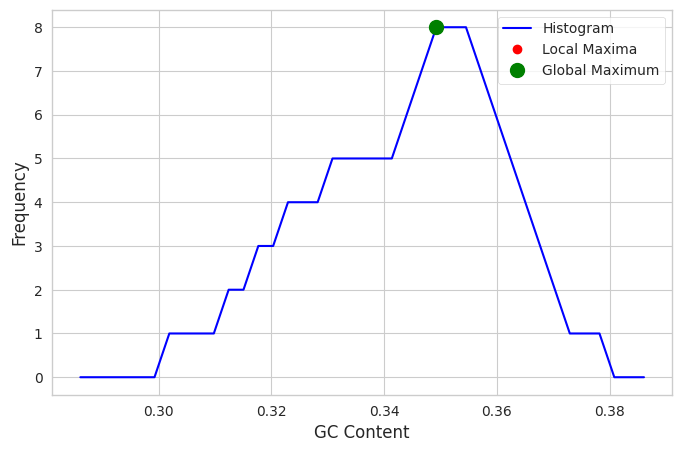

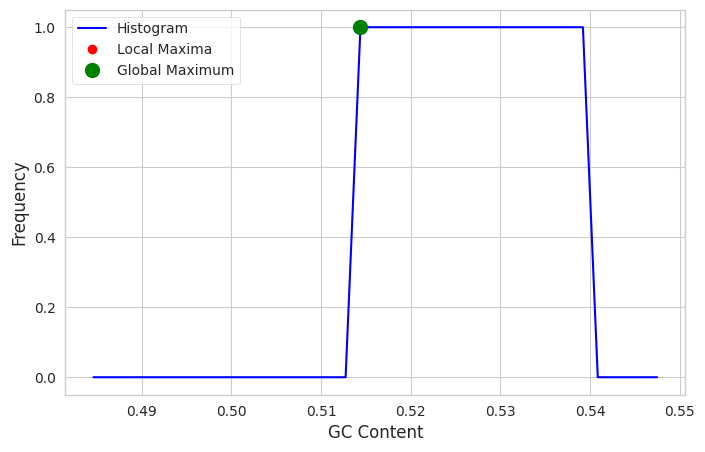

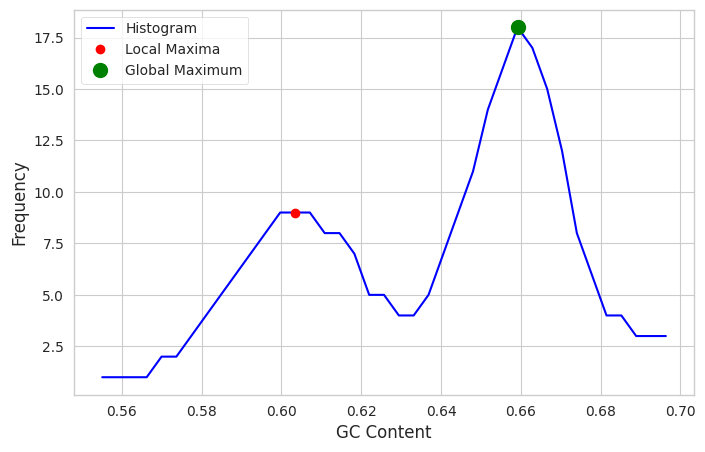

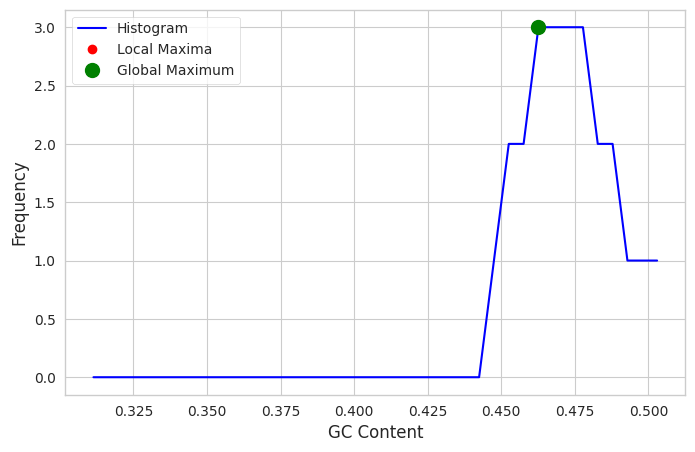

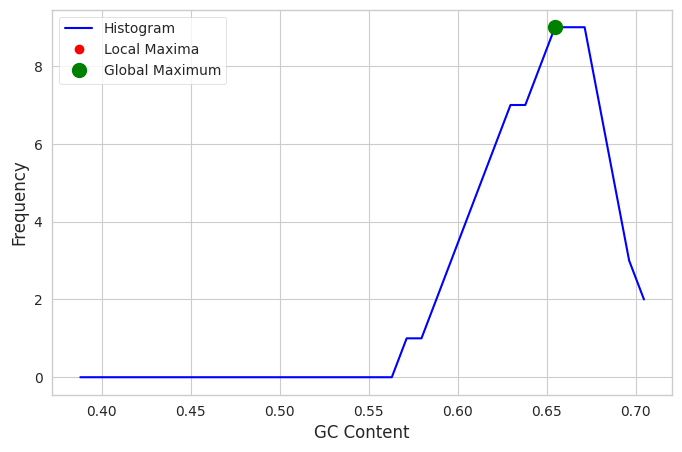

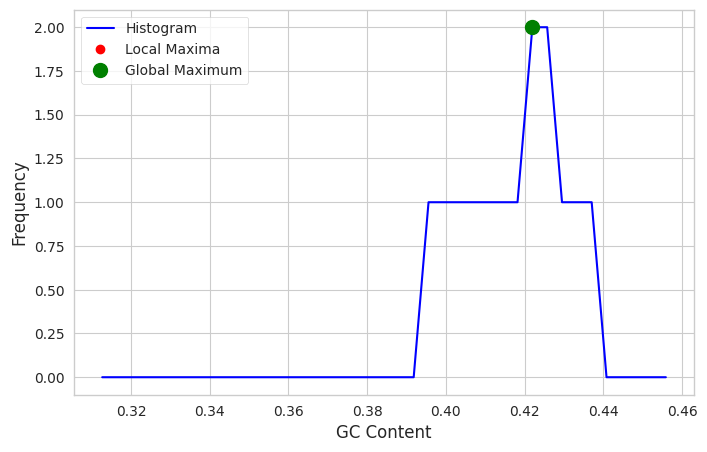

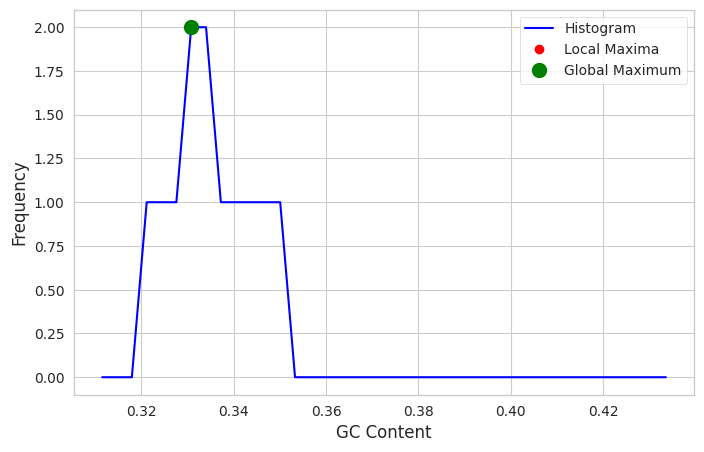

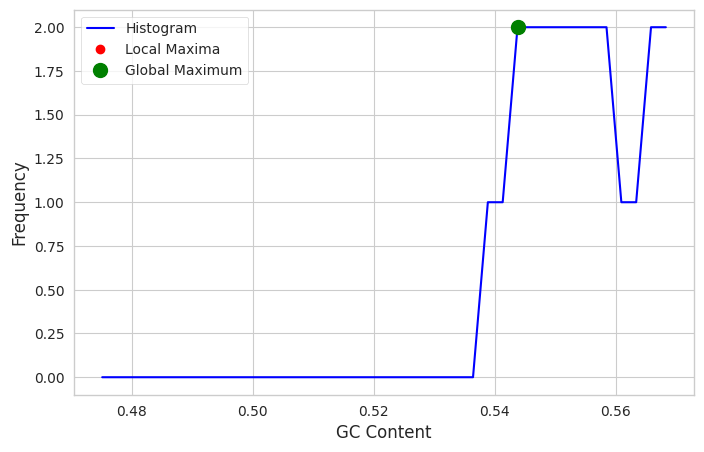

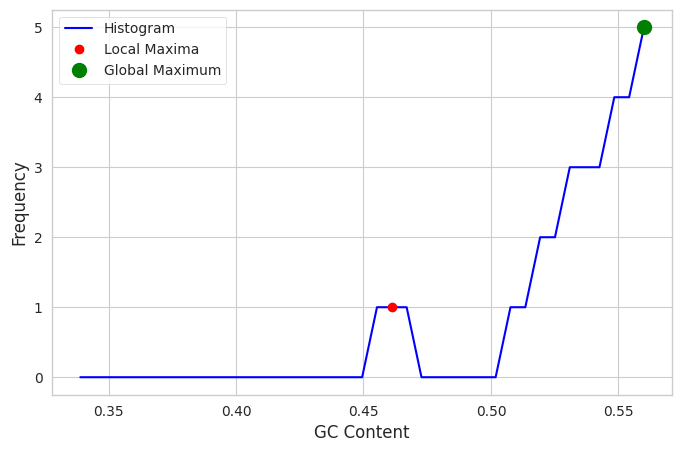

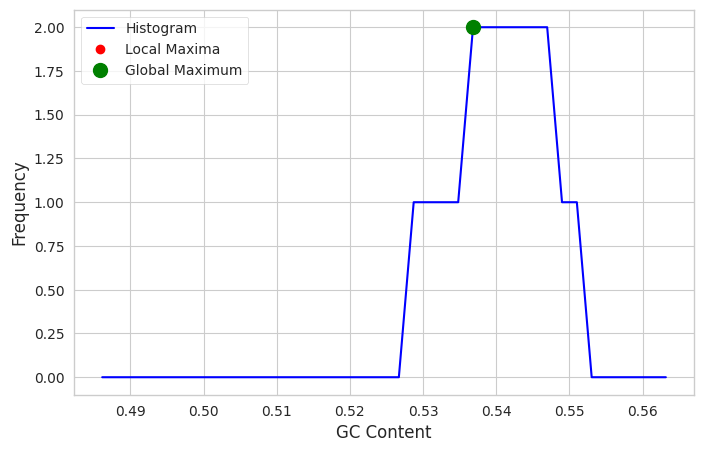

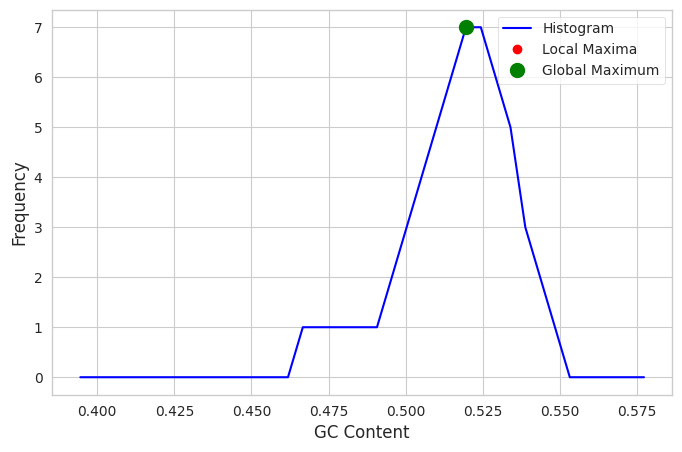

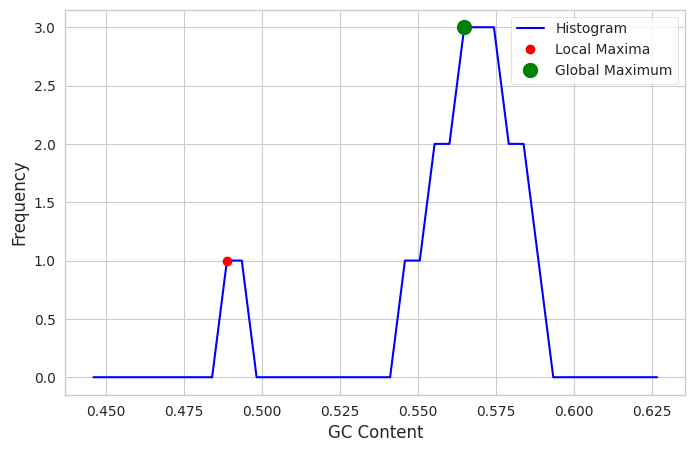

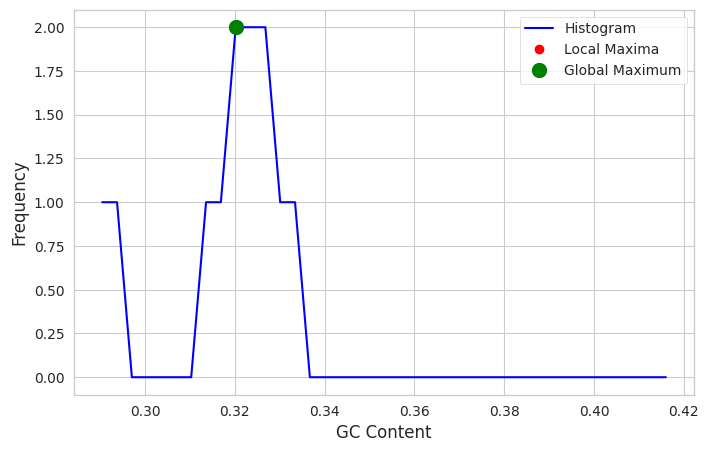

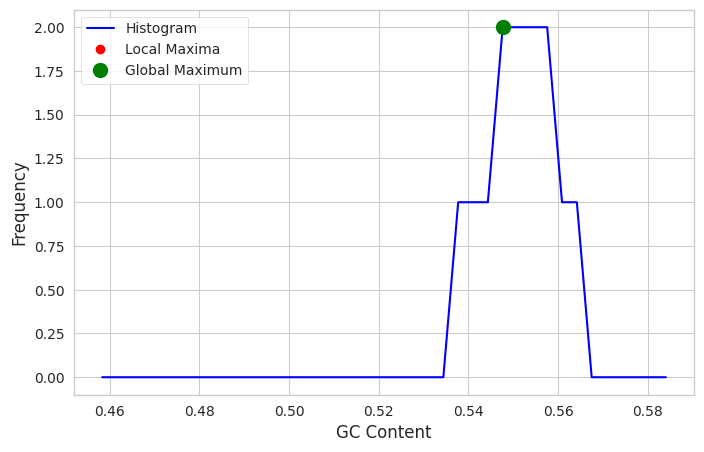

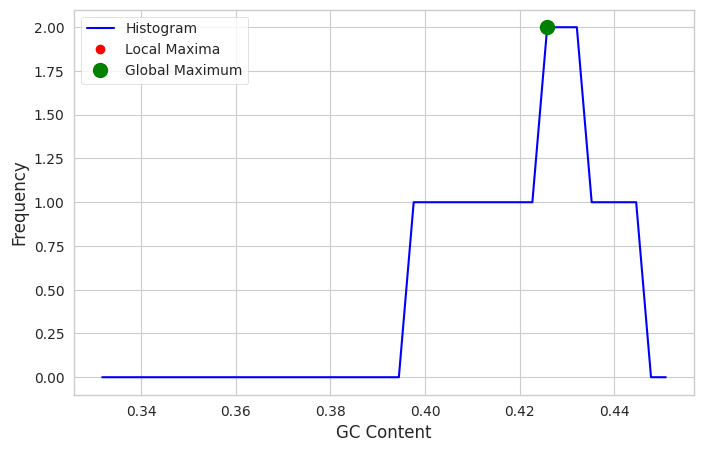

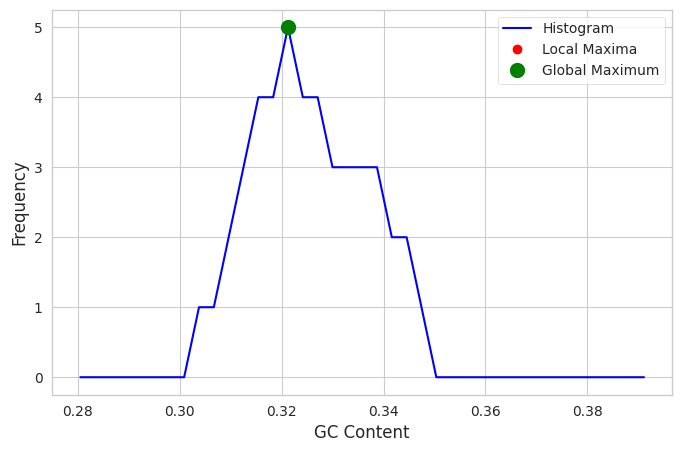

In [31]:
for i in range(1,30):
  processing = process_genomic_data(f"/content/LengthDepth_{i}.csv", False)
  df = processing[0]
  GC_peaks(df,True)

# **K Means**

Aplicamos la clusterización de Kmeans para ver cómo este algoritmo crea los umbrales de decisión y compararlos con los empíricos.

In [51]:
def BacterialCluster(l):
  if l == 0:
    return '1 bacteria'
  elif l == 2:
    return '2 bacterias'
  else:
    return 'contaminado'

In [55]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import numpy as np

X = np.array(cdf['final']).reshape(-1, 1)

model = KMeans(n_clusters=3, max_iter=1000, n_init=10, random_state=42).fit(X)

cdf.loc[:, 'cluster'] = model.labels_.astype(str)
label_mapping = {'1': 'contaminado', '2': '2 bacterias', '0': '1 bacteria'}
cdf.loc[:, 'cluster'] = cdf['cluster'].map(label_mapping)
cdf

2 bacterias  contaminación         final clasificacion      cluster
73     63.550474    9251.167348  18692.986118   contaminado  contaminado
65     43.235951    9074.125405  18277.958663   contaminado  contaminado
30    517.509928      18.584360   1589.698502   contaminado  2 bacterias
154    83.419689     451.187529   1152.634126   contaminado  2 bacterias
134   330.034032      39.760281   1069.622658   contaminado  2 bacterias
..           ...            ...           ...           ...          ...
123    23.170731      26.834943    123.182078    1 bacteria   1 bacteria
144    36.102951       5.198508    118.705869    1 bacteria   1 bacteria
152    26.968864      17.827425    116.561442    1 bacteria   1 bacteria
32     15.354698      25.158342     96.380778    1 bacteria   1 bacteria
87     19.711093      17.823934     94.781148    1 bacteria   1 bacteria

[154 rows x 5 columns]

Con el fin de analizar la similitud entre ambos algoritmos se dará uso del índice de Rand.

Como definición, el Índice de Rand calcula una medida de similitud entre dos conglomerados considerando todos los pares de muestras y contando los pares que se asignan en los mismos o diferentes conglomerados en las agrupaciones predichas y verdaderas.

Por lo tanto, el índice de Rand ajustado está asegurado de tener un valor cercano a 0.0. para etiquetado aleatorio independiente del número de conglomerados y muestras y exactamente 1.0 cuando las agrupaciones son idénticas.

Fuente: https://qu4nt.github.io/sklearn-doc-es/modules/generated/sklearn.metrics.adjusted_rand_score.html

Este sería el resultado:

In [69]:
from sklearn.metrics import adjusted_rand_score

# Ensure both columns are numeric
label_mapping = {'1 bacteria': 0, '2 bacterias': 2, 'contaminado': 1}
kmeans_numeric = cdf['cluster'].map(label_mapping)

# Compute ARI score
empirico = cdf['clasificacion'].map(label_mapping)  # Ensure 'clasificacion' is also numeric
ari_score = adjusted_rand_score(empirico, kmeans_numeric)

print("Puntaje Índice de Rand Ajustado (ARI):", ari_score)
empirico

Puntaje Índice de Rand Ajustado (ARI): 0.2593860329821204


73     1
65     1
30     1
154    1
134    1
      ..
123    0
144    0
152    0
32     0
87     0
Name: clasificacion, Length: 154, dtype: int64

# **Certeza de Clasificación:**

Se usó la función de sigmoide modificada para ajustar un 0.5 en los umbrales de clasificación

<ipython-input-90-2a8dd8e6cf59>:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


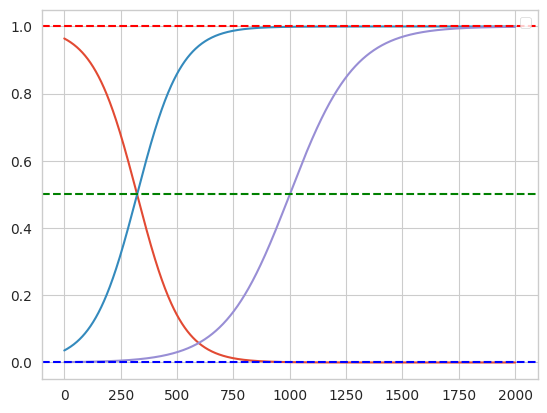

In [90]:
import numpy as np
import matplotlib.pyplot as plt

def s1(x):
    a = np.log(999) / (1000 - 323)
    return 1 / (1 + np.exp(a * (x - 323)))

def s2(x):
    a = np.log(999) / (1000 - 323)
    return 1 / (1 + np.exp(-a * (x - 323)))

def s3(x):
    a = np.log(999) / 1000
    return 1 / (1 + np.exp(-a * (x - 1000)))


x = np.linspace(0, 2000, 1000)
y1 = s1(x)

y2 = s2(x)

y3 =s3(x)

plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
plt.axhline(1, color='r', linestyle='--')
plt.axhline(0.5, color='g', linestyle='--')
plt.axhline(0, color='b', linestyle='--')
plt.legend()
plt.show()

In [86]:
print(s3(2000))

0.9989999999999999
